<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Imports" data-toc-modified-id="Imports-1">1&nbsp;&nbsp;Imports</a></span></li>
<li><span><a href="#Data imports" data-toc-modified-id="Data imports-2">2&nbsp;&nbsp;Data imports</a></span></li>
<li><span><a href="#RNAseq unimodal" data-toc-modified-id="RNAseq unimodal-3">3&nbsp;&nbsp;RNAseq unimodal</a></span></li>
<li><span><a href="#TCR unimodal" data-toc-modified-id="TCR unimodal-4">4&nbsp;&nbsp;TCR unimodal</a></span></li>
<li><span><a href="#Cytof unimodal" data-toc-modified-id="Cytof unimodal-5">5&nbsp;&nbsp;TCR unimodal</a></span></li>
<li><span><a href="#Microbiome unimodal" data-toc-modified-id="Microbiome unimodal-6">6&nbsp;&nbsp;Microbiome unimodal</a></span></li>
<li><span><a href="#TCRseq RNAseq fusion" data-toc-modified-id="TCRseq RNAseq fusion-7">7&nbsp;&nbsp;TCRseq RNAseq fusion</a></span></li>
<li><span><a href="#Cytof RNAseq fusion" data-toc-modified-id="Cytof RNAseq fusion-8">8&nbsp;&nbsp;Cytof RNAseq fusion</a></span></li>
<li><span><a href="#Cytof TCRseq fusion" data-toc-modified-id="Cytof TCRseq fusion-9">9&nbsp;&nbsp;Cytof TCRseq fusion</a></span></li>
<li><span><a href="#Cytof RNAseq TCRseq fusion" data-toc-modified-id="Cytof RNAseq TCRseq fusion-10">10&nbsp;&nbsp;Cytof RNAseq TCRseq fusion</a></span></li>
<li><span><a href="#Microbiome RNAseq fusion" data-toc-modified-id="Microbiome RNAseq fusion-11">11&nbsp;&nbsp;Microbiome RNAseq fusion</a></span></li>
<li><span><a href="#Microbiome Cytof RNAseq fusion" data-toc-modified-id="Microbiome Cytof RNAseq fusion-12">12&nbsp;&nbsp;Microbiome Cytof RNAseq fusion</a></span></li>
</ul>
</div>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
from sklearn import metrics

import snf

import src.modules.data_loading as data_loading
import src.modules.utils as utils
import src.modules.plotting as plotting

# Cytof unimodal

In [2]:
# Set up directories
data_dir = "./data/"
results_dir = './results/'

rna_dir = os.path.join(data_dir, 'RNA_seq/')
tcr_dir = os.path.join(data_dir, 'TCR_seq/')
cytof_dir = os.path.join(data_dir, 'CyTOF/')
micro_dir = os.path.join(data_dir, 'microbiome_analysis/')
processed_dir = os.path.join(data_dir, 'processed_data/')
bubble_dir = os.path.join(processed_dir, 'bubble_plot_data/')
chord_dir = os.path.join(processed_dir, 'chord_plot_data/')


for dir in [rna_dir, tcr_dir, cytof_dir, micro_dir,
            data_dir, results_dir, processed_dir, bubble_dir]:
    try:
        os.mkdir(dir)
    except:
        pass


random_state = 42

# not used after development
path_sets  = [ 
            'WikiPathway_2021_Human',
            'MSigDB_Hallmark_2020',
            'GO_Biological_Process_2021',
            'GO_Cellular_Component_2021',
            'GO_Molecular_Function_2021',
            ]

hallmark = ['MSigDB_Hallmark_2020']

# General metric to use
metric = 'sqeuclidean'

# Data imports

## Metadata

In [3]:
meta = data_loading.metadata_import(os.path.join(data_dir, 'ERC_meta.xlsx'))
print(f"Number of individuals with metadata: {len(meta['Subjectnr'].unique())}")
print(meta['Group'].value_counts())

meta['smoking'] = meta['smoking'].replace({'vaping' : 1, '?' : np.nan, '1 10/d': 1, '1 occasional' : 1})
print(meta['smoking'].value_counts())

print('\n\n\n\n')
print('******* Metadata description *******')
print('\n\n')
print(meta[['BDI T-score (depression)', 'BAI T-score (anxiety)','Age', 'CMV IgG (U/mL)', 'BMI', '25-OH-Vit D']].describe())
for col in ['Long covid', 'Covid 19 (1/0)', 'Group', 'Gender', 'smoking']:
    print(f'{meta[col].value_counts()}\n')

Number of individuals with metadata: 569
control             254
patient             164
household member    151
Name: Group, dtype: int64
0.0    478
1.0     55
Name: smoking, dtype: int64





******* Metadata description *******



       BDI T-score (depression)  BAI T-score (anxiety)         Age  \
count                135.000000             148.000000  564.000000   
mean                  51.525926              54.513514   47.980496   
std                    9.397387              11.654018   15.680014   
min                   35.000000              43.000000   15.000000   
25%                   44.000000              46.000000   34.750000   
50%                   53.000000              51.000000   49.500000   
75%                   58.000000              59.000000   60.000000   
max                   72.000000              99.000000   85.000000   

       CMV IgG (U/mL)         BMI  25-OH-Vit D  
count      510.000000  534.000000   510.000000  
mean       139.287149   25.996367    

In [4]:
### Identify those patients that had covid in one group and those that present anxiety and depression data in another
### The meta df will only contain the other variables
covid_patients = meta[['Subjectnr', 'Long covid', 'Covid 19 (1/0)']]
positivity_data = meta[['Subjectnr', 'Covid 19 (1/0)']]
dep_anx = meta[['Subjectnr', 'BDI T-score (depression)', 'BAI T-score (anxiety)']]

meta = meta[['Subjectnr', 'Group', 'Age', 'Gender', 'CMV IgG (U/mL)', 'BMI', '25-OH-Vit D','smoking']]
print('Patients with covid data:')
print(covid_patients['Covid 19 (1/0)'].value_counts())

Patients with covid data:
0.0    297
1.0    208
Name: Covid 19 (1/0), dtype: int64


In [5]:
# For those patients that had covid but are missing the long covid information it means that they did not have LC
covid_patients = covid_patients[covid_patients['Covid 19 (1/0)'] == 1]
covid_patients.fillna(0, inplace=True)
covid_patients.rename(columns={'Subjectnr': 'Donor'}, inplace = True)
covid_patients.drop(columns=['Covid 19 (1/0)'], inplace=True)
covid_patients.reset_index(drop = True, inplace=True)
covid_patients['Long covid'].value_counts()

0.0    119
1.0     89
Name: Long covid, dtype: int64

In [6]:
# We drop those that are missing either depression or anxiety parameters
dep_anx = dep_anx[dep_anx[['BDI T-score (depression)', 'BAI T-score (anxiety)']].notna()]
dep_anx.rename(columns={'Subjectnr': 'Donor'}, inplace = True)
dep_anx.reset_index(drop = True, inplace=True)

In [7]:
meta = meta[['Subjectnr', 'Group', 'Age', 'Gender', 'CMV IgG (U/mL)', 'BMI', '25-OH-Vit D','smoking']]

## TCR_stats

In [8]:
# We load the TCR metadata
TCR_stats = data_loading.tcr_stats_import(tcr_dir)
print(f"Number of TCR_stats people: {len(TCR_stats['Donor'].unique())}")

Number of TCR_stats people: 99


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/data_loading.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  TCR_stats = TCR_stats.groupby(['description'], axis=0).sum()[['totalcountCD4','totalcountCD8',
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/data_loading.py:103: FutureWarning: The default value of regex will change from True to False in a future version.
  TCR_stats['description'] = TCR_stats['description'].str.replace(orig, rep)


In [9]:
# Remove the columns used for the previous calculation
TCR_stats.drop(columns=['totalcountCD4', 'totalcountCD8'], inplace=True)
TCR_stats.head()

Donor  entropyCD4  entropyCD8  tcrcovidmatchCD4  tcrcovidmatchCD8  \
0  Covid HH001    0.936322    0.811990          0.001242          0.000526   
1  Covid HH031    0.933120    0.699470          0.001003          0.000891   
2  Covid HH032    0.948882    0.754762          0.000664          0.000000   
3  Covid HH039    0.951134    0.847985          0.000744          0.001045   
4  Covid HH044    0.941967    0.931616          0.000715          0.000537   

   tcrcovidfreqCD4  tcrcovidfreqCD8  
0         0.001080         0.000058  
1         0.000839         0.000532  
2         0.000865         0.000000  
3         0.000871         0.000092  
4         0.000694         0.000334

## TCRseq

In [10]:
tcr_raw = data_loading.tcrseq_loading(tcr_dir)

In [11]:
len(tcr_raw['cdr3'].unique())

2024226

In [12]:
# Load TCR modules
tcr_modules = pd.read_csv(tcr_dir+'spectral_clustering.csv', index_col=0)
tcr_modules["module"] = "M"+tcr_modules["cluster"].astype(str)
tcr_modules.rename(columns={'v_call': 'vgene', 'junction_aa': 'cdr3'}, inplace=True)

In [13]:
module_annot = pd.merge(
    left=tcr_raw,
    right=tcr_modules,
    on=["vgene", "cdr3"]
)
module_annot.head()

tcrseq       sample  count      freq  \
0    TRBV10-1\tCASSAGDTQYF\tTRBJ2-3  Covid PT002   22.0  0.000011   
1    TRBV10-1\tCASSAGYEQYF\tTRBJ2-7  Covid PT043   11.0  0.000003   
2   TRBV10-1\tCASSDGNTEAFF\tTRBJ1-1  Covid PT040    5.0  0.000001   
3  TRBV10-1\tCASSDGNTGELFF\tTRBJ2-2    ERC CO229   90.0  0.000013   
4    TRBV10-1\tCASSDGYEQYF\tTRBJ2-7  Covid PT132   20.0  0.000005   

            cdr3        vgene       jgene  cluster module  
0    CASSAGDTQYF  TRBV10-1*01  TRBJ2-3*01       84    M84  
1    CASSAGYEQYF  TRBV10-1*01  TRBJ2-7*01      920   M920  
2   CASSDGNTEAFF  TRBV10-1*01  TRBJ1-1*01      873   M873  
3  CASSDGNTGELFF  TRBV10-1*01  TRBJ2-2*01      261   M261  
4    CASSDGYEQYF  TRBV10-1*01  TRBJ2-7*01      489   M489

In [14]:
module_counts_tcr  = module_annot.groupby("module").agg({"sample":Counter})
module_counts_total = module_counts_tcr["sample"].sum()

for group in module_counts_total.keys():
    module_counts_tcr[group] = module_counts_tcr["sample"].str[group].fillna(0) / module_counts_total[group]
module_counts_tcr.drop(columns='sample', inplace = True)
    
module_counts_tcr = module_counts_tcr.T
module_counts_tcr.reset_index(names='Donor',inplace = True)
module_counts_tcr.sort_values(by=['Donor'], inplace=True)
module_counts_tcr.reset_index(drop = True, inplace = True)
module_counts_tcr.head()

module        Donor       M-1        M0        M1  M10      M100      M101  \
0       Covid HH001  0.001062  0.009554  0.001062  0.0  0.001062  0.000000   
1       Covid HH031  0.000000  0.004343  0.002172  0.0  0.000000  0.000000   
2       Covid HH032  0.000000  0.006098  0.001742  0.0  0.000871  0.000871   
3       Covid HH039  0.000000  0.001234  0.000617  0.0  0.000000  0.001234   
4       Covid HH044  0.000000  0.006159  0.002309  0.0  0.000000  0.001540   

module  M102      M103     M104  ...      M990      M991      M992  M993  \
0        0.0  0.001062  0.00000  ...  0.000000  0.004246  0.000000   0.0   
1        0.0  0.000000  0.00000  ...  0.000000  0.006515  0.003257   0.0   
2        0.0  0.000000  0.00000  ...  0.001742  0.002613  0.004355   0.0   
3        0.0  0.000617  0.00000  ...  0.000617  0.003701  0.003085   0.0   
4        0.0  0.000000  0.00077  ...  0.000770  0.002309  0.003849   0.0   

module      M994      M995      M996      M997      M998  M999  
0       0.000000  0.001062  0.001062  0.000000  0.000000   0.0  
1       0.000000  0.002172  0.005429  0.001086  0.001086   0.0  
2       0.000871  0.001742  0.000000  0.000000  0.000000   0.0  
3       0.000000  0.001234  0.002468  0.000000  0.000617   0.0  
4       0.000000  0.001540  0.011547  0.000000  0.000000   0.0  

[5 rows x 1000 columns]

## Cytof

In [15]:
all_cytof = data_loading.import_all_cytof(cytof_dir)

# Remove degraded frozen samples 
to_remove = pd.read_csv(cytof_dir + '/cytof_to_exclude.csv', sep=';', index_col=0)
all_cytof = all_cytof[ ~all_cytof['Donor'].isin(to_remove['Donor']) ]

all_cytof.sort_values(by = ['Donor'], inplace = True)
all_cytof.reset_index(drop=True,inplace = True)


# Divide the Cytof dataset into cell counts DataFrame and metadata Dataframe
cytof = all_cytof.filter(regex='Cluster', axis=1).drop(columns=['Cluster 0']) 
percent_cytof_data = all_cytof.filter(regex='percent', axis=1)
cytof_meta = all_cytof.loc[:, (~all_cytof.columns.isin(cytof.columns)) &
                          (~all_cytof.columns.isin(percent_cytof_data.columns))].drop(columns=['Cluster 0', 'Metacluster 0']) 

print(f'Cytof shape {cytof.shape} and Cytof metaclusters shape {cytof_meta.shape}')

Cytof shape (236, 144) and Cytof metaclusters shape (236, 23)


In [16]:
cytof.head()

Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  Cluster 6  \
0   0.167938   0.160573   0.048614   0.008839   0.002946   0.010312   
1   0.321098   1.433993   1.559269   1.601839   1.328176   1.295337   
2   0.093486   0.910990   0.202884   0.023869   0.057683   0.208851   
3   1.158810   0.151435   0.213985   0.062549   0.009876   0.042797   
4   0.005670   0.002268   0.157614   0.070303   0.002268   0.005670   

   Cluster 7  Cluster 8  Cluster 9  Cluster 10  ...  Cluster 135  Cluster 136  \
0   0.070711   0.440470   1.518812    1.618986  ...     0.652603     0.360920   
1   0.295556   0.692063   0.469484    1.381693  ...     0.644628     0.279744   
2   0.513178   1.052213   1.947290    2.424664  ...     0.139234     0.246643   
3   0.309455   0.780221   0.213985    0.816434  ...     0.744008     0.164604   
4   0.542012   1.850550   0.691688    1.321011  ...     1.580678     0.731375   

   Cluster 137  Cluster 138  Cluster 139  Cluster 140  Cluster 141  \
0     0.452255     0.095754     0.453729     2.594208     0.583365   
1     0.655574     0.110681     0.240823     0.288258     0.291907   
2     0.686226     0.352064     0.523123     1.121830     0.706116   
3     0.921780     0.158019     0.302871     1.678957     2.044377   
4     1.609026     0.195033     0.392335     1.177004     0.498923   

   Cluster 142  Cluster 143  Cluster 144  
0     0.509708     0.039775     0.531805  
1     1.189521     0.054733     0.659223  
2     0.527101     0.067628     0.383889  
3     2.169476     0.292994     0.401633  
4     1.729221     0.357183     0.796009  

[5 rows x 144 columns]

In [17]:
cytof_meta.head()

Sen_CD8+Temra  Sen_CD4+Tem  Exh_CD4+Tef   CD8+Tcm  Exh_CD4+Tcm  CD4+Tregs  \
0       1.141687     0.022097     0.826434  1.518812    21.132259   2.000530   
1      10.877180     4.225352     1.644409  0.469484    12.732005   0.885451   
2       6.611636     0.290403     2.357036  1.947290    32.799602   1.631029   
3       8.236766     0.115223     1.725046  0.213985    16.806031   0.707796   
4       0.293684     0.078240     3.061572  0.691688    16.067581   1.001247   

        NKT  Exh_CD4+Th2cm         NK   CD8+Tem  ...    CD4+Tna  \
0  0.201821       0.592204   4.982175  1.371498  ...  36.809463   
1  0.250553       0.505972  17.600769  1.725899  ...  22.771169   
2  0.125311       1.883640   2.345102  1.012432  ...  12.256589   
3  2.274822       0.385173   2.136555  9.938767  ...   5.655781   
4  0.163284       0.899195  11.241637  4.340628  ...  25.470008   

   Fas+Tim3+CD11c+CD14+  Act_CCR4+CD11cintCD14int   CD8+Tna       DNT  \
0             11.393300                  0.042721  2.719425  0.070711   
1              9.214527                  0.111898  5.442847  0.045002   
2             14.512183                  0.113376  3.234212  0.021880   
3             23.353964                  0.023045  2.189228  0.029629   
4             19.004422                  0.176891  5.389500  0.065767   

   CCR7+CD45RA+CCR6+CXCR5+LAG3+CD25+B  Act_CD4+Tef  \
0                            0.116378     0.160573   
1                            0.063246     0.150819   
2                            0.268523     0.031825   
3                            0.141559     0.016460   
4                            0.149677     0.374192   

   CCR7-CD45RA+CCR6-CXCR5-Fas+B  CCR7+CD45RA+CCR6+CXCR5+LAG3-CD25-B  \
0                      0.114905                            6.249079   
1                      0.031623                            3.322873   
2                      0.049727                            6.022874   
3                      0.023045                            8.987358   
4                      0.068035                            5.906565   

         Donor  
0  Covid HH008  
1  Covid HH021  
2  Covid HH023  
3  Covid HH031  
4  Covid HH032  

[5 rows x 23 columns]

## Microbiome

In [18]:
# Load microbial data keeping only ASVs with at at max 90% missingness in the dataset
micro_fused, micro_taxa = data_loading.microbiome_import(micro_dir, .9, 'abundance')
micro_fused_rel, _ = data_loading.microbiome_import(micro_dir, .9, 'rel_abundance')

print(f"Number of patients with microbiome data: {len(micro_fused_rel['Donor'].unique())}")
print(f"Relative abudances:\n{micro_fused_rel.head()}")

Number of patients with microbiome data: 182
Relative abudances:
         Donor        t1       t10      t101     t1014     t1015  t102  \
0  Covid HH031  0.000000  0.072185  0.002244  0.000000  0.000000   0.0   
1  Covid HH032  0.219139  0.010078  0.001988  0.000000  0.000000   0.0   
2  Covid HH039  0.000119  0.014683  0.001698  0.000153  0.000000   0.0   
3  Covid HH053  0.000000  0.006801  0.001658  0.000000  0.000226   0.0   
4  Covid HH078  0.000000  0.064245  0.000000  0.000000  0.000000   0.0   

      t1029      t103      t104  ...  t950       t96  t960  t961       t97  \
0  0.000000  0.001496  0.002548  ...   0.0  0.000000   0.0   0.0  0.003834   
1  0.000000  0.000904  0.001582  ...   0.0  0.001062   0.0   0.0  0.000926   
2  0.000034  0.003191  0.000000  ...   0.0  0.000000   0.0   0.0  0.000000   
3  0.000000  0.002600  0.003843  ...   0.0  0.000000   0.0   0.0  0.000490   
4  0.000000  0.000187  0.000000  ...   0.0  0.000000   0.0   0.0  0.002753   

   t972       t98    

In [19]:
print(f"Absolute abudances:\n{micro_fused.head()}")

Absolute abudances:
         Donor      t1     t10   t101  t1014  t1015  t102  t1029   t103  \
0  Covid HH031     0.0  3088.0   96.0    0.0    0.0   0.0    0.0   64.0   
1  Covid HH032  9698.0   446.0   88.0    0.0    0.0   0.0    0.0   40.0   
2  Covid HH039     7.0   865.0  100.0    9.0    0.0   0.0    2.0  188.0   
3  Covid HH053     0.0   361.0   88.0    0.0   12.0   0.0    0.0  138.0   
4  Covid HH078     0.0  2404.0    0.0    0.0    0.0   0.0    0.0    7.0   

    t104  ...  t950   t96  t960  t961    t97  t972    t98    t99  t991  t994  
0  109.0  ...   0.0   0.0   0.0   0.0  164.0   0.0    0.0  206.0   0.0  14.0  
1   70.0  ...   0.0  47.0   0.0   0.0   41.0   0.0  202.0   94.0   0.0   0.0  
2    0.0  ...   0.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0   5.0   7.0  
3  204.0  ...   0.0   0.0   0.0   0.0   26.0   0.0  853.0   45.0   0.0   0.0  
4    0.0  ...   0.0   0.0   0.0   0.0  103.0   0.0    0.0    0.0   0.0   0.0  

[5 rows x 388 columns]


In [20]:
print(f"Taxonomic information:\n{micro_taxa.head()}")

Taxonomic information:
    kingdom         phylum        class          order           family  \
1  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Prevotellaceae   
2  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
3  Bacteria     Firmicutes   Clostridia  Clostridiales  Ruminococcaceae   
4  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   
5  Bacteria     Firmicutes   Clostridia  Clostridiales  Ruminococcaceae   

              genus   species  \
1        Prevotella       NaN   
2       Bacteroides       NaN   
3  Faecalibacterium       NaN   
4           Blautia  wexlerae   
5  Faecalibacterium       NaN   

                                               taxon taxon_id  length  \
1  TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...       t1     253   
2  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...       t2     253   
3  AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...       t3     253   
4  TACGTAGGGGGCAAGCGTTATCCGGATTTACT

In [21]:
#### Abundance normalisation
micro_data_norm = micro_fused.drop(columns = ['Donor']).T.copy()
micro_data_norm.columns = micro_fused['Donor']

micro_data_norm['taxaname'] = micro_data_norm.index
micro_data_norm['taxaname'] = [list(micro_taxa[micro_taxa['taxon_id'] == taxon]['taxon_name'])[0] for taxon in micro_data_norm['taxaname']]
micro_data_norm.reset_index(drop = True, inplace = True)
micro_data_norm.replace(0,1, inplace=True) 

# Dummy design variable for the microbial normalisation
clusters = pd.DataFrame()
clusters['Cluster'] = ['C']*(micro_data_norm.shape[1]-1)
clusters.index = micro_data_norm.drop(columns = 'taxaname').columns

micro_data_norm.iloc[:,:-1] = micro_data_norm.iloc[:,:-1].apply(pd.to_numeric)
micro_data_norm.reset_index(drop=True, inplace=True)
micro_data_norm= micro_data_norm[ ['taxaname'] + [ col for col in micro_data_norm.columns if col != 'taxaname' ] ]
micro_data_norm = utils.deseq2(micro_data_norm, clusters, 'taxaname','~1', processed_dir + 'normalized_counts_bacteria.csv')


eigentaxa = pd.read_csv(micro_dir + 'Eigentaxa_values.csv')
eigentaxa['eigentaxa'] = 'eigentaxa_' + eigentaxa['eigentaxa'].astype(str)






   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Normalizing counts


In [22]:
### CSV for R visualisations
#save = pd.merge(micro_fused, meta, how="left", left_on='Donor', right_on='Subjectnr')
#save.drop(columns='Subjectnr', inplace = True)
#save = pd.concat([save.iloc[:,0], save.iloc[:,-6:]], axis = 1)
#save.to_csv(results_dir+'microbiome_patients.csv', sep='\t')

In [23]:
### Constructing bacterial sets for GSEA
custom_bacteria_gene_lists = {}
for family in micro_taxa['family'].unique():
    custom_bacteria_gene_lists[family] = list(micro_taxa[micro_taxa['family'] == family]['taxon_name'])

In [24]:
####### Restrict the analysis to the strains used to generate the eigen taxa
micro_data_norm = micro_data_norm[micro_data_norm['taxaname'].isin(list(eigentaxa['microbe']))]
micro_data_norm.reset_index(drop = True, inplace=True)

eigentaxa.replace({"microbe": dict(zip(micro_taxa['taxon_name'], micro_taxa['taxon_id']))}, inplace=True)
eigentaxa.head()

micro_fused_rel = micro_fused_rel[[c for c in micro_fused_rel.columns if c in list(eigentaxa['microbe']) or c == 'Donor']]
micro_fused = micro_fused[[c for c in micro_fused.columns if c in list(eigentaxa['microbe']) or c == 'Donor']]

In [25]:
### PCA 1-D encoding of the bacterial data into eigentaxa
microbiome_encoded = utils.eigentaxa_encoding(micro_fused_rel, eigentaxa)
microbiome_encoded.head()

eigentaxa_0  eigentaxa_1  eigentaxa_10  eigentaxa_11  eigentaxa_12  \
0     0.534674    -1.103063     -0.515694     -0.339305     -0.359047   
1     0.346591    -0.917328     -0.016080     -0.545573      1.809200   
2    -0.316530    -0.918038     23.285471      0.073794     -0.359047   
3    -0.878883     0.158562     -0.020748      0.794913      2.978352   
4     3.449191    -1.076712     -0.530904     -0.746954     -0.359047   

   eigentaxa_13  eigentaxa_14  eigentaxa_15  eigentaxa_16  eigentaxa_17  ...  \
0     -0.591040      0.071445      0.166510     -0.093703     -0.660860  ...   
1     -0.856713     -0.014383     -0.878183     -0.632979     -0.075911  ...   
2      0.164954      2.043480     -0.377307      1.021821      2.061794  ...   
3     -1.081879      1.240059      3.345634      0.522228     -0.137327  ...   
4      0.873927      0.008099     -0.717923     -0.996548     -0.660860  ...   

   eigentaxa_70  eigentaxa_74  eigentaxa_75  eigentaxa_78  eigentaxa_79  \
0     -0.195794     -0.212473     -0.310594      -0.21511     -0.248261   
1      0.698922      2.331790     -0.310594      -0.21511     -0.053615   
2      0.528947     -0.343732     -0.310594      -0.21511     -0.248261   
3     -0.195794     -0.343732     -0.310594      -0.21511      6.615941   
4     -0.195794     -0.343732     -0.310594      -0.21511     -0.248261   

   eigentaxa_8  eigentaxa_80  eigentaxa_81  eigentaxa_83  eigentaxa_9  
0    -0.489774     -0.360282      0.080764     -0.423584    -0.569979  
1    -0.430871     -0.416632      0.167324      1.448315    -0.298759  
2     0.085085      0.463747     -0.275697     -0.422569    -0.569979  
3     2.041002     -0.498553     -0.275697     -0.423584     1.245748  
4    -0.991343     -0.273423      0.946867     -0.423584    -0.569979  

[5 rows x 75 columns]

## RNAseq

### Readcounts files

In [26]:
rna = data_loading.rna_import(rna_dir)
count_matrix, des = data_loading.cleanup_rna(rna)

des.set_index('colnames', inplace=True)

normalized_counts = utils.deseq2(count_matrix, des, 'genename','~1', processed_dir + 'normalized_counts.csv')

normalized_counts = pd.read_csv(processed_dir + 'normalized_counts.csv', sep='\t', index_col = 0)

['./data/RNA_seq/readcounts_210915.txt', './data/RNA_seq/readcounts_210901.txt', './data/RNA_seq/readcounts_210811.txt', './data/RNA_seq/readcounts_210804.txt', './data/RNA_seq/readcounts_210818.txt', './data/RNA_seq/readcounts_210825.txt', './data/RNA_seq/readcounts_210728.txt', './data/RNA_seq/readcounts_210908.txt']

Number of files: 8
Started!


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/data_loading.py:336: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 161_x'} in the result is deprecated and will raise a MergeError in a future version.
  raw_rna = pd.merge(raw_rna, pd.read_csv(f, sep = '\t'), how="inner", on='genename')


Ended!
Number of unique transcripts: 30795
Number of patients: 317








-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Normalizing counts


In [27]:
# Select patients with gene expression and their metadata
patients = pd.DataFrame([c.replace('.', ' ', 1) for c in normalized_counts.drop('genename', axis = 1)],columns =['Patient'])
patients = pd.merge(patients, meta, how="left", left_on='Patient', right_on = 'Subjectnr').reset_index(drop=True)
patients.drop(columns={'Subjectnr'}, inplace=True)
patients.rename(columns={'Patient': 'Subjectnr'},inplace=True)

### Gene name mapping

In [28]:
mapped = utils.gene_mapping(normalized_counts, processed_dir)
normalized_counts = pd.read_csv(processed_dir + 'normalized_counts_renamed.csv', sep='\t', index_col = 0)

Finished querying!
Finished mapping!


### Module aggregation

In [29]:
aggregated = utils.aggregate_modules('pca', normalized_counts, data_dir, processed_dir)
aggregated = pd.read_csv(processed_dir + 'pca_aggregated.csv', sep='\t', index_col = 0)
aggregated['Donor'] = patients['Subjectnr']

/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pose[group_name] = df_group.flatten().tolist()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pose[group_name] = df_group.flatten().tolist()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

## Descriptive stats

In [30]:
print(meta.describe())
print(meta['Gender'].value_counts())
print(meta['smoking'].value_counts())
print(meta['Group'].value_counts())

              Age  CMV IgG (U/mL)         BMI  25-OH-Vit D     smoking
count  564.000000      510.000000  534.000000   510.000000  533.000000
mean    47.980496      139.287149   25.996367    21.268627    0.103189
std     15.680014      193.521809    4.771720     8.931545    0.304492
min     15.000000        0.000000   16.464360     0.000000    0.000000
25%     34.750000        0.150000   22.679952    15.000000    0.000000
50%     49.500000        0.150000   25.254426    20.000000    0.000000
75%     60.000000      271.500000   28.622786    27.000000    0.000000
max     85.000000      500.000000   53.345527    65.000000    1.000000
f    321
m    213
Name: Gender, dtype: int64
0.0    478
1.0     55
Name: smoking, dtype: int64
control             254
patient             164
household member    151
Name: Group, dtype: int64


In [31]:
# Suumary statistics for the different datasets
for df,df_name in zip([all_cytof, micro_fused, aggregated, TCR_stats], ['Cytof', 'Microbiome', 'RNAseq', 'TCRseq']):
    print("*****************************************************************************************************************************************")
    print(f"\n\n{df_name} data:\n\n")
    print(f"Numeric metadata:\n{meta[meta['Subjectnr'].isin(df['Donor'])].describe()}")
    print(f"Gender:\n{meta[meta['Subjectnr'].isin(df['Donor'])]['Gender'].value_counts()}")
    print(f"Smoking:\n{meta[meta['Subjectnr'].isin(df['Donor'])]['smoking'].value_counts()}")
    print(f"Grouping:\n{meta[meta['Subjectnr'].isin(df['Donor'])]['Group'].value_counts()}")
    print(f"Anxiety/Depression information:\n{dep_anx[dep_anx['Donor'].isin(df['Donor'])].describe()}")
    print(f"Covid positivity:\n{positivity_data[positivity_data['Subjectnr'].isin(df['Donor'])]['Covid 19 (1/0)'].value_counts()}")
    print(F"Long Covid:\n{covid_patients[covid_patients['Donor'].isin(df['Donor'])]['Long covid'].value_counts()}")
    print("*****************************************************************************************************************************************")

*****************************************************************************************************************************************


Cytof data:


Numeric metadata:
              Age  CMV IgG (U/mL)         BMI  25-OH-Vit D     smoking
count  231.000000      219.000000  233.000000   219.000000  233.000000
mean    48.077922      137.482311   26.233963    20.894977    0.098712
std     16.170101      190.707380    5.040882     9.118130    0.298918
min     15.000000        0.000000   16.464360     0.000000    0.000000
25%     33.500000        0.150000   23.030045    14.000000    0.000000
50%     51.000000        0.150000   25.510204    20.000000    0.000000
75%     61.000000      262.500000   28.719723    27.000000    0.000000
max     77.000000      500.000000   53.345527    65.000000    1.000000
Gender:
f    142
m     91
Name: Gender, dtype: int64
Smoking:
0.0    210
1.0     23
Name: smoking, dtype: int64
Grouping:
control             154
patient              65
household member   

In [32]:
print(f"TCR specific feature statistics\n\n{TCR_stats.describe()}")

TCR specific feature statistics

       entropyCD4  entropyCD8  tcrcovidmatchCD4  tcrcovidmatchCD8  \
count   99.000000   99.000000         99.000000         99.000000   
mean     0.888940    0.790752          0.000618          0.000993   
std      0.082743    0.093807          0.000436          0.000864   
min      0.621429    0.571824          0.000000          0.000000   
25%      0.832901    0.746946          0.000296          0.000290   
50%      0.927960    0.806180          0.000655          0.001049   
75%      0.952600    0.848065          0.000876          0.001360   
max      0.976104    0.965804          0.002232          0.005495   

       tcrcovidfreqCD4  tcrcovidfreqCD8  
count        99.000000        99.000000  
mean          0.000530         0.000829  
std           0.000417         0.001615  
min           0.000000         0.000000  
25%           0.000106         0.000055  
50%           0.000564         0.000490  
75%           0.000795         0.000834  
max      

In [33]:
# print the describe of all the columns
pd.set_option('display.max_columns', None)
print(f"Cytof specific feature statistics\n\n{cytof_meta.describe()}")

Cytof specific feature statistics

       Sen_CD8+Temra  Sen_CD4+Tem  Exh_CD4+Tef     CD8+Tcm  Exh_CD4+Tcm  \
count     236.000000   236.000000   236.000000  236.000000   236.000000   
mean        6.494032     1.645796     2.302212    0.847401    15.891626   
std         5.657958     3.252957     1.126411    1.197913     5.116453   
min         0.233135     0.002475     0.265508    0.018942     4.812681   
25%         2.197273     0.061125     1.587472    0.260043    12.174927   
50%         4.783486     0.276912     2.083979    0.488653    15.404297   
75%         8.538056     2.020860     2.817737    0.851629    18.765925   
max        29.005618    30.121696     8.323746    8.433960    35.287134   

        CD4+Tregs         NKT  Exh_CD4+Th2cm          NK     CD8+Tem  \
count  236.000000  236.000000     236.000000  236.000000  236.000000   
mean     1.068106    1.526669       0.783631    7.820064    2.934210   
std      0.453713    2.053987       1.427763    5.449710    1.892464   
m

In [34]:
#### Save all preprocessed data for further use:
# metadata
meta.to_csv(processed_dir + 'metadata.csv', sep='\t')
# RNA
aggregated.to_csv(processed_dir + 'RNAseq.csv', sep='\t')
# TCRseq
module_counts_tcr.to_csv(processed_dir + 'TCRseq.csv', sep='\t')
# TCRstats
TCR_stats.to_csv(processed_dir + 'TCRstats.csv', sep='\t')
# Microbiome
micro_fused_rel.to_csv(processed_dir + 'Microbiome.csv', sep='\t')
# Cytof
cytof.to_csv(processed_dir + 'Cytof.csv', sep='\t')
# Cytof meta
cytof_meta.to_csv(processed_dir + 'Cytof_meta.csv', sep='\t')

In [35]:
def calculate_unique_patients(data1, data2, data3, data4):
    unique = set(data1['Donor'].unique()).union(set(data2['Donor'].unique())).union(set(data3['Donor'].unique())).union(set(data4['Donor'].unique()))
    return len(unique)
calculate_unique_patients(aggregated, TCR_stats, micro_fused_rel, cytof_meta)

394

# RNAseq unimodal

In [36]:
aggregated = pd.read_csv(processed_dir + 'RNAseq.csv', sep='\t', index_col = 0)

In [37]:
res_dir = results_dir + 'RNA_unimodal/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = aggregated.shape[0]//10

Silhouette score: 0.5479299886957817


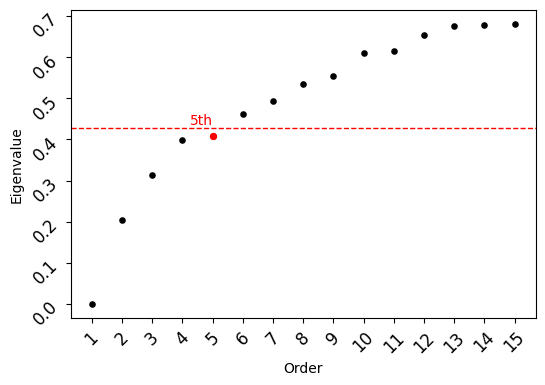

In [38]:
affinity_RNA = snf.make_affinity(aggregated.drop(columns=['Donor']),
                                metric = metric, K = dim, mu = .5, normalize = True)

n_clusters = 5
plotting.eigengap_visual(affinity_RNA, [n_clusters], res_dir)

clus_labels_RNA = utils.spectral_clustering_custom(affinity_RNA, n_clusters)
clus_labels_RNA = ['RNAseq ' + x[:1] + ' ' + str(int(x[-1])+1) for x in clus_labels_RNA]

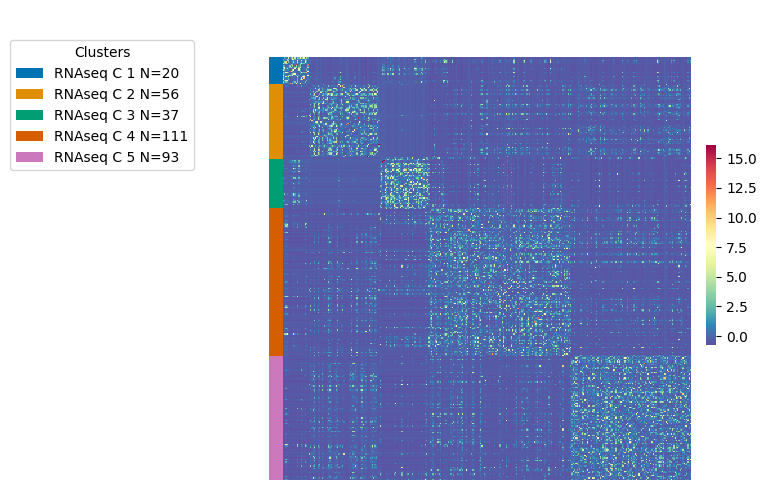

In [39]:
plotting.draw_clustermap(clus_labels_RNA, affinity_RNA, res_dir, 'standard')

# Save the unimodal clusters for further use
pd.DataFrame({
    'Donor': aggregated['Donor'],
    'labels_RNA': clus_labels_RNA
}).to_csv(chord_dir + 'RNA_clusters.csv', sep='\t')

## Stability analysis

Run 0:
Silhouette score: 0.5249853330764694
Silhouette score: 0.5432349158936108
Silhouette score: 0.5299029073659696
Silhouette score: 0.5276715482438644
Silhouette score: 0.5453375076091103


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:760: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cooccurrence = pd.concat([cooccurrence, one_hot.reset_index()]).groupby('Donor',as_index=False).sum()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:760: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cooccurrence = pd.concat([cooccurrence, one_hot.reset_index()]).groupby('Donor',as_index=False).sum()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/mo

Silhouette score: 0.5407893554577939
Silhouette score: 0.5298869963246523
Silhouette score: 0.5498300216807384
Silhouette score: 0.5574036071534729
Silhouette score: 0.5547536384579789
Run 1:
Silhouette score: 0.5540460453048957


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:760: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cooccurrence = pd.concat([cooccurrence, one_hot.reset_index()]).groupby('Donor',as_index=False).sum()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:760: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cooccurrence = pd.concat([cooccurrence, one_hot.reset_index()]).groupby('Donor',as_index=False).sum()
/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/mo

Silhouette score: 0.5537151561972686
Silhouette score: 0.5296358224434193
Silhouette score: 0.5705055814081164
Silhouette score: 0.5223674335267757
Silhouette score: 0.516507284648244
Silhouette score: 0.5197991766175211
Silhouette score: 0.5472334851873637
Silhouette score: 0.541930886567052
Silhouette score: 0.5502533407345659
Run 2:
Silhouette score: 0.5417933783807016
Silhouette score: 0.5311671460044188
Silhouette score: 0.5145230360800542
Silhouette score: 0.5402090914160498
Silhouette score: 0.5635160895708298
Silhouette score: 0.5400472073308171
Silhouette score: 0.5462073583183096
Silhouette score: 0.49130234046134724
Silhouette score: 0.5360678650991006
Silhouette score: 0.5551567297423958
Run 3:
Silhouette score: 0.5292854187281231
Silhouette score: 0.5591025359209232
Silhouette score: 0.5438333503999953
Silhouette score: 0.5160147789040934
Silhouette score: 0.5318743163344659
Silhouette score: 0.5390447459219313
Silhouette score: 0.5712800881210143
Silhouette score: 0.52455

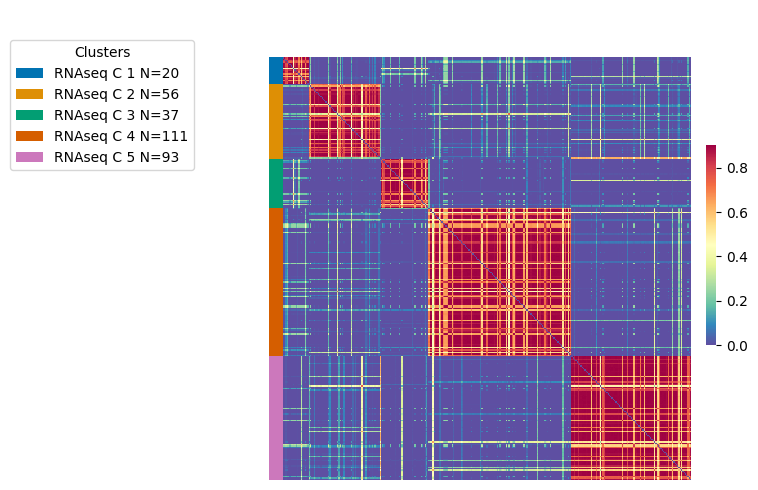

In [40]:
cooccurrence = utils.stability_analysis(aggregated, aggregated['Donor'], metric, dim, n_clusters, 1000, 10)

plotting.draw_clustermap(clus_labels_RNA, (cooccurrence).to_numpy(), res_dir, 'no', plot_name = 'Co-occurrence_clustermap.png')


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/plotting.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stability_df['SortedCombination'] = stability_df.apply(lambda row: ''.join(sorted([row['Subjectnr'], row['Donor']])), axis=1)


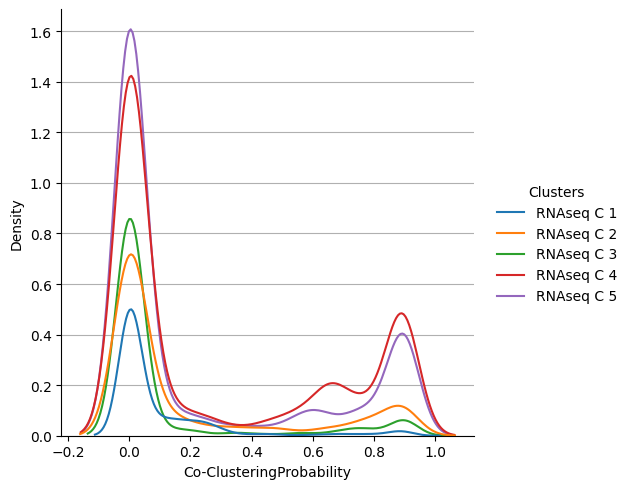

In [41]:
stability_df = cooccurrence.unstack().reset_index()
plotting.plot_coclustering_probability(stability_df, aggregated, clus_labels_RNA, res_dir)

Silhouette score: 0.9596230794341315


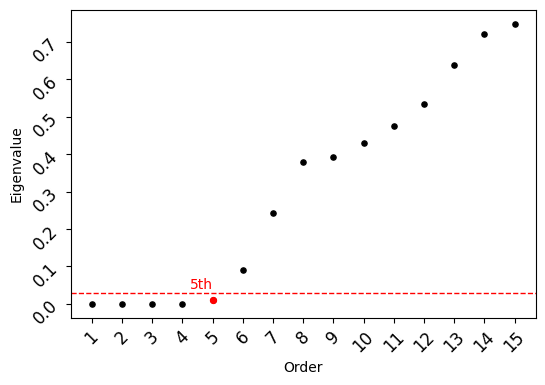

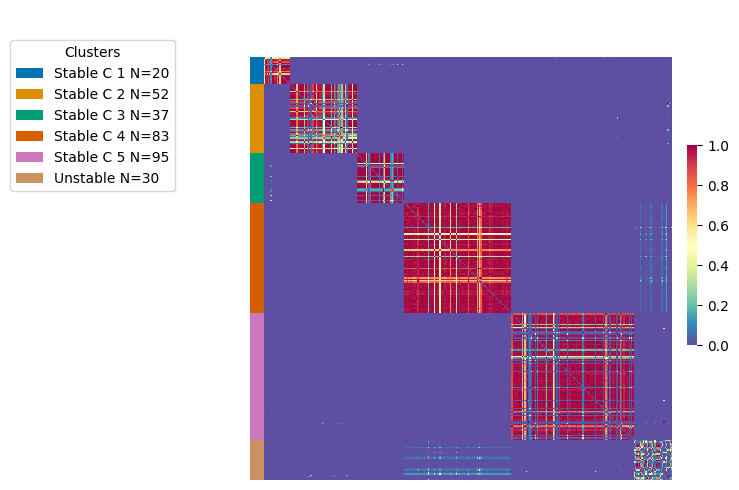

In [42]:
affinity = snf.make_affinity(cooccurrence, metric = metric, K = dim, mu = .5, normalize = True)
plotting.eigengap_visual(affinity, [5], res_dir, 'eigengap_visual_stability.png')
clus_labels = utils.spectral_clustering_custom(affinity, n_clusters+1)
clus_labels.replace({'C 0': 'Stable C 1', 'C 1': 'Unstable', 'C 2': 'Stable C 3', 'C 3':
    'Stable C 2', 'C 4': 'Stable C 5', 'C 5': 'Stable C 4'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity, res_dir, 'minmax', plot_name = 'Outlier_clustermap.png')

In [43]:
sample_silhouette_values = metrics.silhouette_samples(cooccurrence, clus_labels)
means_lst = []
for label in sorted(clus_labels.unique()):
    print(f'Cluster {label}, average silhouette {sample_silhouette_values[clus_labels == label].mean()}')

Cluster Stable C 1, average silhouette 0.6524980167698733
Cluster Stable C 2, average silhouette 0.7731608147166698
Cluster Stable C 3, average silhouette 0.7088944733998688
Cluster Stable C 4, average silhouette 0.5909709298502723
Cluster Stable C 5, average silhouette 0.7464384845788291
Cluster Unstable, average silhouette 0.12416908486916339


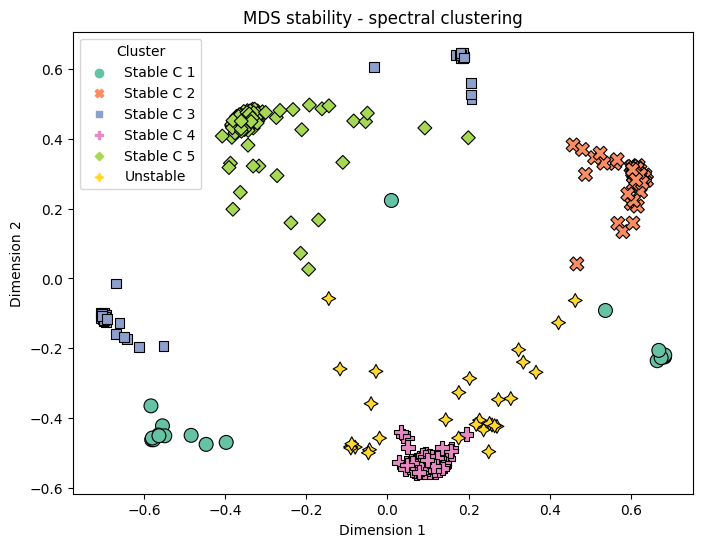

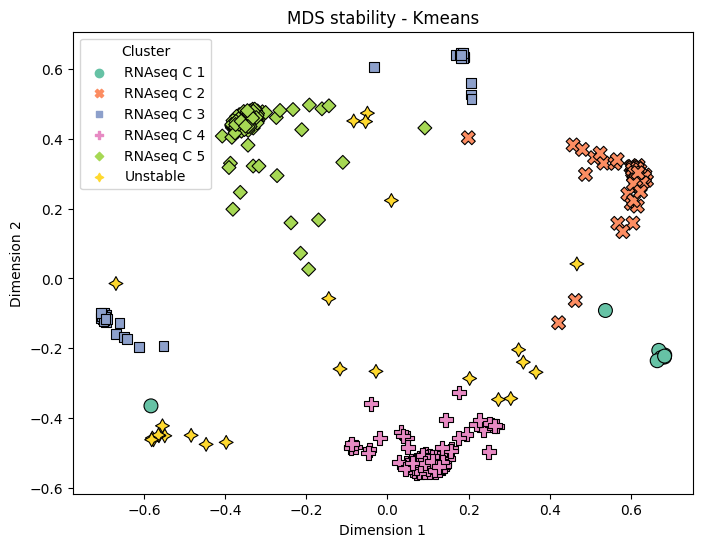

In [44]:
plotting.plot_mds_projection_cooccurrence(cooccurrence, clus_labels, clus_labels_RNA, res_dir)

In [45]:
# Save labels for chord plot
chord = pd.DataFrame({
    'to': clus_labels_RNA,
    'from': list(clus_labels)
})
chord = chord.groupby(['from', 'to']).size()
chord = chord.to_frame(name = 'value').reset_index()
chord.to_csv(chord_dir+'RNA_chord.csv', sep='\t')
chord

from          to  value
0  Stable C 1  RNAseq C 1     20
1  Stable C 2  RNAseq C 2     52
2  Stable C 3  RNAseq C 3     37
3  Stable C 4  RNAseq C 4     83
4  Stable C 5  RNAseq C 2      2
5  Stable C 5  RNAseq C 5     93
6    Unstable  RNAseq C 2      2
7    Unstable  RNAseq C 4     28

## Logistic Regressions on clusters

Size of metadata: (317, 393)
Size of metadata after NaNs removal: (288, 391)
Shape of the regression input: (288, 8)
RNAseq C 1
Optimization terminated successfully.
         Current function value: 0.216650
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  288
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.1088
Time:                        15:53:17   Log-Likelihood:                -62.395
converged:                       True   LL-Null:                       -70.011
Covariance Type:            nonrobust   LLR p-value:                   0.05480
                             coef    std err          z      P>|z|  

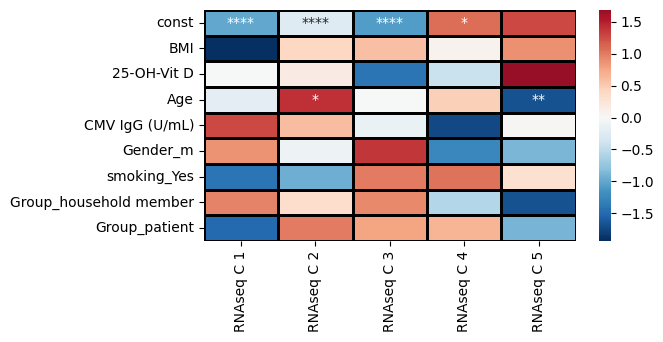

In [46]:
network = []
clus, parameters, pvalues = utils.lr_custom(aggregated, patients, clus_labels_RNA, res_dir)

# Add significant results to network visualisation
network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## GSEA

In [47]:
gsea_res = utils.gsea_analysis(normalized_counts, clus_labels_RNA, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]

plotting.draw_network(network, clus_labels_RNA, res_dir)


2024-09-24 15:53:18,092 [WARNING] Found duplicated gene names, values averaged by gene names!
2024-09-24 15:53:22,068 [WARNING] Found duplicated gene names, values averaged by gene names!
2024-09-24 15:53:25,710 [WARNING] Found duplicated gene names, values averaged by gene names!
2024-09-24 15:53:29,154 [WARNING] Found duplicated gene names, values averaged by gene names!
2024-09-24 15:53:32,750 [WARNING] Found duplicated gene names, values averaged by gene names!


<class 'pyvis.network.Network'> |N|=45 |E|=59

# TCR unimodal

In [48]:
res_dir = results_dir + 'TCR_unimodal_modules/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = module_counts_tcr.shape[0]//10

Silhouette score: 0.2448084474015521


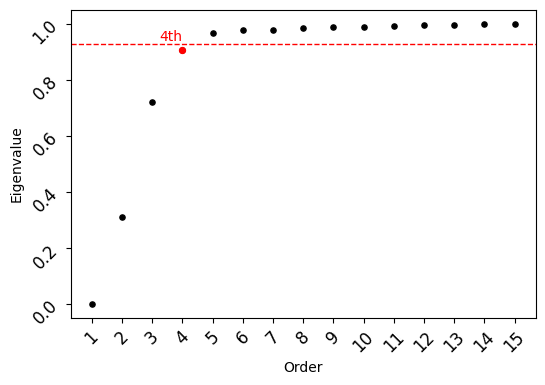

In [49]:
affinity_tcr = snf.make_affinity(module_counts_tcr.drop(columns = ['Donor']), 
                                        metric = 'braycurtis', K = dim, mu = .5, normalize = True)


n_clusters = 4
plotting.eigengap_visual(affinity_tcr, [n_clusters], res_dir)
clus_labels_tcr = utils.spectral_clustering_custom(affinity_tcr, n_clusters)
clus_labels_tcr =  pd.Series(['TCR ' + x[:1] + ' ' + str(int(x[-1])+1) for x in clus_labels_tcr])

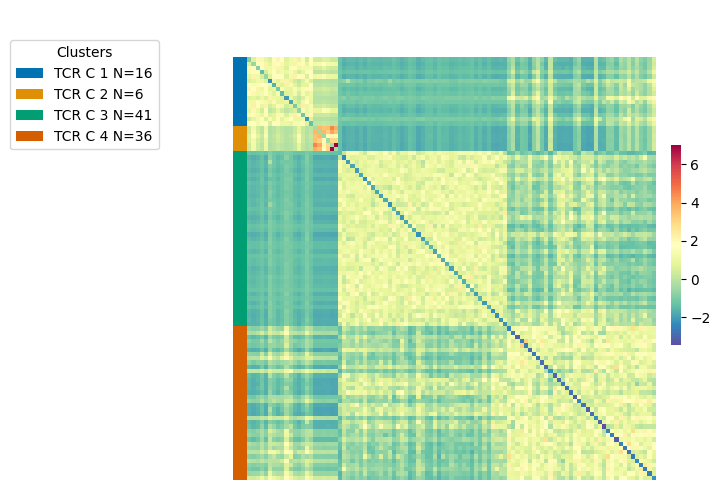

In [50]:
plotting.draw_clustermap(clus_labels_tcr, affinity_tcr, res_dir, 'standard')

# Save the unimodal clusters for further use
pd.DataFrame({
    'Donor': module_counts_tcr['Donor'],
    'labels_TCR': clus_labels_tcr
}).to_csv(chord_dir + 'TCR_clusters.csv', sep='\t')

## Logistic Regression on clusters

Size of metadata: (89, 1009)
Size of metadata after NaNs removal: (85, 1007)
Shape of the regression input: (85, 8)
TCR C 1
Optimization terminated successfully.
         Current function value: 0.389720
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   85
Model:                          Logit   Df Residuals:                       76
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.1289
Time:                        15:53:38   Log-Likelihood:                -33.126
converged:                       True   LL-Null:                       -38.028
Covariance Type:            nonrobust   LLR p-value:                    0.2790
                             coef    std err          z      P>|z|      

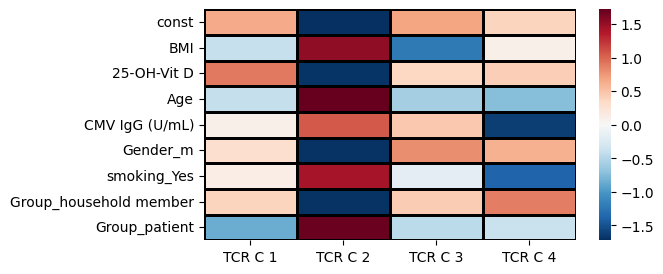

In [51]:
network = []
clus, parameters, pvalues = utils.lr_custom(module_counts_tcr, meta, clus_labels_tcr, res_dir)

# Add significant results to network visualisation
network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## TCR statistics test

   mann_pvalues          features  cluster
0  3.797200e-03        entropyCD4  TCR C 1
1  5.088320e-01        entropyCD8  TCR C 1
2  4.565860e-02  tcrcovidmatchCD4  TCR C 1
3  6.359481e-03  tcrcovidmatchCD8  TCR C 1
4  2.962813e-03   tcrcovidfreqCD4  TCR C 1
5  8.929562e-04   tcrcovidfreqCD8  TCR C 1
0  4.066721e-03        entropyCD4  TCR C 2
1  4.168302e-01        entropyCD8  TCR C 2
2  2.298240e-02  tcrcovidmatchCD4  TCR C 2
3  4.152212e-02  tcrcovidmatchCD8  TCR C 2
4  1.441742e-03   tcrcovidfreqCD4  TCR C 2
5  6.573656e-03   tcrcovidfreqCD8  TCR C 2
0  1.252662e-02        entropyCD4  TCR C 3
1  3.881258e-03        entropyCD8  TCR C 3
2  6.089106e-06  tcrcovidmatchCD4  TCR C 3
3  8.375831e-03  tcrcovidmatchCD8  TCR C 3
4  6.860847e-07   tcrcovidfreqCD4  TCR C 3
5  7.218002e-03   tcrcovidfreqCD8  TCR C 3
0  3.102426e-01        entropyCD4  TCR C 4
1  4.205901e-03        entropyCD8  TCR C 4
2  4.915197e-02  tcrcovidmatchCD4  TCR C 4
3  6.896877e-01  tcrcovidmatchCD8  TCR C 4
4  2.214427

<class 'pyvis.network.Network'> |N|=10 |E|=13

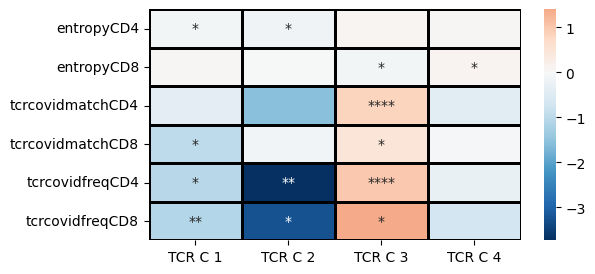

In [52]:
res = plotting.mann_sign([(TCR_stats.drop(columns = ['Donor']), 'TCR')], clus_labels_tcr, res_dir)

for r in res:
    network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

plotting.draw_network(network, clus_labels_tcr, res_dir)

In [53]:
# save TCR results for bubble plot
res[0][0].to_csv(bubble_dir + 'TCR_bubbles_pvalues.csv', sep='\t')
res[0][1].to_csv(bubble_dir + 'TCR_bubbles_coefficients.csv', sep='\t')

# Cytof unimodal

In [54]:
res_dir = results_dir + 'Cytof_unimodal/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = cytof.shape[0]//10

Silhouette score: 0.396577681778258


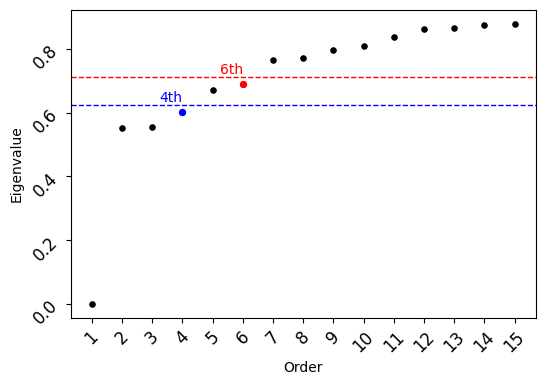

In [55]:
affinity_cytof = snf.make_affinity(cytof, metric = metric, K = dim, mu = .5, normalize = True)
n_clusters = 6

plotting.eigengap_visual(affinity_cytof, [4, n_clusters], res_dir)
clus_labels_cytof = utils.spectral_clustering_custom(affinity_cytof, n_clusters)
clus_labels_cytof.replace({"C 0": "C 1 - LAG3 cluster ",
                        "C 1": "C 2 - Monocyte-driven ",
                        "C 2": "C 3 - CMV seropositive\nsenescent ",
                        "C 3": "C 4 - FAS cluster ",
                        "C 4": "C 5 - Naïve group ",
                        "C 5": "C 6 - Elderly group "}, inplace = True)

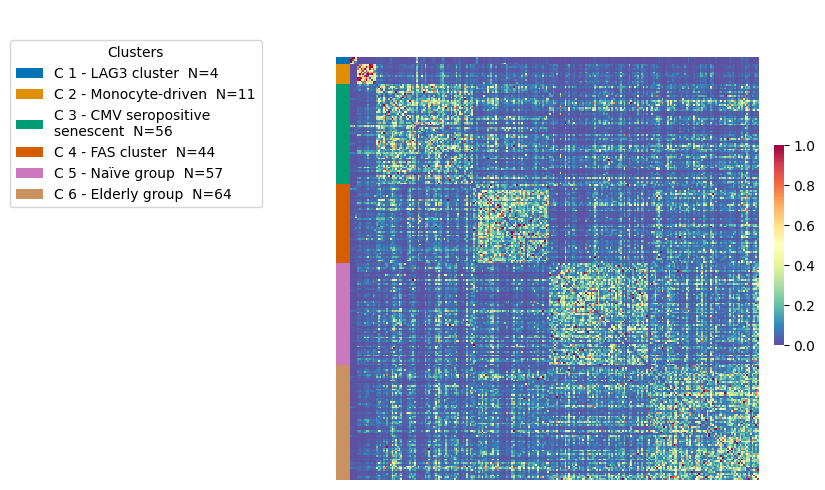

In [56]:
plotting.draw_clustermap(clus_labels_cytof, affinity_cytof, res_dir, 'minmax')

# Save the unimodal clusters for further use
pd.DataFrame({
    'Donor': cytof_meta['Donor'],
    'labels_Cytof': clus_labels_cytof
}).to_csv(chord_dir + 'Cytof_clusters.csv', sep='\t')

## Logistic Regression on clusters

Size of metadata: (233, 32)
Size of metadata after NaNs removal: (217, 30)
Shape of the regression input: (217, 8)
C 1 - LAG3 cluster 
Optimization terminated successfully.
         Current function value: 0.067827
         Iterations: 63
         Function evaluations: 65
         Gradient evaluations: 65
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  217
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.2618
Time:                        15:53:41   Log-Likelihood:                -14.718
converged:                       True   LL-Null:                       -19.937
Covariance Type:            nonrobust   LLR p-value:                    0.2356
                             coef    std err          z      

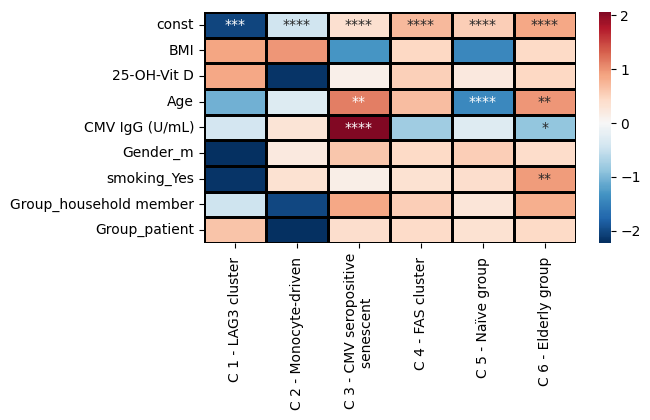

In [57]:
network = []
clus, parameters, pvalues = utils.lr_custom(cytof_meta, meta, clus_labels_cytof, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## Cytof clusters analysis

Cytof number of columns 22
No need to drop Donor


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values[col][i] = convert_pvalue_to_asterisks(values[col][i])


<class 'pyvis.network.Network'> |N|=30 |E|=69

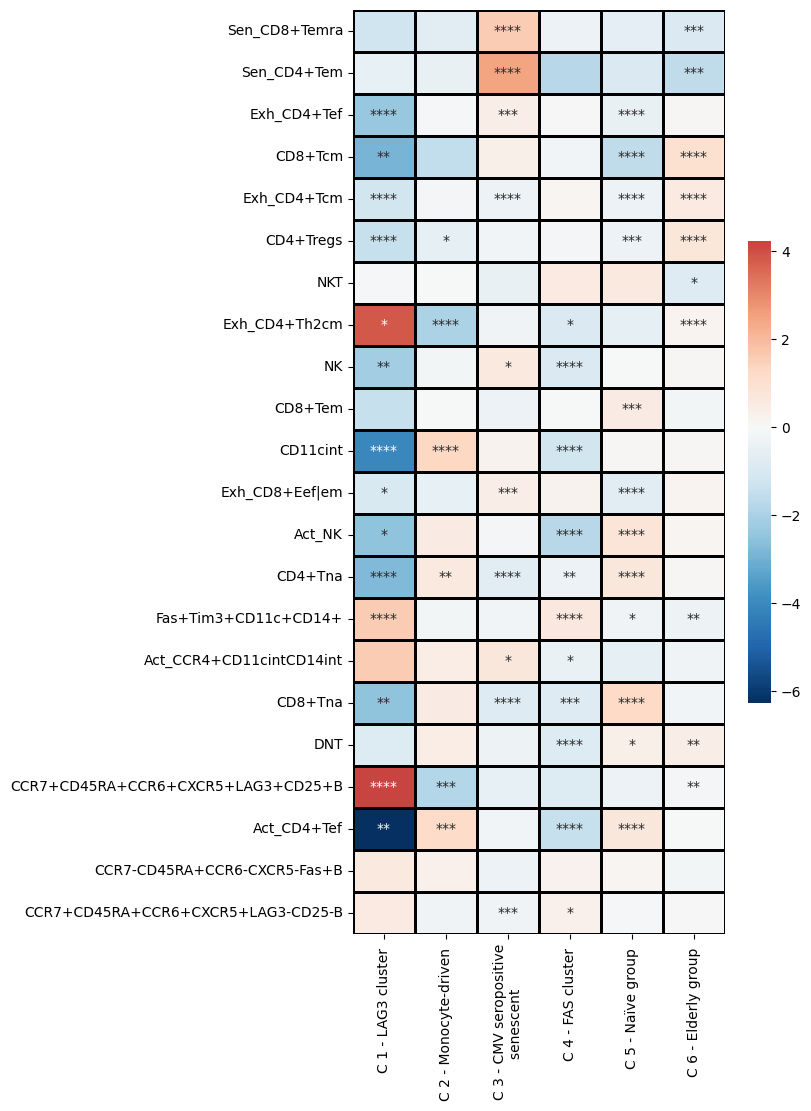

In [58]:
r = utils.cytof_clusters_analysis(cytof_meta.drop(columns='Donor'), clus_labels_cytof, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

plotting.draw_network(network, clus_labels_cytof, res_dir)

# Microbiome unimodal

In [59]:
res_dir = results_dir + 'Microbiome_unimodal/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = microbiome_encoded.shape[0]//10

Silhouette score: 0.22924812545626516


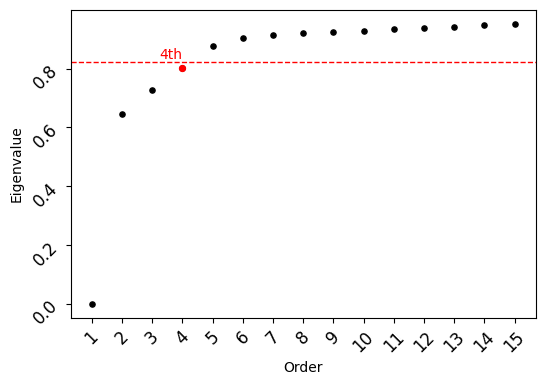

In [60]:
affinity_microbe = snf.make_affinity(microbiome_encoded, metric = 'braycurtis', K = dim, 
                                      mu = .5, normalize = True)

n_clusters = 4
plotting.eigengap_visual(affinity_microbe, [n_clusters], res_dir)
clus_labels_micro = utils.spectral_clustering_custom(affinity_microbe, n_clusters)
clus_labels_micro.replace({"C 0": "Prevotella-driven\nHigh BMI",
                        "C 1": "Bacteroidaceae driven",
                        "C 2": "Ruminococcaceae &\nChristensenellaceae\ndriven Low BMI",
                        "C 3": "Lachnospiraceae-driven"}, inplace = True)

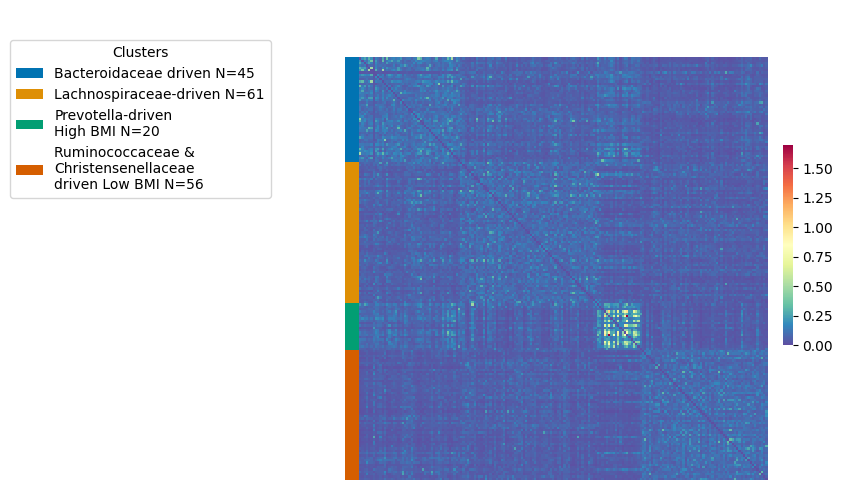

In [61]:
plotting.draw_clustermap(clus_labels_micro, affinity_microbe, res_dir, 'no')

# Save the unimodal clusters for further use
pd.DataFrame({
    'Donor': micro_fused_rel['Donor'],
    'labels_Micro': clus_labels_micro
}).to_csv(chord_dir + 'Micro_clusters.csv', sep='\t')

### Save data for further visualisations

In [62]:
temp_micro = pd.DataFrame({
    'Donor': micro_fused_rel['Donor'],
    'to': clus_labels_micro
})
temp_cytof = pd.DataFrame({
    'Donor': cytof_meta['Donor'],
    'from': clus_labels_cytof
})

pd.merge(temp_micro, temp_cytof, on = 'Donor', how = 'inner')[['Donor', 'to', 'from']].to_csv(processed_dir+'randindexpermu.csv', sep='\t')

micro_fused_rel.drop(columns=['Donor']).to_csv(processed_dir + 'microbial_unimodal_adonis.csv')

pd.DataFrame({
    'Donor': micro_fused['Donor'],
    'labels': clus_labels_micro
}).to_csv(processed_dir+'adonis_labels.csv')


micro_fused_rel.rename(columns  = {'Donor': 'Taxon'}
                ).set_index('Taxon').T.to_csv(processed_dir + 'relative_abundances_forplot.csv', sep='\t')

     Shannon index  Simpson index  Chao1 richness  \
0         3.746175       0.956193           143.0   
1         3.329423       0.890112           165.0   
2         4.172984       0.971639           166.0   
3         3.535717       0.901752           169.0   
4         3.740529       0.961326           104.0   
..             ...            ...             ...   
177       3.164041       0.888319           129.0   
178       4.081041       0.970314           158.0   
179       3.555622       0.945811           109.0   
180       4.260476       0.973593           189.0   
181       3.890705       0.960746           132.0   

                                               Cluster  
0                               Lachnospiraceae-driven  
1    Ruminococcaceae &\nChristensenellaceae\ndriven...  
2                               Lachnospiraceae-driven  
3    Ruminococcaceae &\nChristensenellaceae\ndriven...  
4                               Lachnospiraceae-driven  
..                   

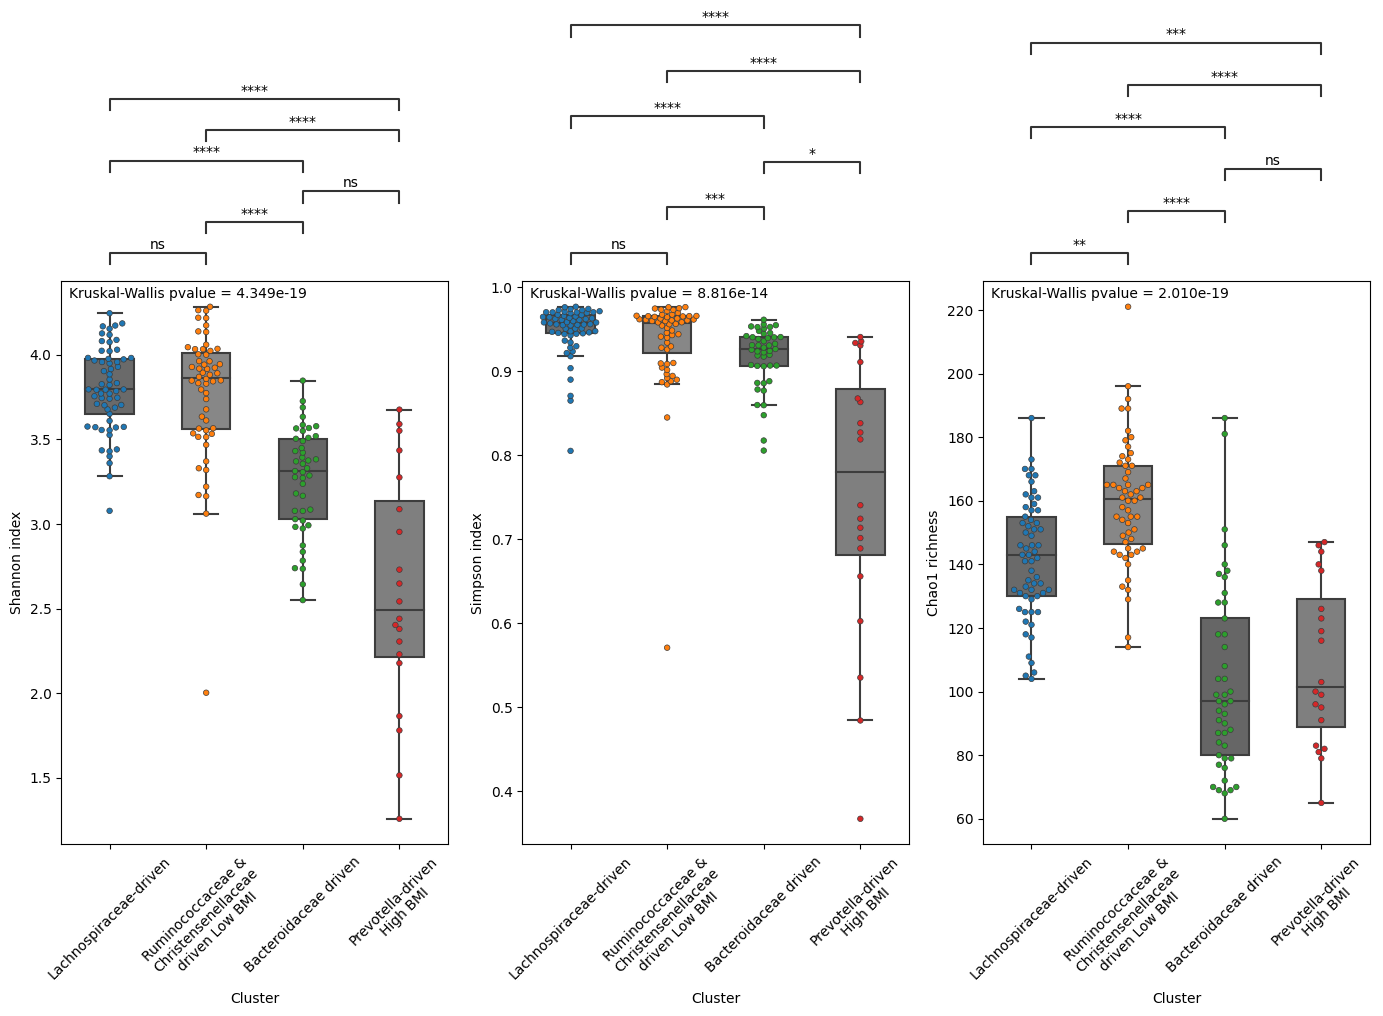

In [63]:
plotting.alpha_diversity_microbiome(micro_fused_rel.drop(columns=['Donor']), micro_fused_rel['Donor'], clus_labels_micro, res_dir)

## Logistic Regression on clusters

In [64]:
clus_labels_micro = clus_labels_micro.str.replace('\n', '_').str.replace(' ', '_')

Size of metadata: (177, 397)
Size of metadata after NaNs removal: (167, 395)
Shape of the regression input: (167, 8)
Bacteroidaceae_driven
Optimization terminated successfully.
         Current function value: 0.552018
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  167
Model:                          Logit   Df Residuals:                      158
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                 0.03224
Time:                        15:53:53   Log-Likelihood:                -92.187
converged:                       True   LL-Null:                       -95.258
Covariance Type:            nonrobust   LLR p-value:                    0.6312
                             coef    std err          z  

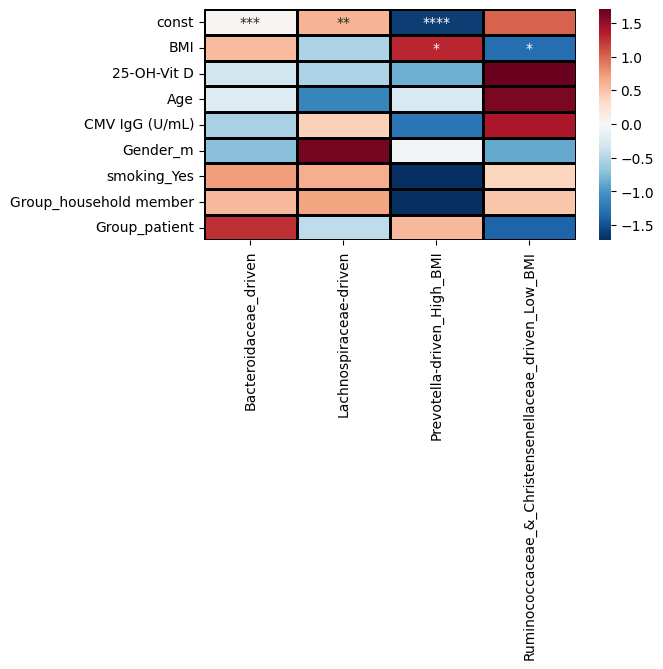

In [65]:
network = []
clus, parameters, pvalues = utils.lr_custom(micro_fused, meta, clus_labels_micro, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## One vs Rest Testing

In [66]:
single_asv_data = micro_data_norm.set_index('taxaname').T
single_asv_data.columns = [list(micro_taxa[micro_taxa['taxon_name'] == taxon]['taxon_id'])[0] for taxon in single_asv_data.columns]
single_asv_data.reset_index(inplace=True)
res = plotting.micro_analysis(single_asv_data, clus_labels_micro, micro_taxa, res_dir)


 

 


Caricamento pacchetto: ‘tidyr’



    expand











Caricamento pacchetto: ‘Matrix’



    expand, pack, unpack



    expand











   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was autom

['Lachnospiraceae-driven', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven', 'Ruminococcaceae_&_Christensenellaceae_driven_Low_BMI', 'Ruminococcaceae_&_Christensenellaceae_driven_Low_BMI', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven', 'Ruminococcaceae_&_Christensenellaceae_driven_Low_BMI', 'Bacteroidaceae_driven', 'Ruminococcaceae_&_Christensenellaceae_driven_Low_BMI', 'Bacteroidaceae_driven', 'Prevotella-driven_High_BMI', 'Bacteroidaceae_driven', 'Prevotella-driven_High_BMI', 'Bacteroidaceae_driven', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Lachnospiraceae-driven', 'Bacteroidaceae_driven', 'Prevotella-driven_High_BMI', 'Lachnospiraceae-driven',

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## GSEA on BACTERIA

Cluster Bacteroidaceae_driven
Cluster Lachnospiraceae-driven
Cluster Prevotella-driven_High_BMI
Cluster Ruminococcaceae_&_Christensenellaceae_driven_Low_BMI
{'source': 'Bacteroidaceae', 'target': 'Bacteroidaceae_driven', 'weight': 0.9971369993337619, 'origin': 'GSEA_bacteria', 'genes': 'Bacteroides 1;Bacteroides 2;Bacteroides 4;Bacteroides 17;Bacteroides 11;Bacteroides 16;Bacteroides 8;Bacteroides 3;Bacteroides 18;Bacteroides 34;Bacteroides 12;Bacteroides 6;Bacteroides 15;Bacteroides 31;Bacteroides 9;Bacteroides 7;Bacteroides 5;Bacteroides 20;Bacteroides 50;Bacteroides 13'}
{'source': 'Lachnospiraceae', 'target': 'Lachnospiraceae-driven', 'weight': 1.202653395799378, 'origin': 'GSEA_bacteria', 'genes': 'HM123979_g 1;Ruminococcus_g4 2;Murimonas 1;Blautia 2;Blautia 3;LLKB_g 2;Blautia 8;Roseburia 1;LLKB_g 1;Lachnospira 5;EF406589_g 1;Blautia 7;Eubacterium_g21 1;Blautia 6;Lachnospiraceae 7;Eisenbergiella 2;AY305316_g 2;Fusicatenibacter 1;Lachnospiraceae 2;Eubacterium_g7 1;Dorea 2;Murimonas

<class 'pyvis.network.Network'> |N|=9 |E|=14

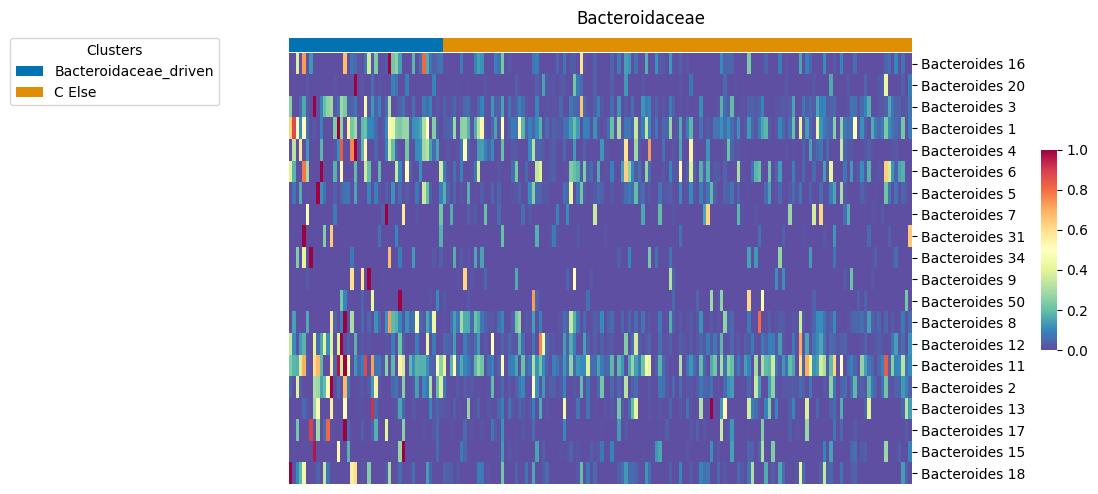

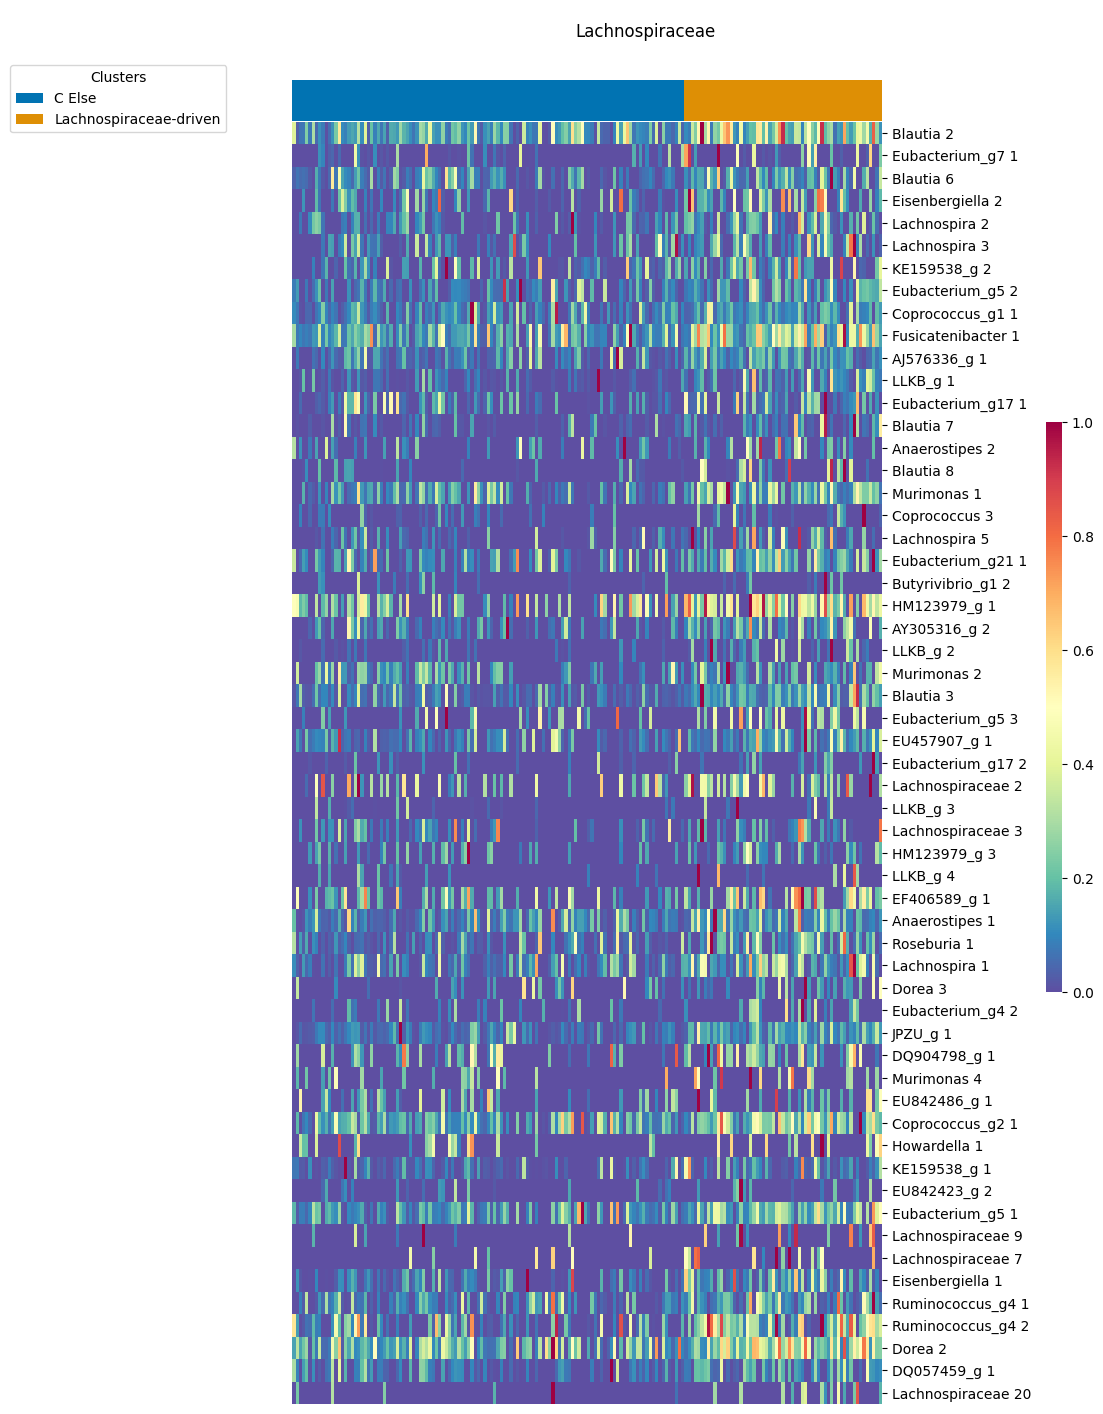

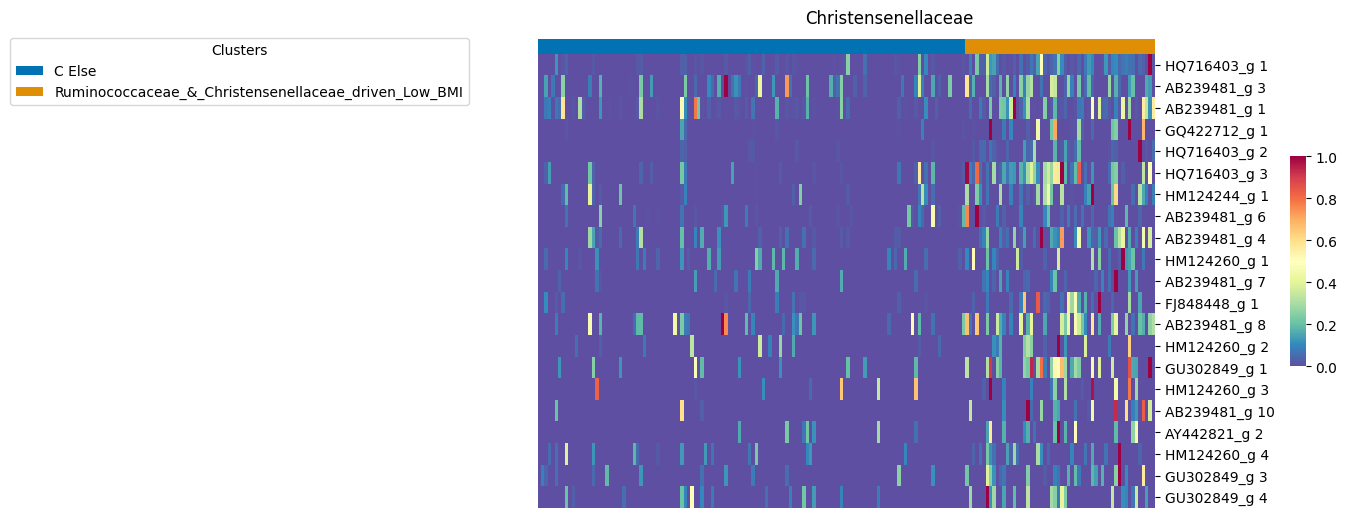

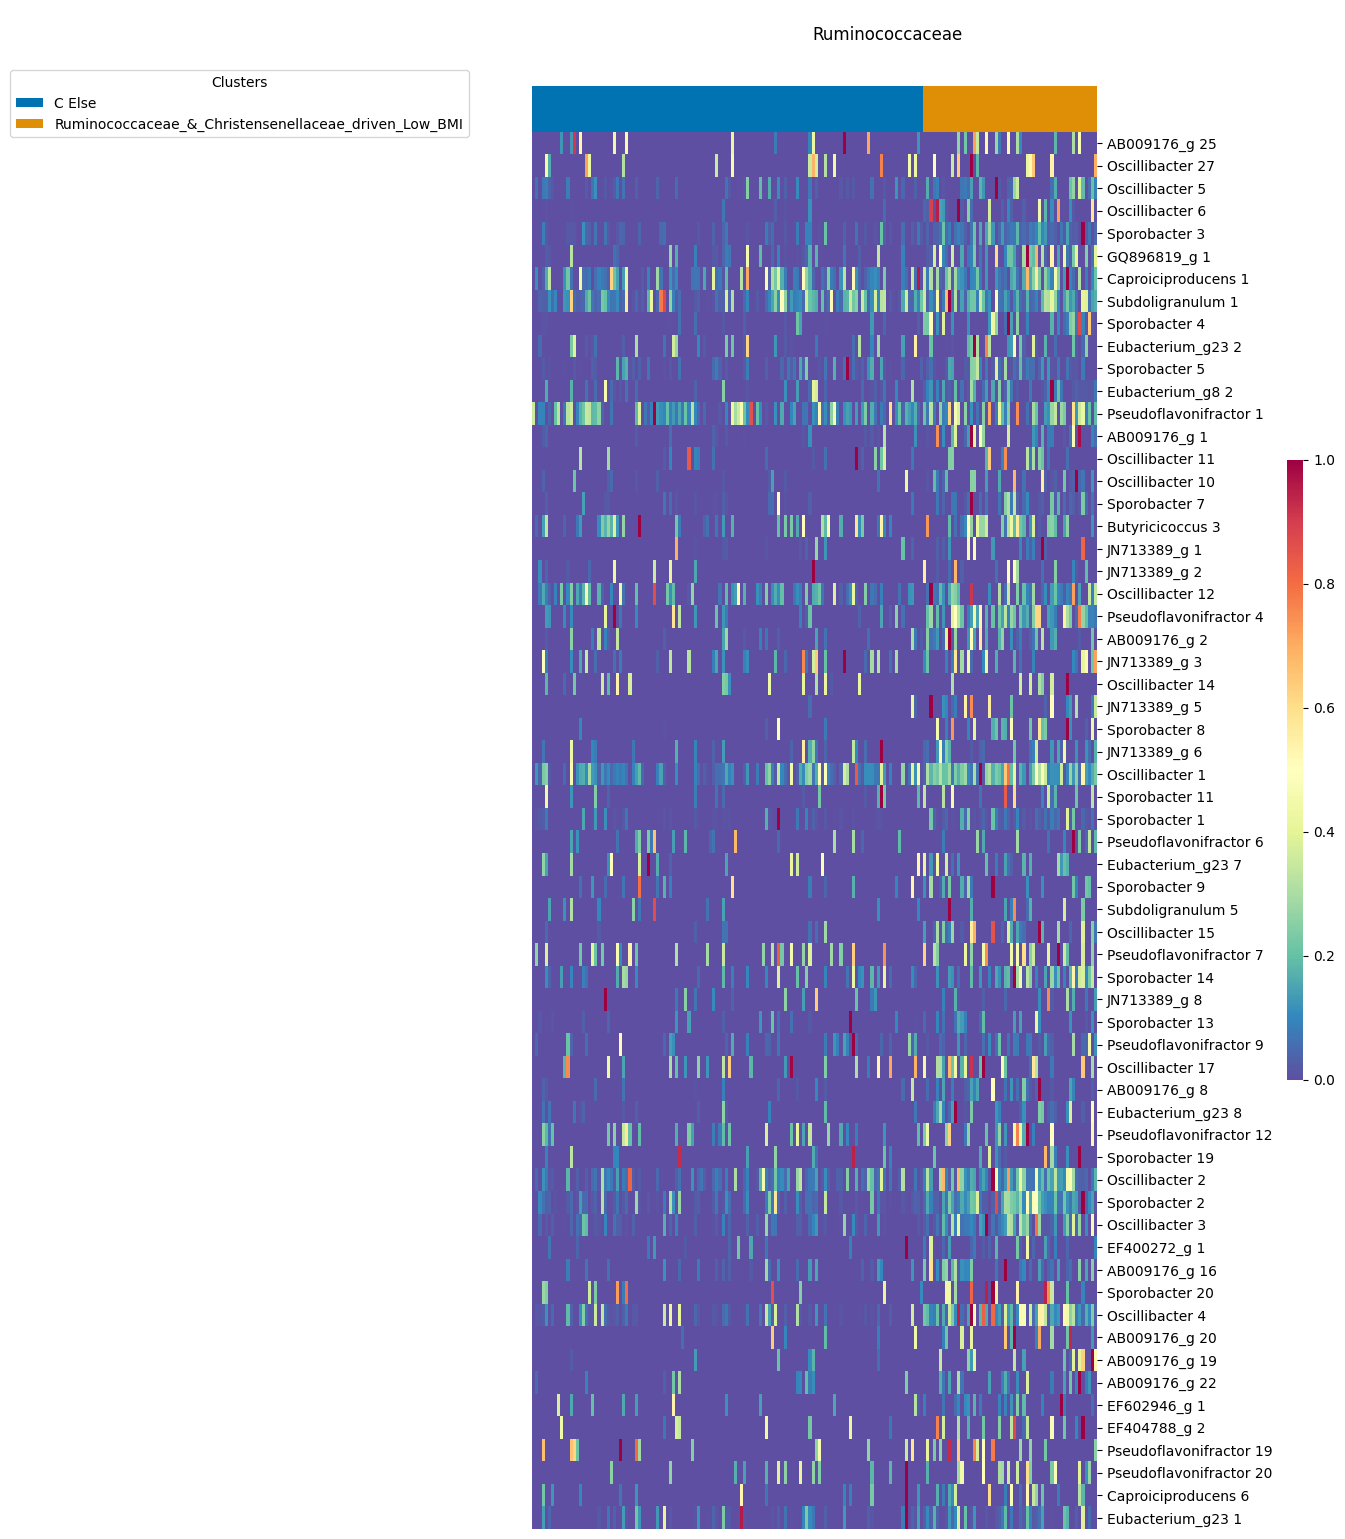

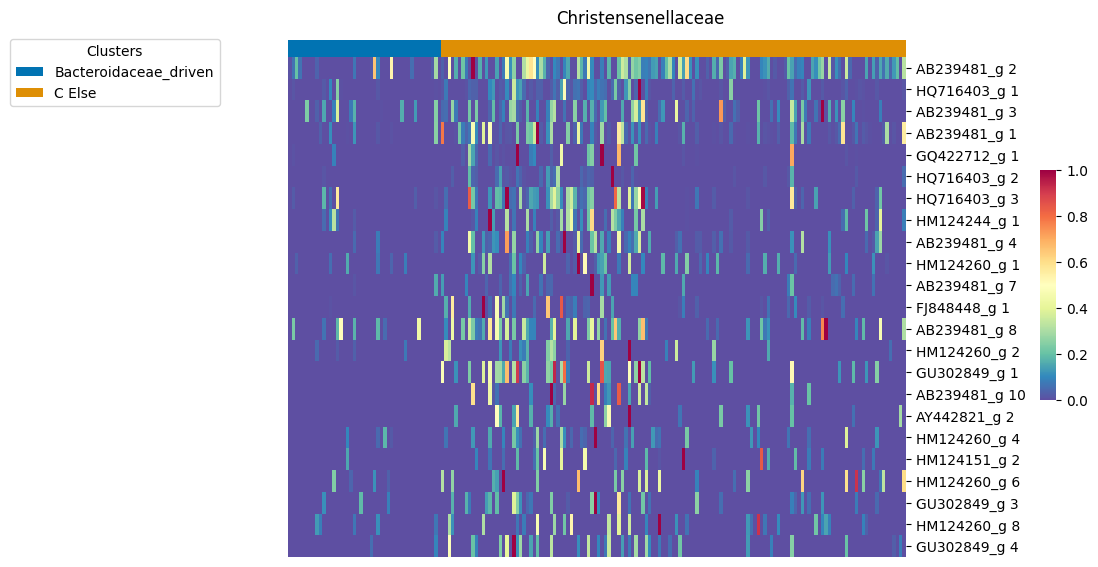

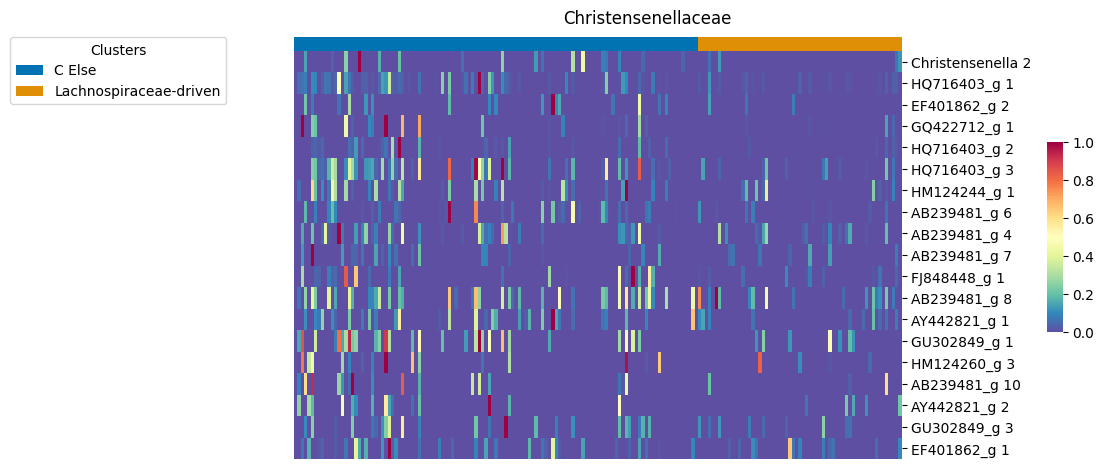

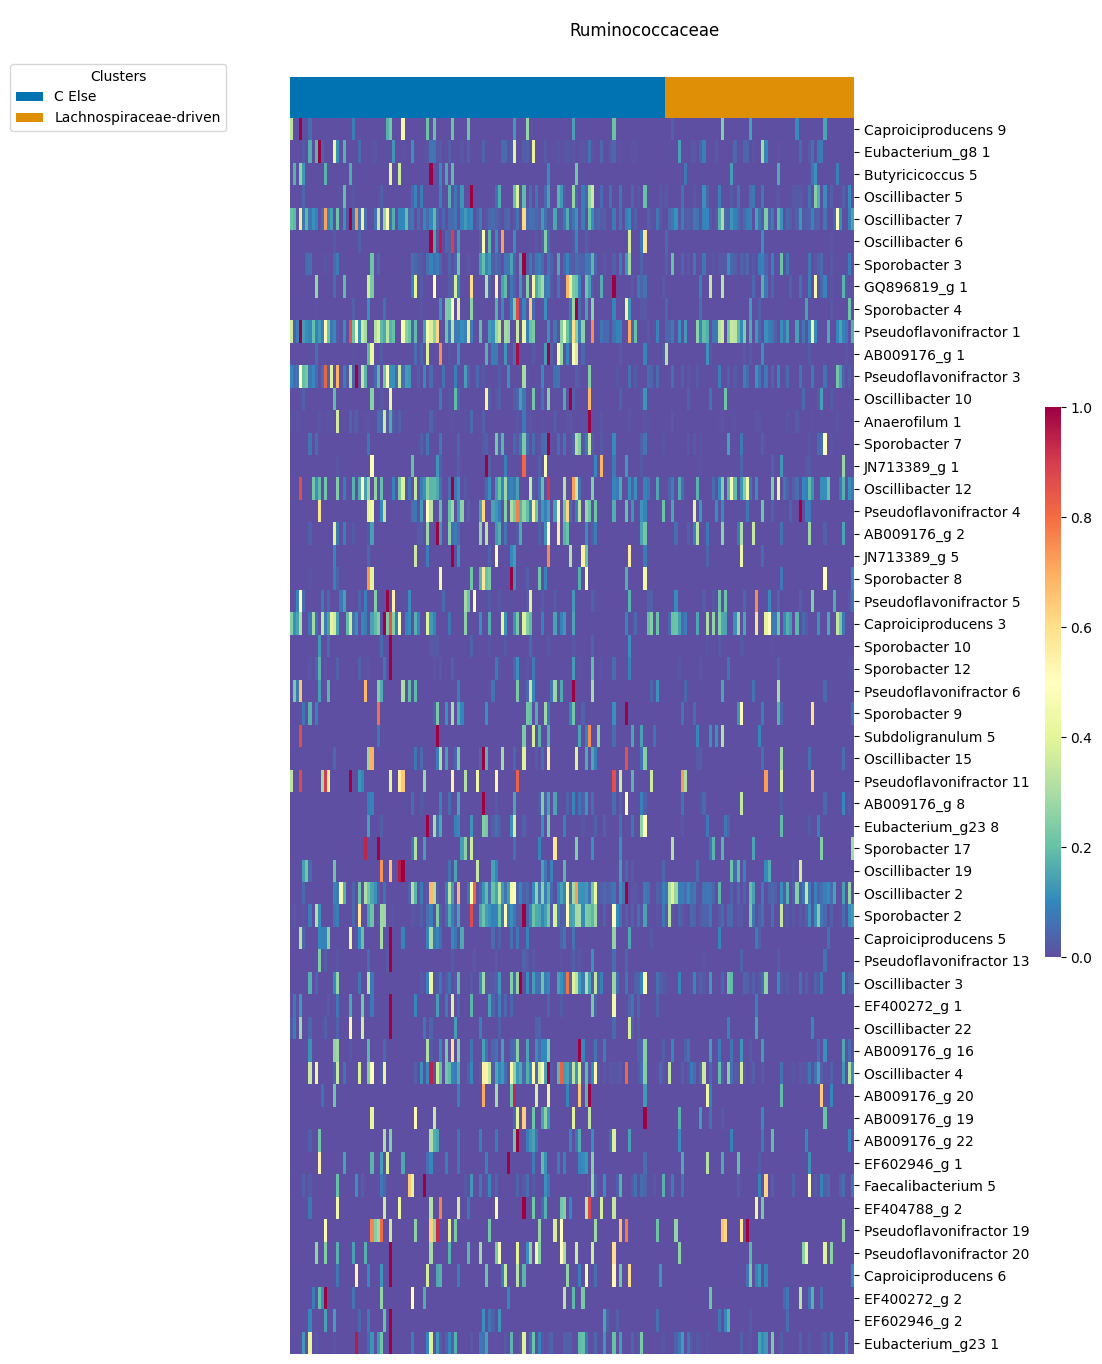

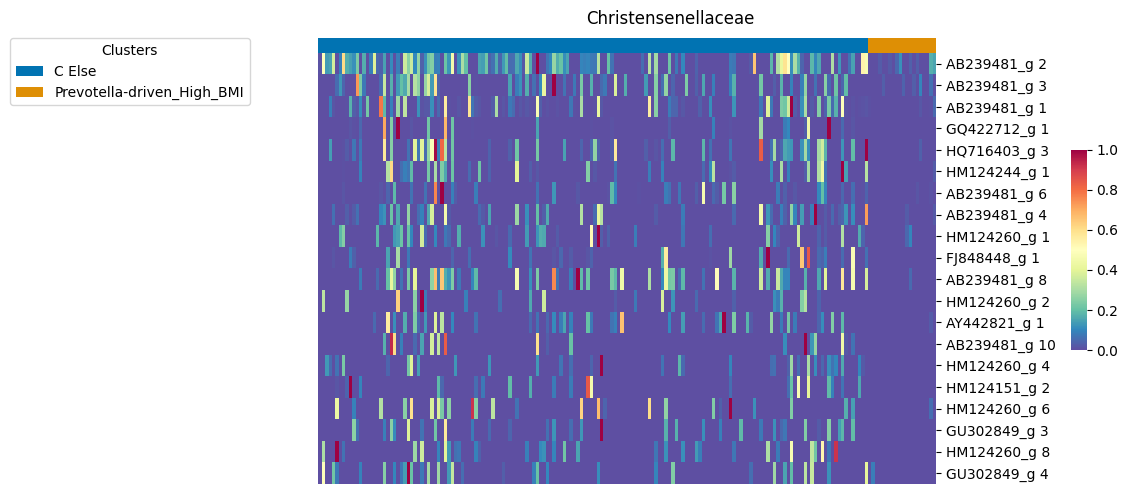

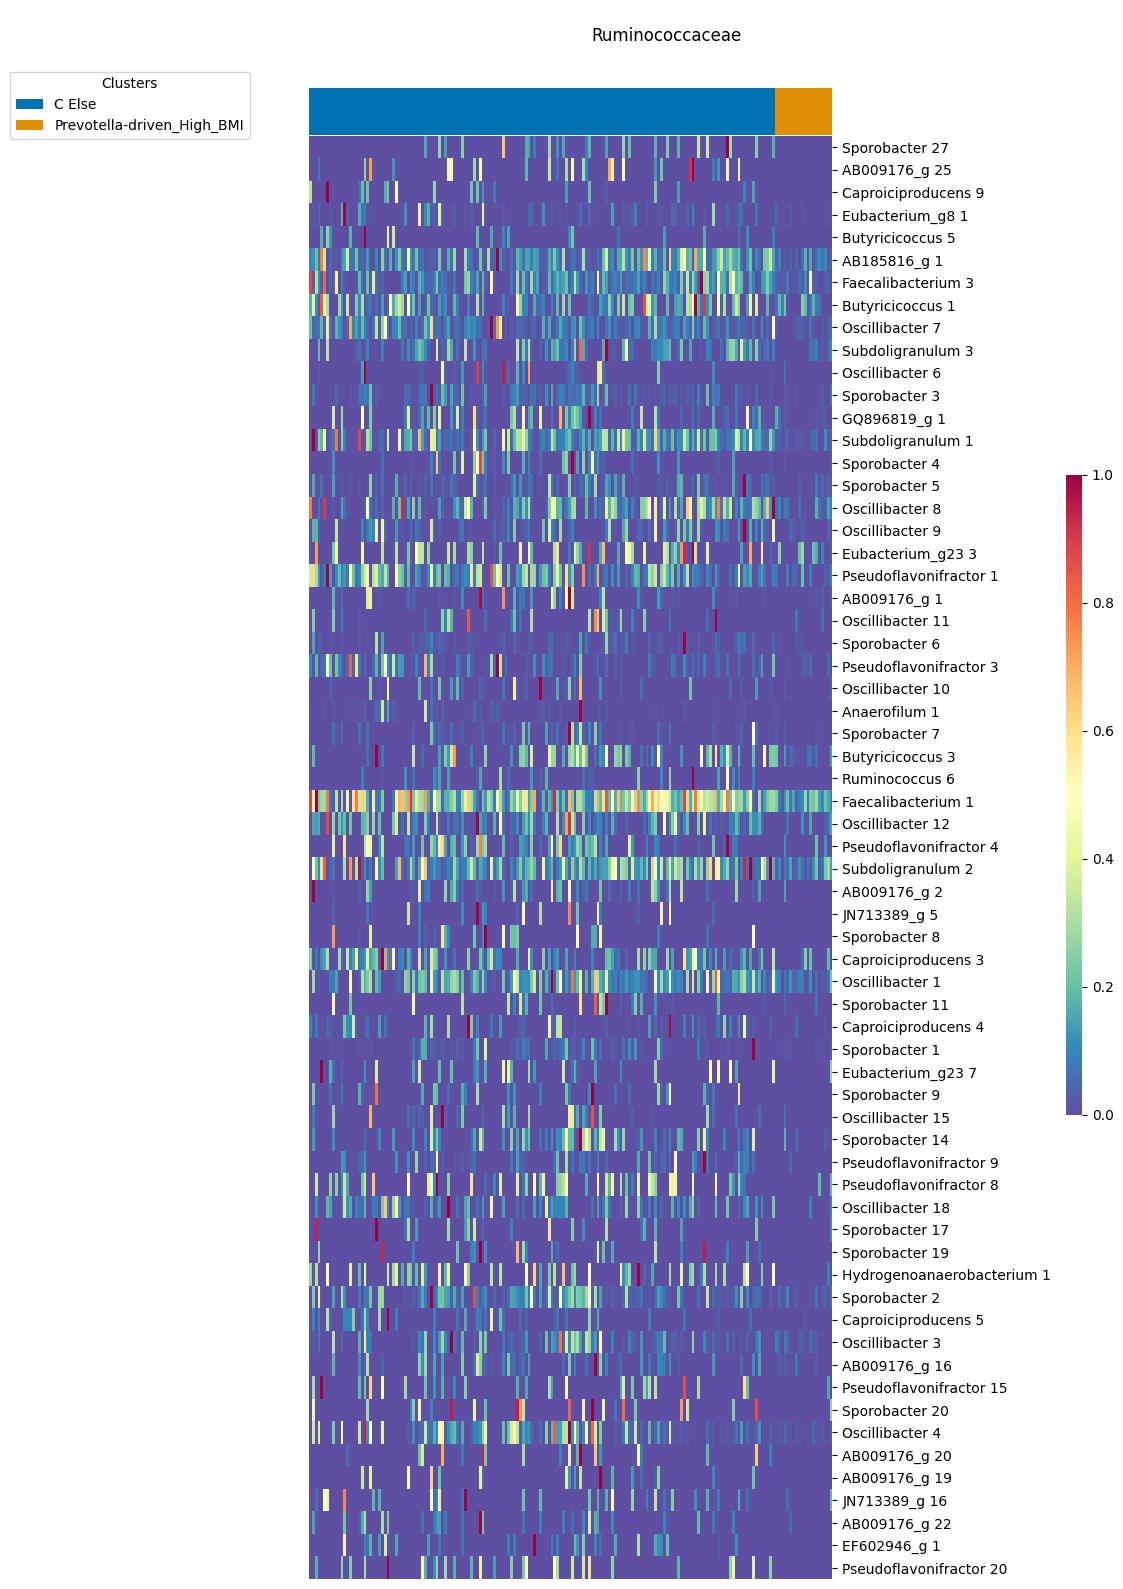

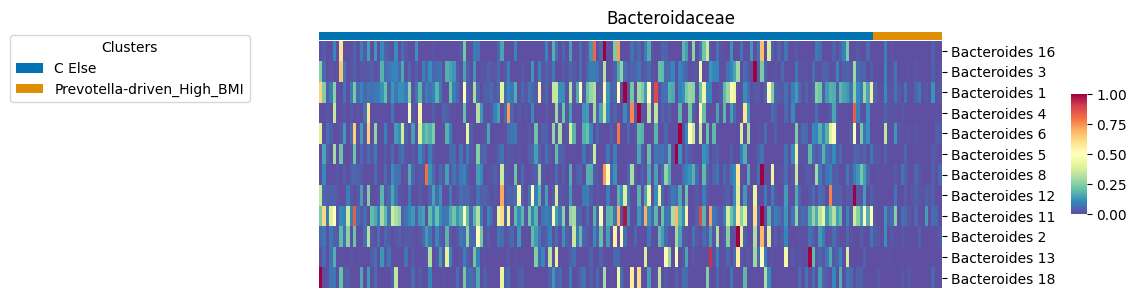

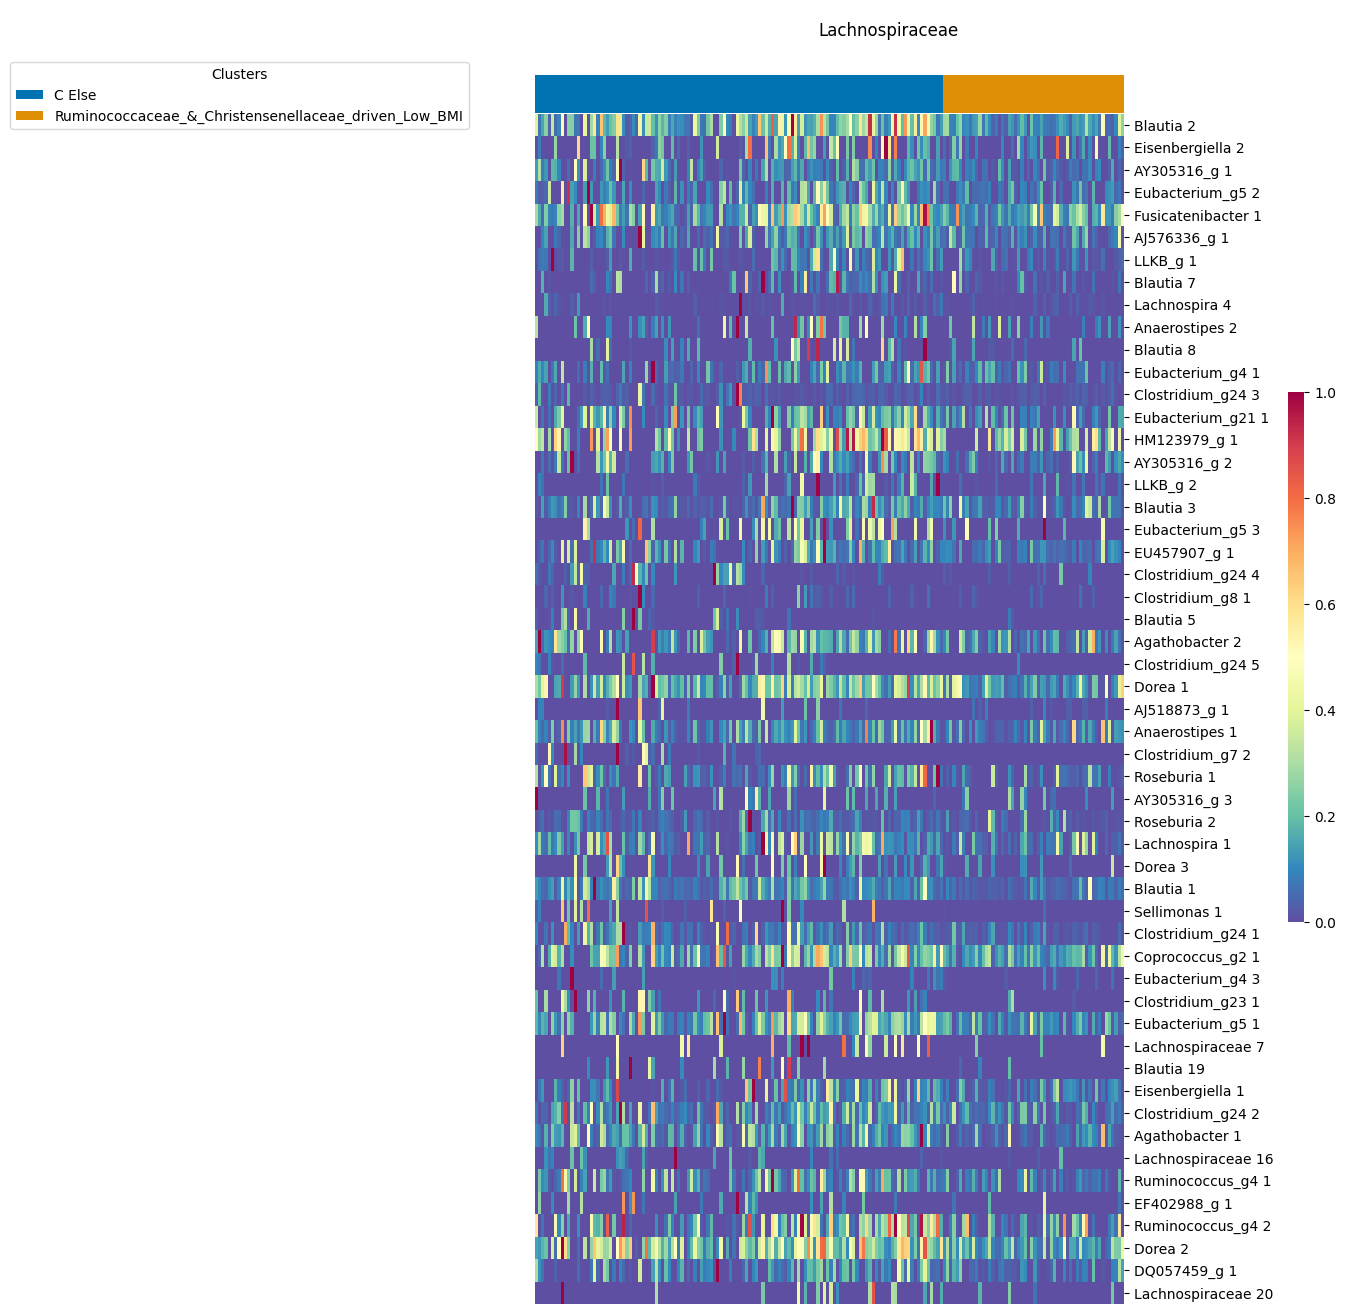

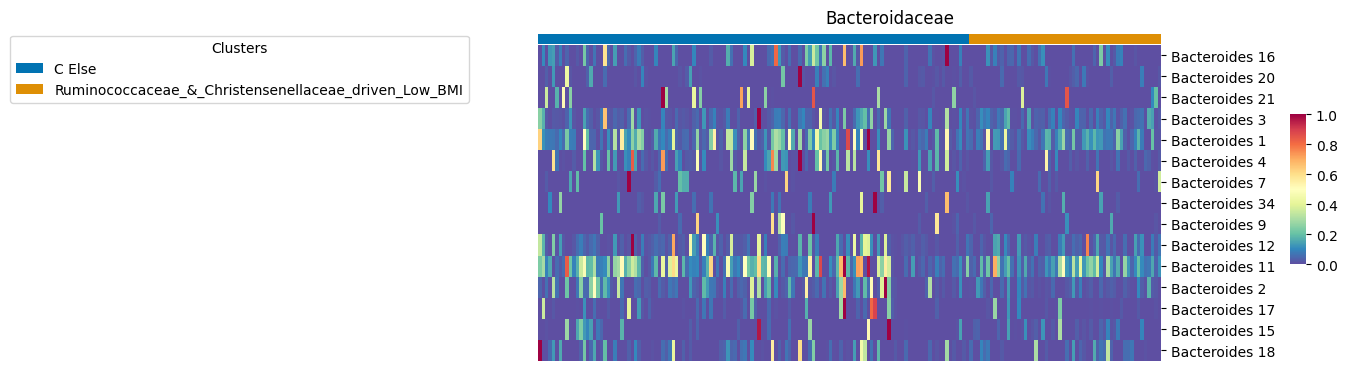

In [67]:
res = utils.gsea_analysis_bacteria(micro_data_norm, clus_labels_micro, bubble_dir, res_dir, [custom_bacteria_gene_lists])

[network.append(element) for element in res]

utils.plot_heatmaps_gsea_bacteria(res, micro_fused_rel, clus_labels_micro, micro_taxa, res_dir)

plotting.draw_network(network, clus_labels_micro, res_dir)

In [68]:
gsea_bacteria_bubble = [el for el in network if el['origin'] == 'GSEA_bacteria']
for el in gsea_bacteria_bubble:
    el['weight']*=2
pd.DataFrame(gsea_bacteria_bubble).to_csv(bubble_dir + 'micro_unimodal_bubbleplot.csv', sep='\t')

# TCRseq RNAseq fusion

In [69]:
RNA_shared = aggregated[aggregated['Donor'].isin(module_counts_tcr['Donor'])]
tcr_shared = module_counts_tcr[module_counts_tcr['Donor'].isin(aggregated['Donor'])]
tcr_shared.reset_index(drop = True, inplace = True)
RNA_shared.reset_index(drop = True, inplace = True)

In [70]:
# RNA
idx = list(set(range(affinity_RNA.shape[0])).difference(list(aggregated[~aggregated['Donor'].isin(module_counts_tcr['Donor'])].index)))
affinity_RNA_mod = affinity_RNA[np.ix_(idx,idx)]
print(affinity_RNA_mod.shape)
# TCR
idx = list(set(range(affinity_tcr.shape[0])).difference(list(module_counts_tcr[~module_counts_tcr['Donor'].isin(aggregated['Donor'])].index)))
affinity_tcr_mod = affinity_tcr[np.ix_(idx,idx)]
print(affinity_tcr_mod.shape)

(86, 86)
(86, 86)


In [71]:
res_dir = results_dir + 'TCR_RNA_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = affinity_RNA_mod.shape[0]//10

Silhouette score: 0.1403376007484052


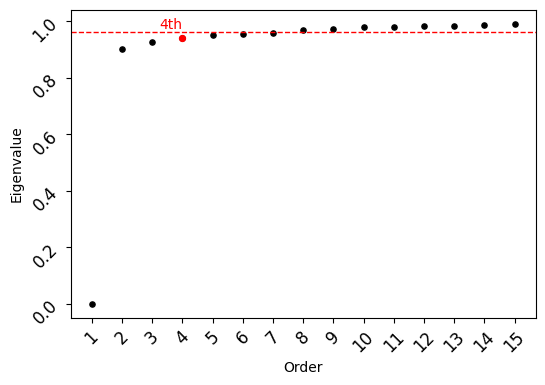

In [72]:
affinity_rna_tcr = snf.snf([affinity_RNA_mod, affinity_tcr_mod], K=dim)

n_clusters = 4
plotting.eigengap_visual(affinity_rna_tcr, [n_clusters], res_dir)
clus_labels = utils.spectral_clustering_custom(affinity_rna_tcr, n_clusters)

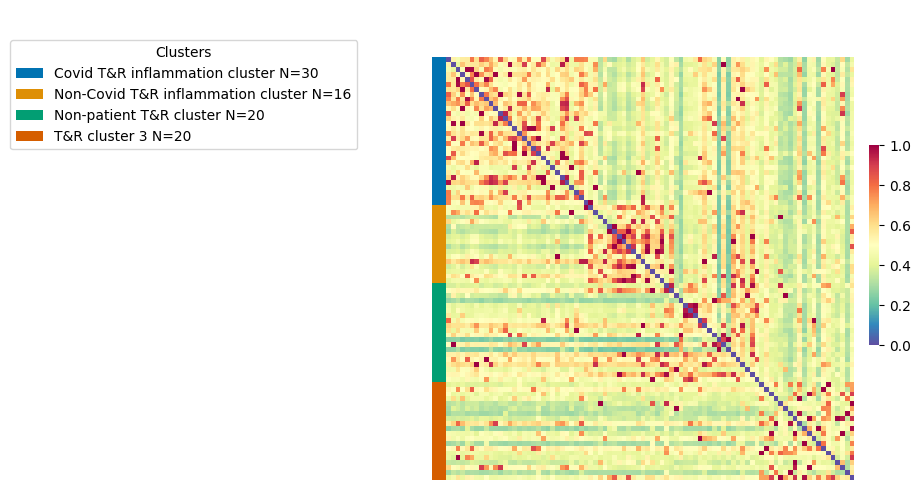

In [73]:
clus_labels.replace({'C 0': 'Non-patient T&R cluster',
                     'C 1': 'Non-Covid T&R inflammation cluster',
                     'C 2': 'T&R cluster 3',
                     'C 3': 'Covid T&R inflammation cluster'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity_rna_tcr, res_dir, 'minmax')

## Logistic Regression on clusters

Size of metadata: (86, 1009)
Size of metadata after NaNs removal: (82, 1007)
Shape of the regression input: (82, 8)
Covid T&R inflammation cluster
Optimization terminated successfully.
         Current function value: 0.598380
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   82
Model:                          Logit   Df Residuals:                       73
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                 0.07896
Time:                        15:03:18   Log-Likelihood:                -49.067
converged:                       True   LL-Null:                       -53.274
Covariance Type:            nonrobust   LLR p-value:                    0.3942
                             coef    std err     

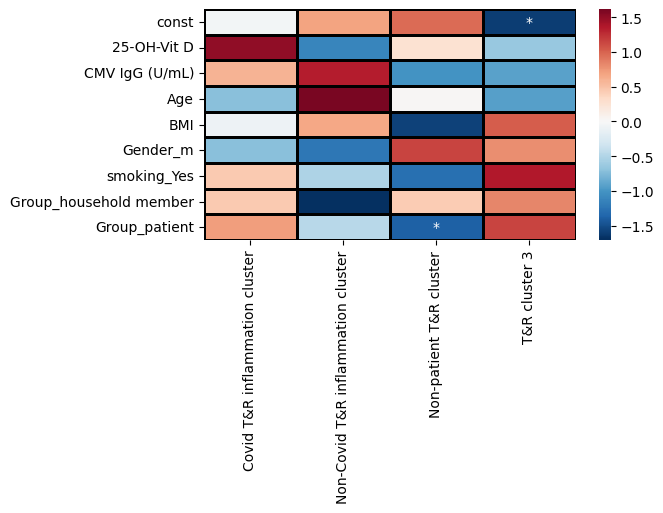

In [74]:
network = []
clus, parameters, pvalues = utils.lr_custom(tcr_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)


## One vs Rest Testing

In [75]:
genenames = normalized_counts['genename']
usable_RNA = normalized_counts.drop(columns = 'genename')
usable_RNA = usable_RNA[[c for c in usable_RNA.columns if c in list(RNA_shared['Donor'])]]
usable_RNA['genename'] = genenames
usable_RNA.reset_index(drop = True, inplace=True)


usable_TCR = TCR_stats[TCR_stats['Donor'].isin(tcr_shared['Donor'])]
usable_TCR.drop(columns = 'Donor', inplace = True)
usable_TCR.reset_index(drop = True, inplace = True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1498411686.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   mann_pvalues          features                             cluster
0      0.002161        entropyCD4      Covid T&R inflammation cluster
1      0.422611        entropyCD8      Covid T&R inflammation cluster
2      0.026767  tcrcovidmatchCD4      Covid T&R inflammation cluster
3      0.160727  tcrcovidmatchCD8      Covid T&R inflammation cluster
4      0.005768   tcrcovidfreqCD4      Covid T&R inflammation cluster
5      0.057951   tcrcovidfreqCD8      Covid T&R inflammation cluster
0      0.000304        entropyCD4  Non-Covid T&R inflammation cluster
1      0.854714        entropyCD8  Non-Covid T&R inflammation cluster
2      0.412890  tcrcovidmatchCD4  Non-Covid T&R inflammation cluster
3      0.002291  tcrcovidmatchCD8  Non-Covid T&R inflammation cluster
4      0.006453   tcrcovidfreqCD4  Non-Covid T&R inflammation cluster
5      0.001021   tcrcovidfreqCD8  Non-Covid T&R inflammation cluster
0      0.129016        entropyCD4             Non-patient T&R cluster
1      0.116623     

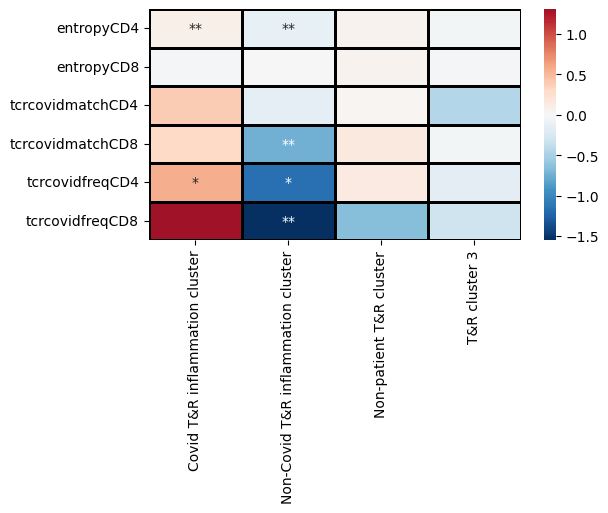

In [76]:
res = plotting.mann_sign([(usable_TCR, 'TCR')], clus_labels, res_dir)

for r in res:
    network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## GSEA

In [77]:
gsea_res = utils.gsea_analysis(usable_RNA, clus_labels, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]    

plotting.draw_network(network, clus_labels, res_dir)

2024-09-24 15:03:20,547 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:03:23,176 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:03:26,090 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:03:28,785 [WARNING] Dropping duplicated gene names, only keep the first values


<class 'pyvis.network.Network'> |N|=25 |E|=35

# Cytof RNAseq fusion

In [78]:
RNA_shared = aggregated[aggregated['Donor'].isin(cytof_meta['Donor'])]
cytof_shared = cytof[cytof_meta['Donor'].isin(aggregated['Donor'])]
cytof_shared.reset_index(drop = True, inplace = True)
RNA_shared.reset_index(drop=True, inplace = True)

In [79]:
# RNA
idx = list(set(range(affinity_RNA.shape[0])).difference(list(aggregated[~aggregated['Donor'].isin(cytof_meta['Donor'])].index)))
affinity_RNA_mod = affinity_RNA[np.ix_(idx,idx)]
print(affinity_RNA_mod.shape)
# Cytof
idx = list(set(range(affinity_cytof.shape[0])).difference(list(cytof[~cytof_meta['Donor'].isin(aggregated['Donor'])].index)))
affinity_cytof_mod = affinity_cytof[np.ix_(idx,idx)]
print(affinity_cytof_mod.shape)

(177, 177)
(177, 177)


In [80]:
res_dir = results_dir + 'Cytof_RNA_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# K neighbors size
dim = affinity_RNA_mod.shape[0]//10

Silhouette score: 0.0718522848656671


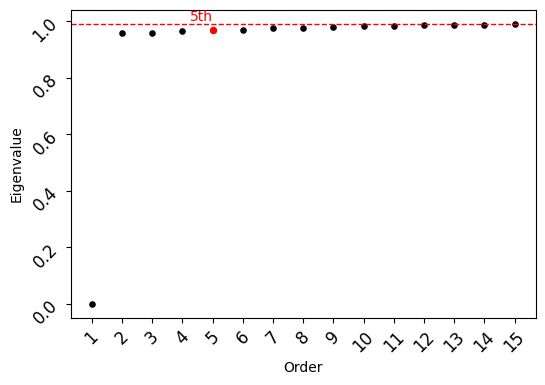

In [81]:
affinity_cytof_rna = snf.snf([affinity_RNA_mod, affinity_cytof_mod], K=dim)

n_clusters = 5
plotting.eigengap_visual(affinity_cytof_rna, [n_clusters], res_dir)

clus_labels = utils.spectral_clustering_custom(affinity_cytof_rna, n_clusters)

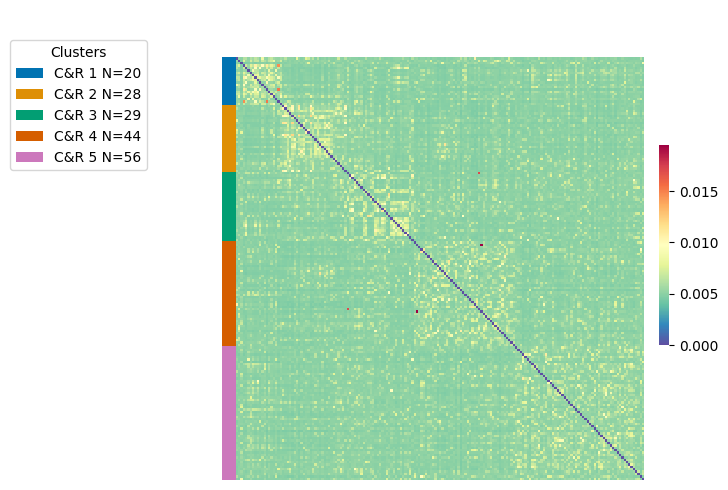

In [82]:
clus_labels = pd.Series(['C&R ' + str(int(x[-1])+1) for x in clus_labels])
plotting.draw_clustermap(clus_labels, affinity_cytof_rna, res_dir, 'no')

## Logistic Regression on clusters

Size of metadata: (175, 393)
Size of metadata after NaNs removal: (166, 391)
Shape of the regression input: (166, 8)
C&R 1
Optimization terminated successfully.
         Current function value: 0.336085
         Iterations: 53
         Function evaluations: 54
         Gradient evaluations: 54
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  166
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                 0.02081
Time:                        15:03:33   Log-Likelihood:                -55.790
converged:                       True   LL-Null:                       -56.976
Covariance Type:            nonrobust   LLR p-value:                    0.9675
                             coef    std err          z      P>|z|      [

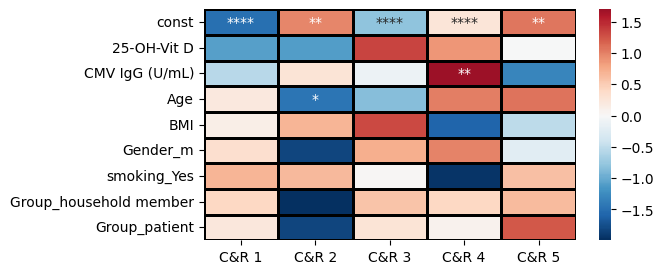

In [83]:
network = []
clus, parameters, pvalues = utils.lr_custom(RNA_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## One vs Rest Testing

In [84]:
genenames = normalized_counts['genename']
usable_RNA = normalized_counts.drop(columns = 'genename')
usable_RNA = usable_RNA[[c for c in usable_RNA.columns if c in list(RNA_shared['Donor'])]]
usable_RNA['genename'] = genenames
usable_RNA.reset_index(drop = True, inplace=True)

usable_cytof = cytof_meta[cytof_meta['Donor'].isin(aggregated['Donor'])]
usable_cytof.drop(columns = 'Donor', inplace = True)
usable_cytof.reset_index(drop = True, inplace = True)


/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1340035615.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Overlay Gut Microbiome but not used in the fusion

In [85]:
usable_micro = micro_fused[micro_fused['Donor'].isin(aggregated['Donor'])]
usable_micro = usable_micro[usable_micro['Donor'].isin(cytof_meta['Donor'])]
usable_micro.reset_index(drop=True, inplace = True)

test_labels = pd.DataFrame()
test_labels['labels'] = clus_labels
test_labels['Donor'] = RNA_shared['Donor']

test_labels = pd.merge(test_labels,usable_micro, how='right')
test_labels.reset_index(drop=True,inplace=True)
test_labels = pd.Series(test_labels['labels'])

## Save data for chord visualisation

In [86]:
# Start saving results for multi chord diagram
multi_chord = pd.DataFrame()
multi_chord['Cytof+RNA'] = test_labels

In [87]:
single_asv_data = micro_data_norm.set_index('taxaname').T
single_asv_data = single_asv_data[single_asv_data.index.isin(usable_micro['Donor'])]
single_asv_data.columns = [list(micro_taxa[micro_taxa['taxon_name'] == taxon]['taxon_id'])[0] for taxon in single_asv_data.columns]
single_asv_data.reset_index(inplace=True)
res = plotting.micro_analysis(single_asv_data, test_labels, micro_taxa, res_dir)

#[network.append(element) for element in res]





















   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesFo

['C&R 5', 'C&R 2', 'C&R 2', 'C&R 5', 'C&R 1', 'C&R 5', 'C&R 4', 'C&R 4', 'C&R 4', 'C&R 2', 'C&R 1', 'C&R 3', 'C&R 5', 'C&R 5', 'C&R 4', 'C&R 4', 'C&R 2', 'C&R 2', 'C&R 4', 'C&R 2', 'C&R 5', 'C&R 1', 'C&R 2', 'C&R 2', 'C&R 1', 'C&R 3', 'C&R 2', 'C&R 3', 'C&R 1', 'C&R 4', 'C&R 4', 'C&R 2', 'C&R 1', 'C&R 1', 'C&R 1', 'C&R 2', 'C&R 5', 'C&R 4', 'C&R 5', 'C&R 2', 'C&R 5', 'C&R 3', 'C&R 4', 'C&R 5', 'C&R 4', 'C&R 5', 'C&R 2', 'C&R 3', 'C&R 5', 'C&R 2', 'C&R 1', 'C&R 5', 'C&R 3', 'C&R 2', 'C&R 1', 'C&R 2', 'C&R 2', 'C&R 4', 'C&R 5', 'C&R 3', 'C&R 4', 'C&R 3', 'C&R 2', 'C&R 3', 'C&R 3', 'C&R 3', 'C&R 2', 'C&R 1', 'C&R 2', 'C&R 5', 'C&R 3', 'C&R 2', 'C&R 4', 'C&R 5', 'C&R 4', 'C&R 3', 'C&R 2', 'C&R 1', 'C&R 4', 'C&R 4', 'C&R 5', 'C&R 3', 'C&R 2', 'C&R 3', 'C&R 4', 'C&R 5', 'C&R 2', 'C&R 1', 'C&R 4', 'C&R 3', 'C&R 3', 'C&R 4', 'C&R 1', 'C&R 3', 'C&R 4', 'C&R 4', 'C&R 5', 'C&R 5', 'C&R 3', 'C&R 2', 'C&R 4', 'C&R 3', 'C&R 5', 'C&R 1', 'C&R 4', 'C&R 1', 'C&R 4', 'C&R 4', 'C&R 1', 'C&R 4', 'C&R 3', 

Cluster C&R 1
Cluster C&R 2
Cluster C&R 3
Cluster C&R 4
Cluster C&R 5
{'source': 'Lachnospiraceae', 'target': 'C&R 2', 'weight': 0.7705983274096847, 'origin': 'GSEA_bacteria', 'genes': 'LLKB_g 2;Lachnospira 5;Eubacterium_g4 2;AY305316_g 2;Murimonas 3;Dorea 2;Eubacterium_g17 2;Clostridium_g7 2;Lachnospiraceae 20;EU842423_g 2;Ruminococcus_g4 4;Lachnospiraceae 9;Lachnospira 2;Eubacterium_g20 1;KE159538_g 2;EF406589_g 1;EU457907_g 1;Lachnospiraceae 3;Blautia 1;Blautia 7;Dorea 1;Blautia 3;Clostridium_g24 1;Ruminococcus_g4 2;Lachnospiraceae 2;Eubacterium_g17 3;Lachnospira 1;Eubacterium_g17 1;Eisenbergiella 1;Sellimonas 1;Marvinbryantia 1;Anaerostipes 1;Roseburia 1;Coprococcus 3;Clostridium_g23 1;Clostridium_g24 2;Blautia 6;KE159538_g 1;Roseburia 3;Eisenbergiella 2;HM123979_g 2;AJ576336_g 1;Murimonas 1;Eubacterium_g4 3;EF402988_g 3;HM123979_g 1;EU842423_g 1;KE159538_g 3;Ruminococcus_g4 3;DQ057459_g 2;Butyrivibrio_g1 2;Eubacterium_g7 1;Blautia 19;Eubacterium_g4 1;LLKB_g 1;Agathobacter 1;Rumino

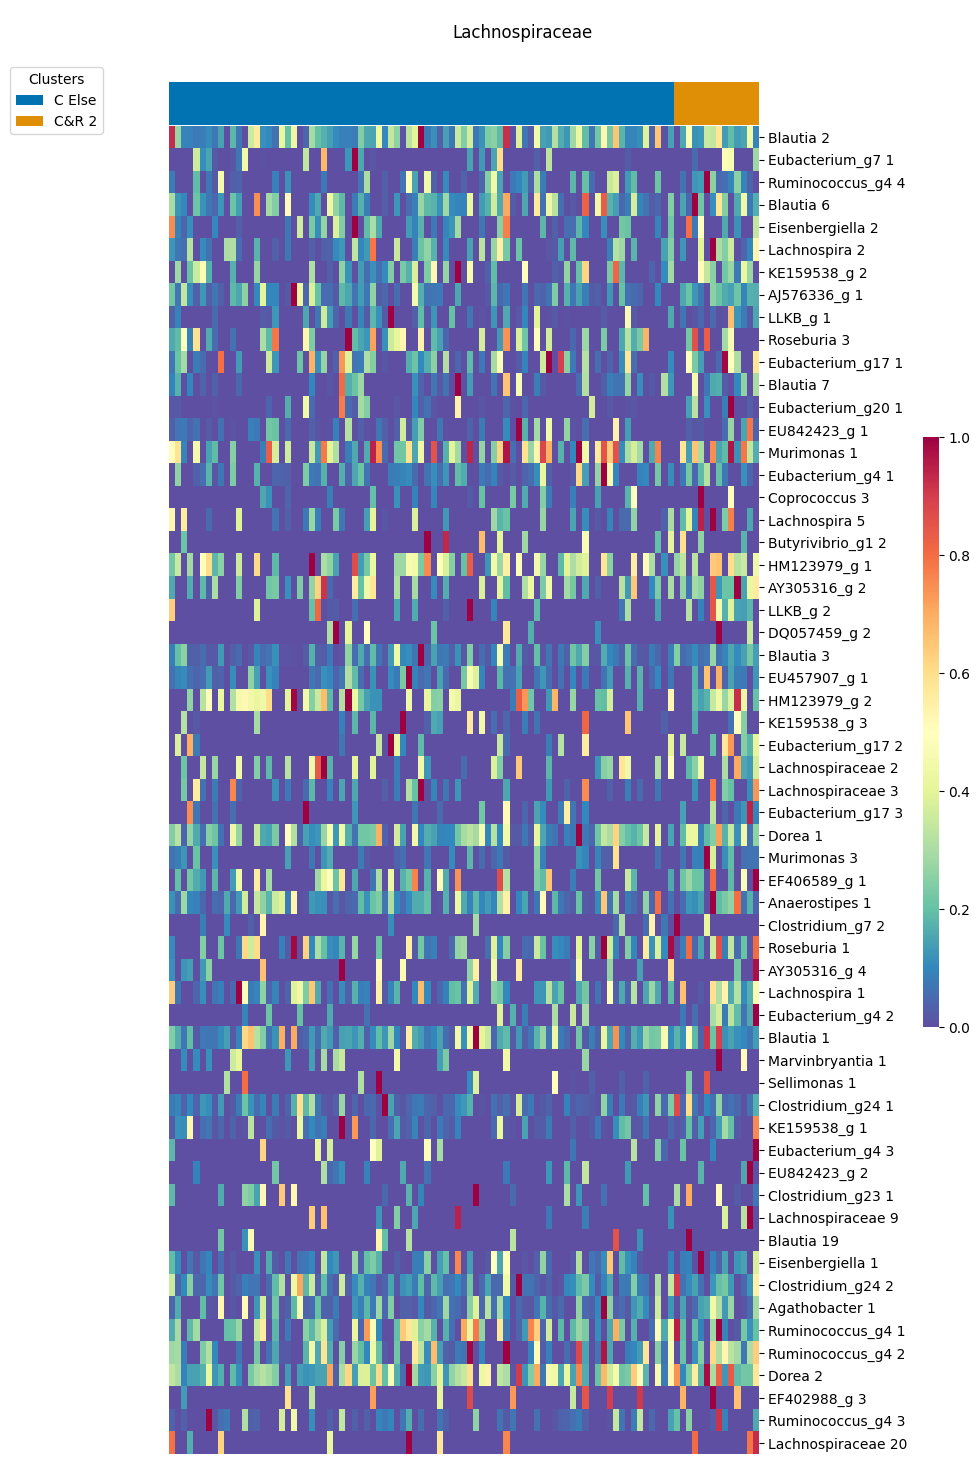

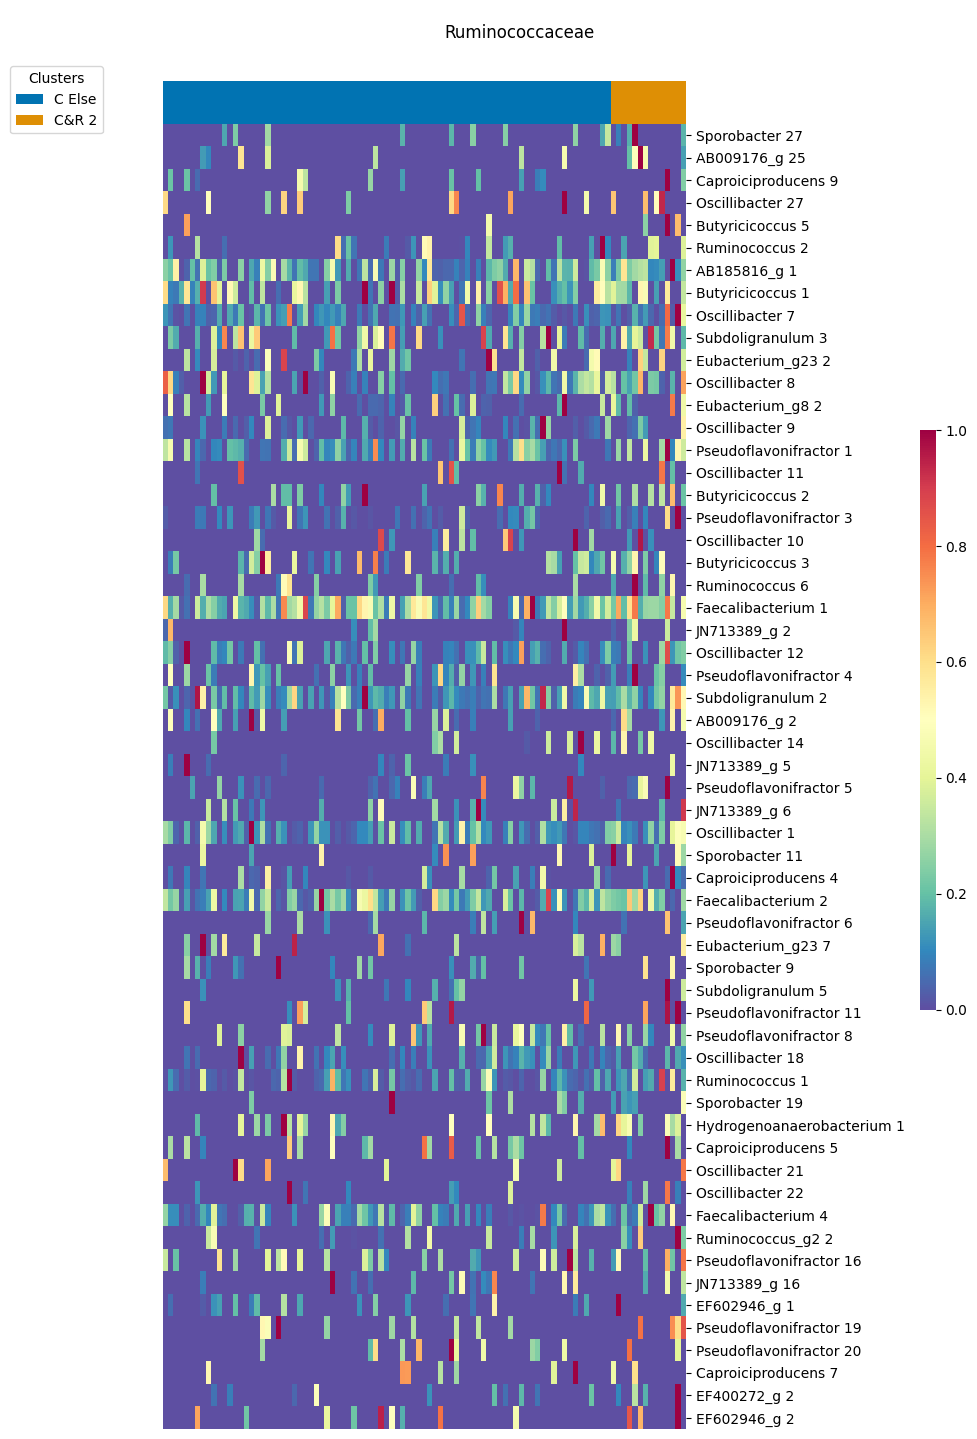

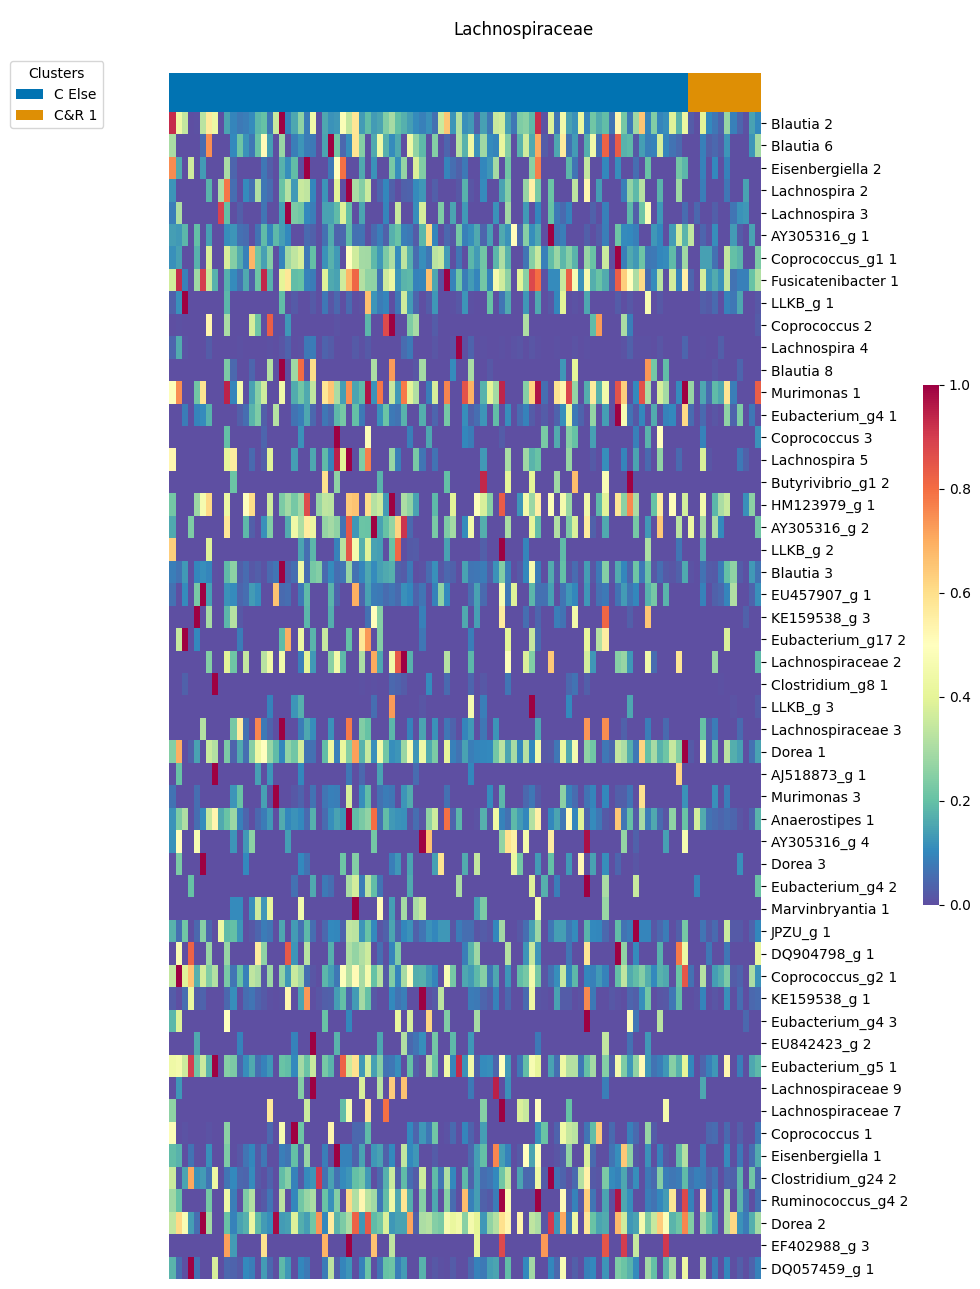

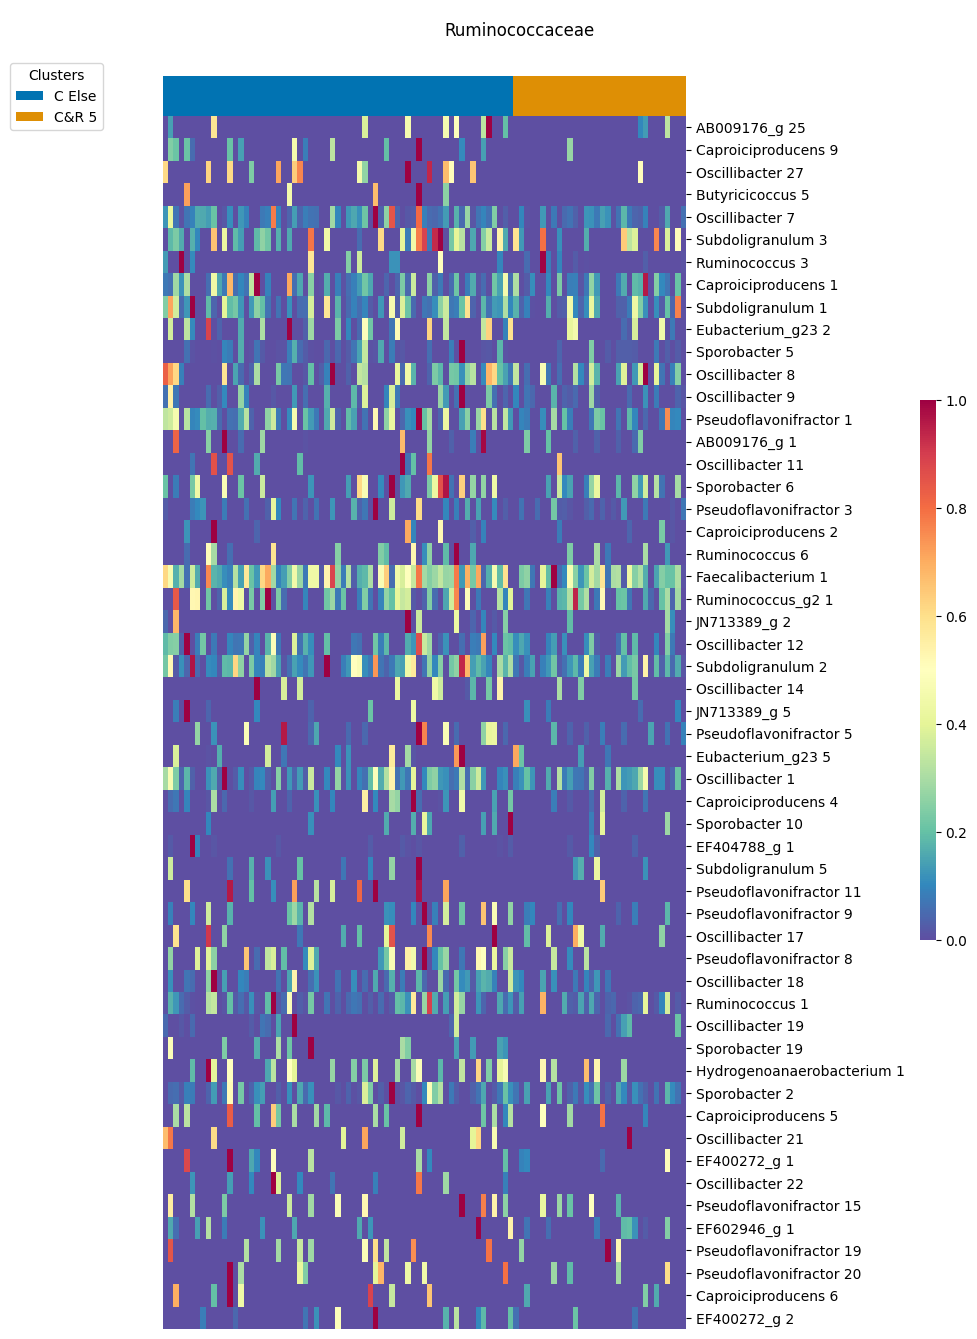

In [88]:
res = utils.gsea_analysis_bacteria(micro_data_norm.iloc[:,micro_data_norm.columns.isin(list(usable_micro['Donor'])+['taxaname'])],
                                test_labels, bubble_dir, res_dir, [custom_bacteria_gene_lists])

[network.append(element) for element in res]

utils.plot_heatmaps_gsea_bacteria(res, micro_fused_rel[micro_fused_rel['Donor'].isin(list(usable_micro['Donor']))].reset_index(drop=True), 
                                test_labels, micro_taxa, res_dir)

## Cytof clusters analysis

Cytof number of columns 22
No need to drop Donor


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



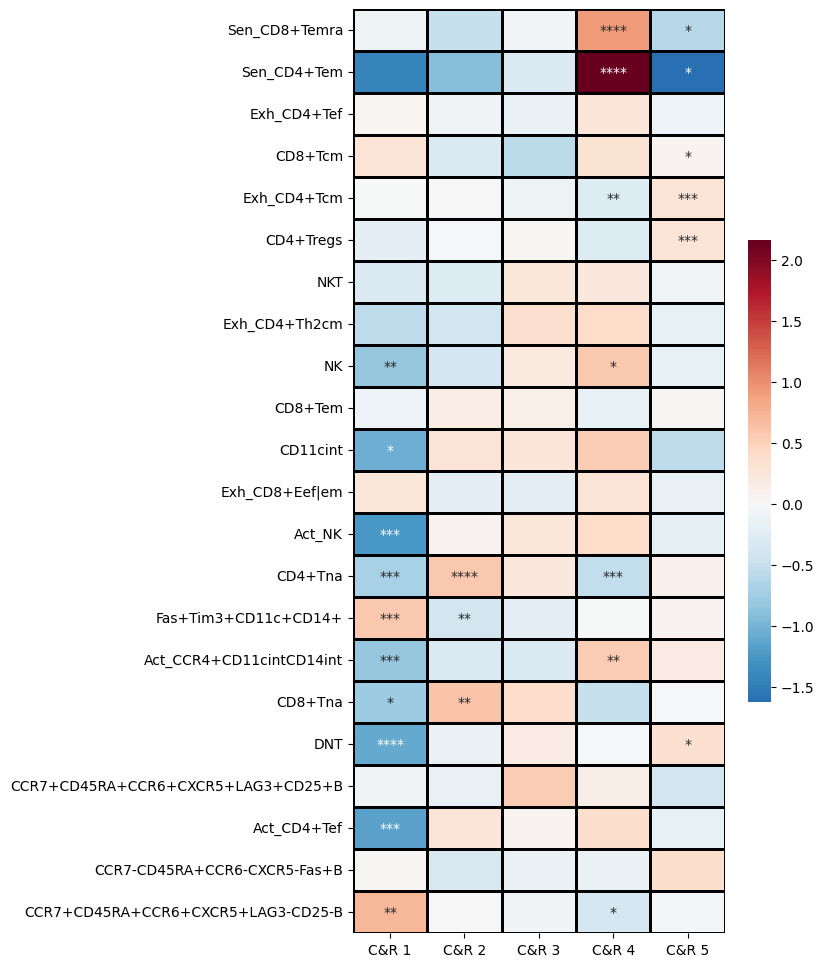

In [89]:
r = utils.cytof_clusters_analysis(usable_cytof, clus_labels, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## GSEA

In [90]:
gsea_res = utils.gsea_analysis(usable_RNA, clus_labels, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]

plotting.draw_network(network, clus_labels, res_dir)

2024-09-24 15:05:32,861 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:05:35,778 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:05:38,727 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:05:41,448 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:05:44,410 [WARNING] Dropping duplicated gene names, only keep the first values


<class 'pyvis.network.Network'> |N|=57 |E|=82

# Cytof TCRseq fusion

In [91]:
cytof_shared = cytof[cytof_meta['Donor'].isin(module_counts_tcr['Donor'])]
cytof_shared.reset_index(drop = True, inplace = True)
tcr_shared = module_counts_tcr[module_counts_tcr['Donor'].isin(cytof_meta['Donor'])]
tcr_shared.reset_index(drop = True, inplace = True)

In [92]:
# Cytof
idx = list(set(range(affinity_cytof.shape[0])).difference(list(cytof[~cytof_meta['Donor'].isin(module_counts_tcr['Donor'])].index)))
affinity_cytof_mod = affinity_cytof[np.ix_(idx,idx)]
print(affinity_cytof_mod.shape)
# TCR
idx = list(set(range(affinity_tcr.shape[0])).difference(list(module_counts_tcr[~module_counts_tcr['Donor'].isin(cytof_meta['Donor'])].index)))
affinity_tcr_mod = affinity_tcr[np.ix_(idx,idx)]
print(affinity_tcr_mod.shape)

(47, 47)
(47, 47)


In [93]:
res_dir = results_dir + 'Cytof_TCR_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)
dim = affinity_cytof_mod.shape[0]//10

Silhouette score: 0.3558232533934804


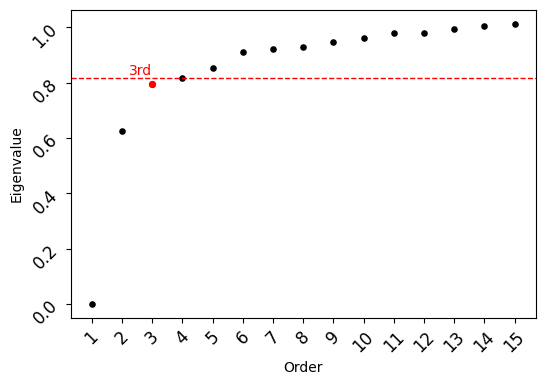

In [94]:
affinity_cytof_tcr = snf.snf([affinity_cytof_mod, affinity_tcr_mod], K=dim)

n_clusters = 3
plotting.eigengap_visual(affinity_cytof_tcr, [n_clusters], res_dir)
clus_labels = utils.spectral_clustering_custom(affinity_cytof_tcr, n_clusters)

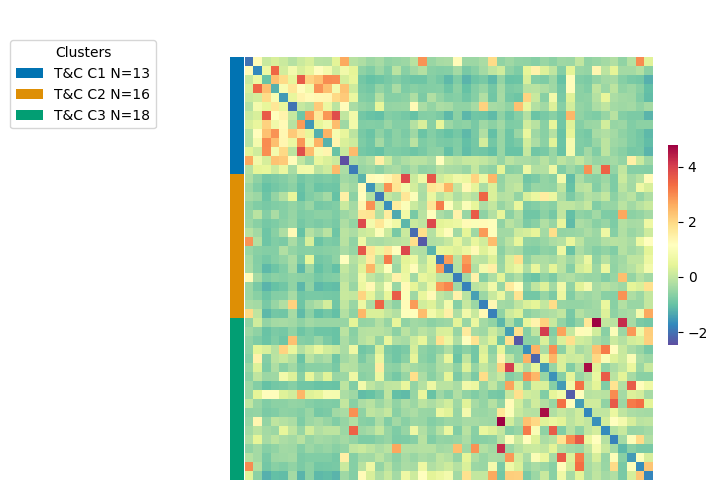

In [95]:
clus_labels.replace({'C 0': 'T&C C1', 'C 1': 'T&C C2', 'C 2': 'T&C C3'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity_cytof_tcr, res_dir, 'standard')

## Logistic Regression on clusters

Size of metadata: (47, 1009)
Size of metadata after NaNs removal: (45, 1007)
Shape of the regression input: (45, 8)
T&C C1
Optimization terminated successfully.
         Current function value: 0.361103
         Iterations: 60
         Function evaluations: 61
         Gradient evaluations: 61
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.3993
Time:                        15:05:49   Log-Likelihood:                -16.250
converged:                       True   LL-Null:                       -27.052
Covariance Type:            nonrobust   LLR p-value:                  0.005704
                             coef    std err          z      P>|z|      [

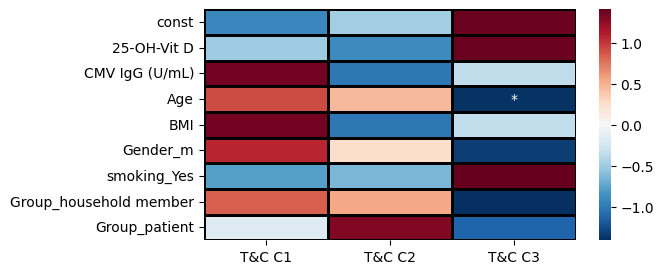

In [96]:
network = []
clus, parameters, pvalues = utils.lr_custom(tcr_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)


## One vs Rest Testing

In [97]:
usable_TCR = TCR_stats[TCR_stats['Donor'].isin(tcr_shared['Donor'])]
usable_TCR.drop(columns = 'Donor', inplace = True)
usable_TCR.reset_index(drop = True, inplace = True)

usable_cytof = cytof_meta[cytof_meta['Donor'].isin(module_counts_tcr['Donor'])]
usable_cytof.drop(columns = 'Donor', inplace = True)
usable_cytof.reset_index(drop = True, inplace = True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1247364513.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1247364513.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   mann_pvalues          features cluster
0      0.037436        entropyCD4  T&C C1
1      0.012945        entropyCD8  T&C C1
2      0.600455  tcrcovidmatchCD4  T&C C1
3      0.175429  tcrcovidmatchCD8  T&C C1
4      0.905249   tcrcovidfreqCD4  T&C C1
5      0.589481   tcrcovidfreqCD8  T&C C1
0      0.124080        entropyCD4  T&C C2
1      0.493505        entropyCD8  T&C C2
2      0.233618  tcrcovidmatchCD4  T&C C2
3      0.252935  tcrcovidmatchCD8  T&C C2
4      0.736041   tcrcovidfreqCD4  T&C C2
5      0.110484   tcrcovidfreqCD8  T&C C2
0      0.685579        entropyCD4  T&C C3
1      0.107725        entropyCD8  T&C C3
2      0.504037  tcrcovidmatchCD4  T&C C3
3      0.017679  tcrcovidmatchCD8  T&C C3
4      0.653370   tcrcovidfreqCD4  T&C C3
5      0.039082   tcrcovidfreqCD8  T&C C3


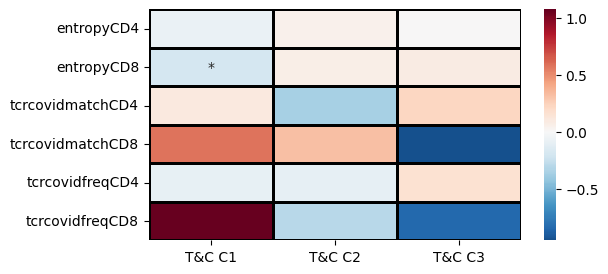

In [98]:
res = plotting.mann_sign([(usable_TCR, 'TCR')], clus_labels, res_dir)

for r in res:
    network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## Cytof clusters analysis

Cytof number of columns 22
No need to drop Donor


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pyvis.network.Network'> |N|=17 |E|=19

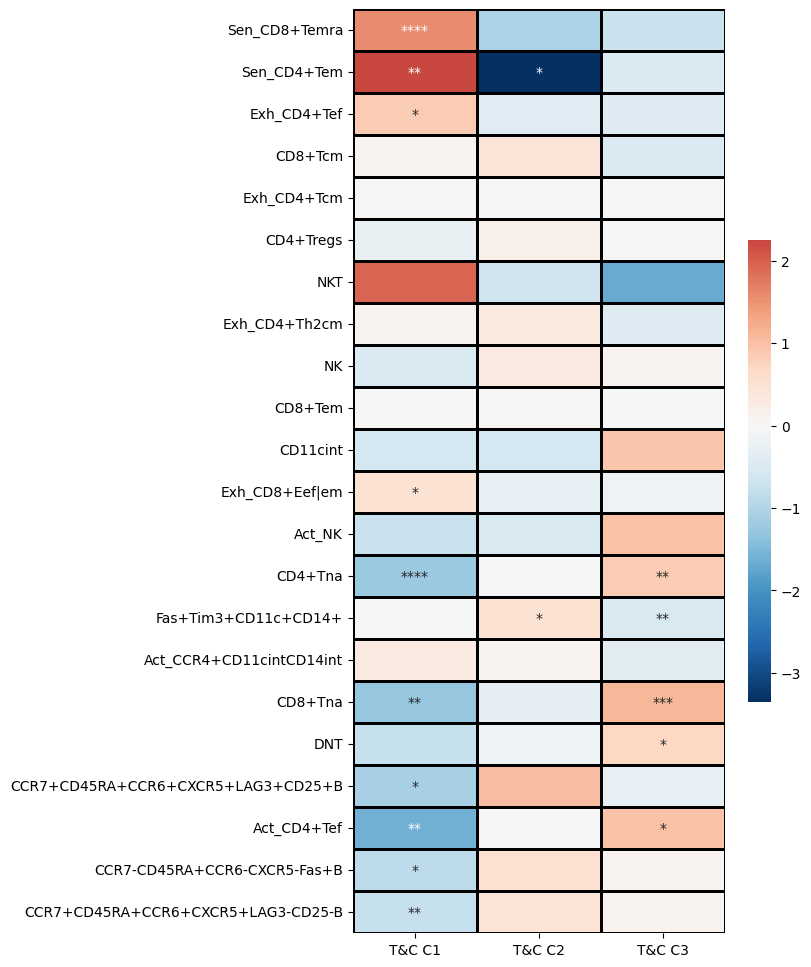

In [99]:
r = utils.cytof_clusters_analysis(usable_cytof,clus_labels, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

plotting.draw_network(network, clus_labels, res_dir)

# Cytof RNAseq TCRseq fusion

In [100]:
RNA_shared = aggregated[aggregated['Donor'].isin(cytof_meta['Donor'])]
RNA_shared = RNA_shared[RNA_shared['Donor'].isin(module_counts_tcr['Donor'])]
RNA_shared.reset_index(drop=True, inplace = True)

aux = cytof.copy()
aux['Donor'] = cytof_meta['Donor']
cytof_shared = aux[aux['Donor'].isin(aggregated['Donor'])]
cytof_shared = cytof_shared[cytof_shared['Donor'].isin(module_counts_tcr['Donor'])]
cytof_shared.reset_index(drop=True, inplace = True)

tcr_shared = module_counts_tcr[module_counts_tcr['Donor'].isin(aggregated['Donor'])]
tcr_shared = tcr_shared[tcr_shared['Donor'].isin(cytof_meta['Donor'])]
tcr_shared.reset_index(drop = True, inplace = True)

In [101]:
# Cytof
idx = list(set(range(affinity_cytof.shape[0])).difference(list(cytof[~ ( (cytof_meta['Donor'].isin(module_counts_tcr['Donor']))  & (cytof_meta['Donor'].isin(aggregated['Donor']))) ].index)))
affinity_cytof_mod = affinity_cytof[np.ix_(idx,idx)]
print(affinity_cytof_mod.shape)
# TCR
idx = list(set(range(affinity_tcr.shape[0])).difference(list(module_counts_tcr[~ ( (module_counts_tcr['Donor'].isin(cytof_meta['Donor']))  & (module_counts_tcr['Donor'].isin(aggregated['Donor']))) ].index)))
affinity_tcr_mod = affinity_tcr[np.ix_(idx,idx)]
print(affinity_tcr_mod.shape)
# RNA
idx = list(set(range(affinity_RNA.shape[0])).difference(list(aggregated[~ ( (aggregated['Donor'].isin(cytof_meta['Donor']))  & (aggregated['Donor'].isin(module_counts_tcr['Donor']))) ].index)))
affinity_RNA_mod = affinity_RNA[np.ix_(idx,idx)]
print(affinity_RNA_mod.shape)

(45, 45)
(45, 45)
(45, 45)


In [102]:
res_dir = results_dir + 'Cytof_TCR_RNA_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)
dim = affinity_RNA_mod.shape[0]//10

Silhouette score: 0.22891529830615312


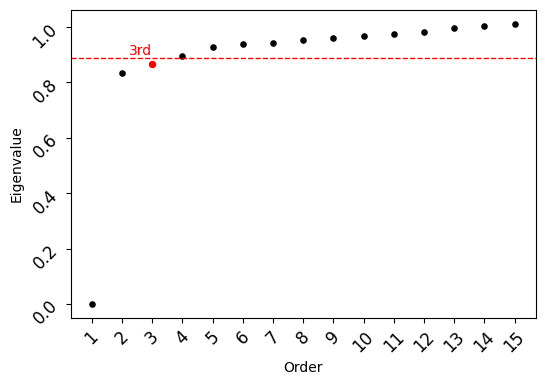

In [103]:
affinity_cytof_rna_tcr = snf.snf([affinity_cytof_mod, 
                                  affinity_tcr_mod, 
                                  affinity_RNA_mod], K=dim)

n_clusters = 3
plotting.eigengap_visual(affinity_cytof_rna_tcr, [n_clusters], res_dir)

clus_labels = utils.spectral_clustering_custom(affinity_cytof_rna_tcr, n_clusters)

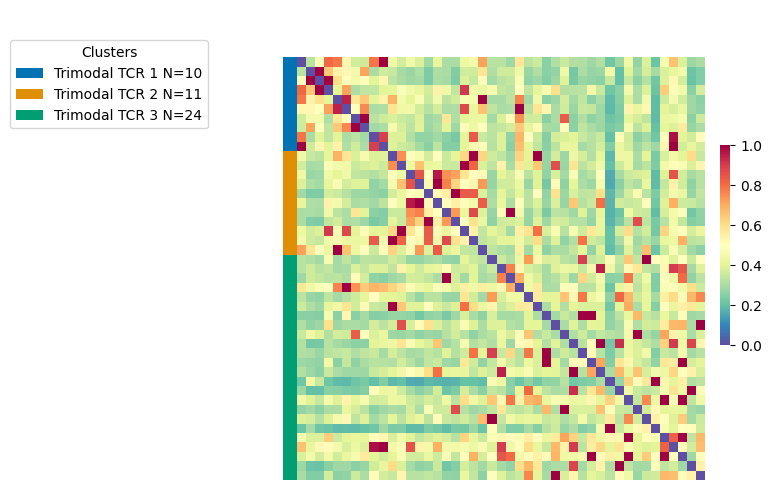

In [104]:
clus_labels.replace({'C 0': 'Trimodal TCR 1', 'C 1': 'Trimodal TCR 2', 'C 2': 'Trimodal TCR 3'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity_cytof_rna_tcr, res_dir, 'minmax')

## Logistic Regression on clusters

Size of metadata: (45, 393)
Size of metadata after NaNs removal: (43, 391)
Shape of the regression input: (43, 8)
Trimodal TCR 1
Optimization terminated successfully.
         Current function value: 0.320682
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   43
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.3749
Time:                        15:05:54   Log-Likelihood:                -13.789
converged:                       True   LL-Null:                       -22.060
Covariance Type:            nonrobust   LLR p-value:                   0.03525
                             coef    std err          z      P>|z| 

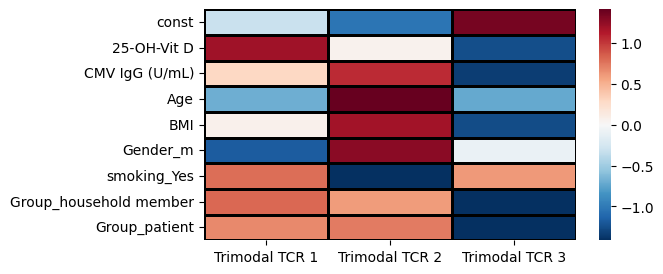

In [105]:
network = []
clus, parameters, pvalues = utils.lr_custom(RNA_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## One vs Rest Testing

In [106]:
genenames = normalized_counts['genename']
usable_RNA = normalized_counts.drop(columns = 'genename')
usable_RNA = usable_RNA[[c for c in usable_RNA.columns if c in list(RNA_shared['Donor'])]]
usable_RNA['genename'] = genenames
usable_RNA.reset_index(drop = True, inplace=True)

usable_cytof = cytof_meta[cytof_meta['Donor'].isin(cytof_shared['Donor'])]
usable_cytof.drop(columns = 'Donor', inplace = True)
usable_cytof.reset_index(drop = True, inplace = True)

usable_TCR = TCR_stats[TCR_stats['Donor'].isin(tcr_shared['Donor'])]
usable_TCR.drop(columns = 'Donor', inplace = True)
usable_TCR.reset_index(drop = True, inplace = True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1880912552.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/1880912552.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



   mann_pvalues          features         cluster
0      0.967335        entropyCD4  Trimodal TCR 1
1      0.632816        entropyCD8  Trimodal TCR 1
2      0.262445  tcrcovidmatchCD4  Trimodal TCR 1
3      0.553463  tcrcovidmatchCD8  Trimodal TCR 1
4      0.584620   tcrcovidfreqCD4  Trimodal TCR 1
5      0.945066   tcrcovidfreqCD8  Trimodal TCR 1
0      0.150046        entropyCD4  Trimodal TCR 2
1      0.012568        entropyCD8  Trimodal TCR 2
2      0.284233  tcrcovidmatchCD4  Trimodal TCR 2
3      0.149926  tcrcovidmatchCD8  Trimodal TCR 2
4      0.721127   tcrcovidfreqCD4  Trimodal TCR 2
5      0.831091   tcrcovidfreqCD8  Trimodal TCR 2
0      0.232315        entropyCD4  Trimodal TCR 3
1      0.081783        entropyCD8  Trimodal TCR 3
2      0.061801  tcrcovidmatchCD4  Trimodal TCR 3
3      0.462351  tcrcovidmatchCD8  Trimodal TCR 3
4      0.438682   tcrcovidfreqCD4  Trimodal TCR 3
5      0.908571   tcrcovidfreqCD8  Trimodal TCR 3


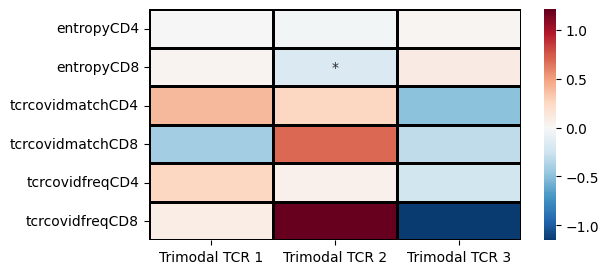

In [107]:
res = plotting.mann_sign([(usable_TCR, 'TCR')], clus_labels, res_dir)

for r in res:
    network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## Cytof clusters analysis

Cytof number of columns 22
No need to drop Donor


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



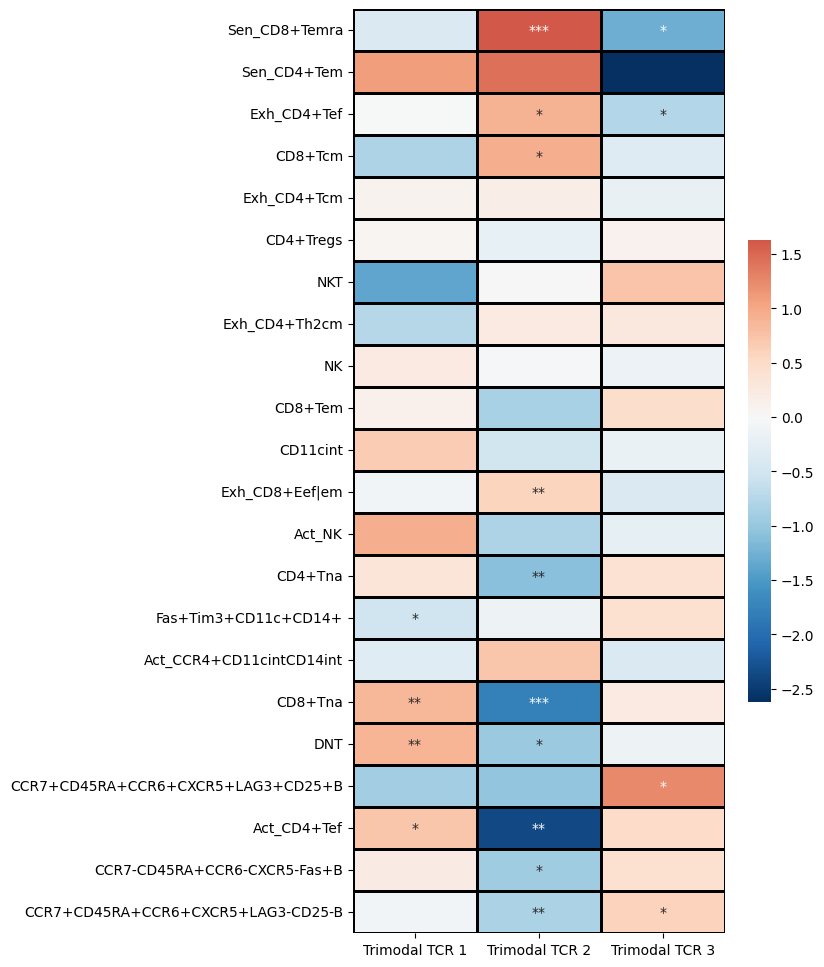

In [108]:
r = utils.cytof_clusters_analysis(usable_cytof, clus_labels, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## GSEA

In [109]:
gsea_res = utils.gsea_analysis(usable_RNA, clus_labels, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]

plotting.draw_network(network, clus_labels, res_dir)

2024-09-24 15:05:58,068 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:05:59,307 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:06:01,451 [WARNING] Dropping duplicated gene names, only keep the first values


<class 'pyvis.network.Network'> |N|=22 |E|=25

# Microbiome RNAseq fusion

In [110]:
RNA_shared = aggregated[aggregated['Donor'].isin(micro_fused['Donor'])]
RNA_shared.reset_index(drop=True, inplace = True)
micro_shared = micro_fused[micro_fused['Donor'].isin(aggregated['Donor'])]
micro_shared.reset_index(drop=True, inplace = True)

In [111]:
# RNA
idx = list(set(range(affinity_RNA.shape[0])).difference(list(aggregated[~aggregated['Donor'].isin(micro_fused['Donor'])].index)))
affinity_RNA_mod = affinity_RNA[np.ix_(idx,idx)]
print(affinity_RNA_mod.shape)
# Microbiome
idx = list(set(range(affinity_microbe.shape[0])).difference(list(micro_fused[~micro_fused['Donor'].isin(aggregated['Donor'])].index)))
affinity_microbe_mod = affinity_microbe[np.ix_(idx,idx)]
print(affinity_microbe_mod.shape)

(171, 171)
(171, 171)


In [112]:
res_dir = results_dir + 'Microbiome_RNA_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)
dim = affinity_microbe_mod.shape[0]//10

Silhouette score: 0.05707070881968991


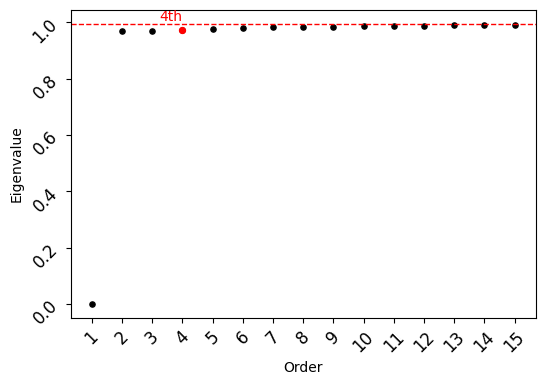

In [113]:
affinity_micro_rna = snf.snf([affinity_RNA_mod, affinity_microbe_mod], K=dim)


n_clusters = 4
plotting.eigengap_visual(affinity_micro_rna, [n_clusters], res_dir)

clus_labels = utils.spectral_clustering_custom(affinity_micro_rna, n_clusters)

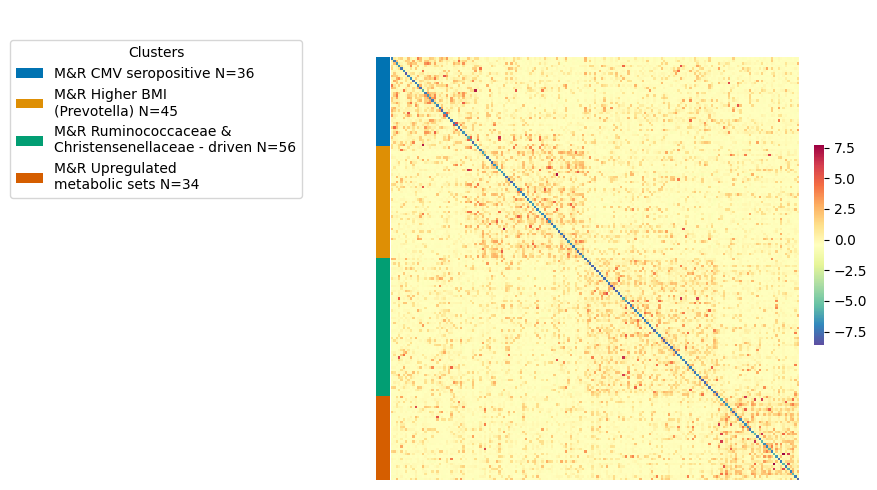

In [114]:
clus_labels.replace({'C 0': 'M&R Upregulated\nmetabolic sets',
                     'C 1': 'M&R CMV seropositive',
                     'C 2': 'M&R Higher BMI\n(Prevotella)',
                     'C 3': 'M&R Ruminococcaceae &\nChristensenellaceae - driven'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity_micro_rna, res_dir, 'standard')

     Shannon index  Simpson index  Chao1 richness  \
0         5.404588       0.956193           143.0   
1         4.803342       0.890112           165.0   
2         6.020344       0.971639           166.0   
3         5.100961       0.901752           169.0   
4         4.937250       0.922678           123.0   
..             ...            ...             ...   
166       5.513889       0.947911           143.0   
167       4.564746       0.888319           129.0   
168       5.887697       0.970314           158.0   
169       5.129678       0.945811           109.0   
170       5.613101       0.960746           132.0   

                                               Cluster  
0                      M&R Upregulated\nmetabolic sets  
1    M&R Ruminococcaceae &\nChristensenellaceae - d...  
2    M&R Ruminococcaceae &\nChristensenellaceae - d...  
3                                 M&R CMV seropositive  
4    M&R Ruminococcaceae &\nChristensenellaceae - d...  
..                   

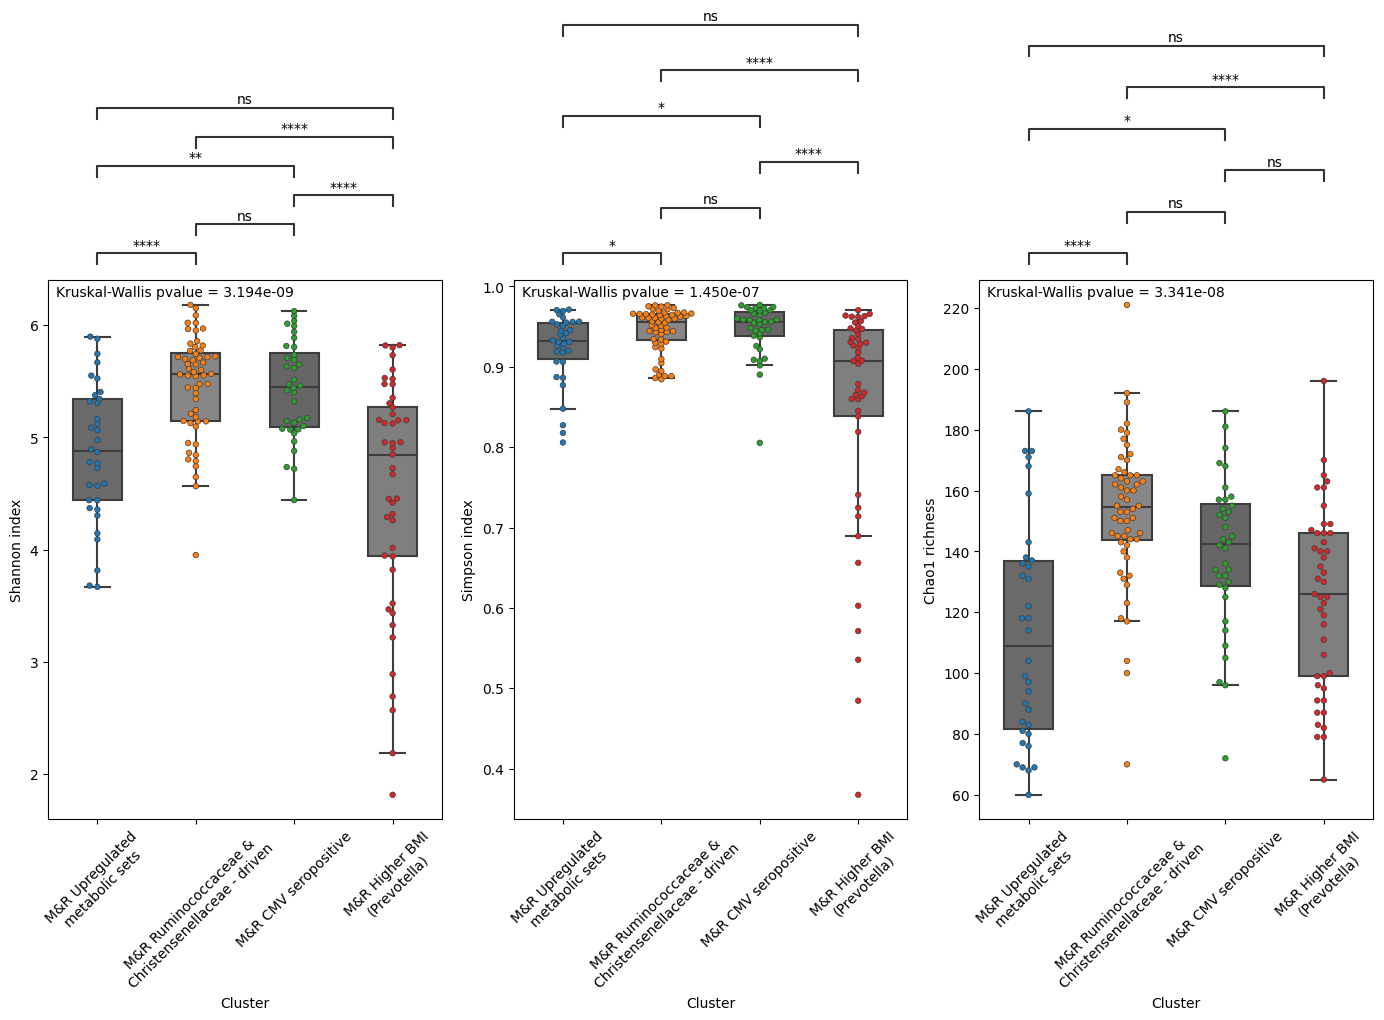

In [115]:
plotting.alpha_diversity_microbiome(micro_fused_rel[micro_fused_rel['Donor'].isin(list(micro_shared['Donor']))].drop(columns=['Donor']), 
                                                    micro_shared['Donor'], clus_labels, res_dir)

In [116]:
clus_labels = clus_labels.str.replace('\n', ' ')

## Logistic regression on clusters

Size of metadata: (168, 393)
Size of metadata after NaNs removal: (158, 391)
Shape of the regression input: (158, 8)
M&R CMV seropositive
Optimization terminated successfully.
         Current function value: 0.454371
         Iterations: 61
         Function evaluations: 62
         Gradient evaluations: 62
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                      149
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                  0.1133
Time:                        15:06:12   Log-Likelihood:                -71.791
converged:                       True   LL-Null:                       -80.966
Covariance Type:            nonrobust   LLR p-value:                   0.01874
                             coef    std err          z   

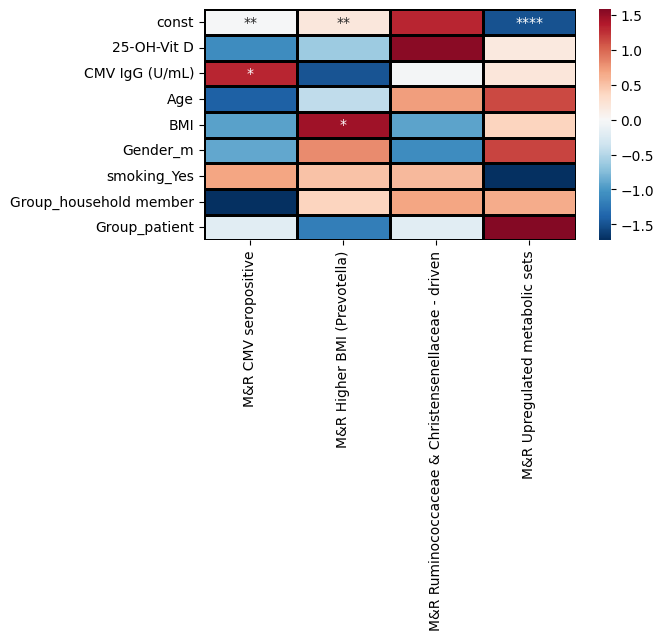

In [117]:
network = []
clus, parameters, pvalues = utils.lr_custom(RNA_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## One vs Rest Testing

In [118]:
genenames = normalized_counts['genename']
usable_RNA = normalized_counts.drop(columns = 'genename')
usable_RNA = usable_RNA[[c for c in usable_RNA.columns if c in list(RNA_shared['Donor'])]]
usable_RNA['genename'] = genenames
usable_RNA.reset_index(drop = True, inplace=True)

usable_micro = micro_fused[micro_fused['Donor'].isin(micro_shared['Donor'])]
usable_micro.reset_index(drop = True, inplace = True)


## Save data for chord visualisation

In [119]:
aux = cytof.copy()
aux['Donor'] = cytof_meta['Donor']
cytof_shared = aux[aux['Donor'].isin(aggregated['Donor'])]
cytof_shared = cytof_shared[cytof_shared['Donor'].isin(micro_fused['Donor'])]
cytof_shared.reset_index(drop=True, inplace = True)

usable_cytof = cytof_meta[cytof_meta['Donor'].isin(cytof_shared['Donor'])]

test_labels = pd.DataFrame()
test_labels['labels'] = clus_labels
test_labels['Donor'] = RNA_shared['Donor']

test_labels = pd.merge(test_labels,usable_cytof, how='right')
test_labels.reset_index(drop=True,inplace=True)
test_labels = pd.Series(test_labels['labels'])

usable_cytof.drop(columns = 'Donor', inplace = True)
usable_cytof.reset_index(drop = True, inplace = True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/2136915240.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
multi_chord['Micro+RNA'] = test_labels

/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cytof number of columns 22
No need to drop Donor


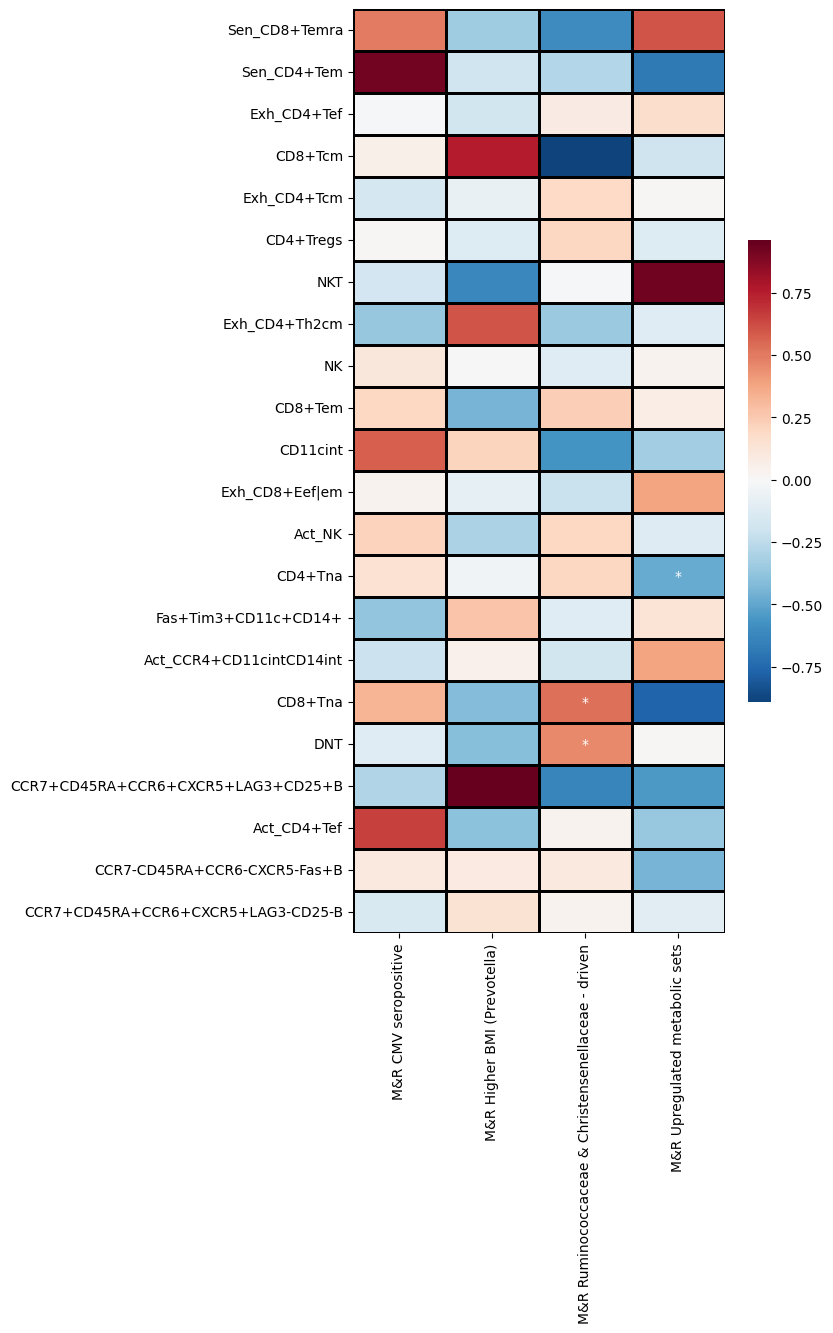

In [121]:
r = utils.cytof_clusters_analysis(usable_cytof, test_labels, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

In [122]:
single_asv_data = micro_data_norm.set_index('taxaname').T
single_asv_data = single_asv_data[single_asv_data.index.isin(usable_micro['Donor'])]
single_asv_data.columns = [list(micro_taxa[micro_taxa['taxon_name'] == taxon]['taxon_id'])[0] for taxon in single_asv_data.columns]
single_asv_data.reset_index(inplace=True)
res = plotting.micro_analysis(single_asv_data, clus_labels, micro_taxa, res_dir)

#[network.append(element) for element in res]


















   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForRe

['M&R Upregulated metabolic sets', 'M&R CMV seropositive', 'M&R Higher BMI (Prevotella)', 'M&R Ruminococcaceae & Christensenellaceae - driven', 'M&R Higher BMI (Prevotella)', 'M&R CMV seropositive', 'M&R Higher BMI (Prevotella)', 'M&R Ruminococcaceae & Christensenellaceae - driven', 'M&R Higher BMI (Prevotella)', 'M&R Higher BMI (Prevotella)', 'M&R Upregulated metabolic sets', 'M&R Ruminococcaceae & Christensenellaceae - driven', 'M&R Higher BMI (Prevotella)', 'M&R Upregulated metabolic sets', 'M&R Ruminococcaceae & Christensenellaceae - driven', 'M&R Higher BMI (Prevotella)', 'M&R Upregulated metabolic sets', 'M&R Upregulated metabolic sets', 'M&R CMV seropositive', 'M&R Higher BMI (Prevotella)', 'M&R Higher BMI (Prevotella)', 'M&R Upregulated metabolic sets', 'M&R Ruminococcaceae & Christensenellaceae - driven', 'M&R CMV seropositive', 'M&R CMV seropositive', 'M&R Higher BMI (Prevotella)', 'M&R Higher BMI (Prevotella)', 'M&R Upregulated metabolic sets', 'M&R Ruminococcaceae & Christe

## GSEA

In [123]:
gsea_res = utils.gsea_analysis(usable_RNA, clus_labels, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]

2024-09-24 15:08:08,109 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:08:11,103 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:08:14,068 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 15:08:17,473 [WARNING] Dropping duplicated gene names, only keep the first values


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## GSEA on BACTERIA

Cluster M&R CMV seropositive
Cluster M&R Higher BMI (Prevotella)
Cluster M&R Ruminococcaceae & Christensenellaceae - driven
Cluster M&R Upregulated metabolic sets
{'source': 'Lachnospiraceae', 'target': 'M&R CMV seropositive', 'weight': 0.9195307391189356, 'origin': 'GSEA_bacteria', 'genes': 'Eisenbergiella 1;Lachnospira 2;Murimonas 1;Lachnospira 5;Lachnospiraceae 9;DQ904798_g 1;EF406589_g 1;Blautia 3;EU842423_g 2;Eubacterium_g7 1;Blautia 6;Lachnospiraceae 20;KE159538_g 2;Blautia 7;EU842423_g 1;AJ518873_g 1;Eubacterium_g17 2;Anaerostipes 1;HM123979_g 1;LLKB_g 4;Eubacterium_g17 3;LLKB_g 2;Agathobacter 1;Roseburia 1;Dorea 2;Eubacterium_g4 2;LLKB_g 1;Ruminococcus_g4 1;Eisenbergiella 2;DQ057459_g 2;Clostridium_g7 2;Lachnospira 1;AY305316_g 2;Murimonas 2;Anaerostipes 2;KE159538_g 3;KE159538_g 1;Coprococcus_g2 1;Lachnospiraceae 3;Lachnospira 3;Blautia 2;KE159538_g 4;Lachnospiraceae 7;Fusicatenibacter 1;Sellimonas 1;Ruminococcus_g4 2;Eubacterium_g5 2;Coprococcus_g1 2;Blautia 19;Lachnospiracea

<class 'pyvis.network.Network'> |N|=31 |E|=46

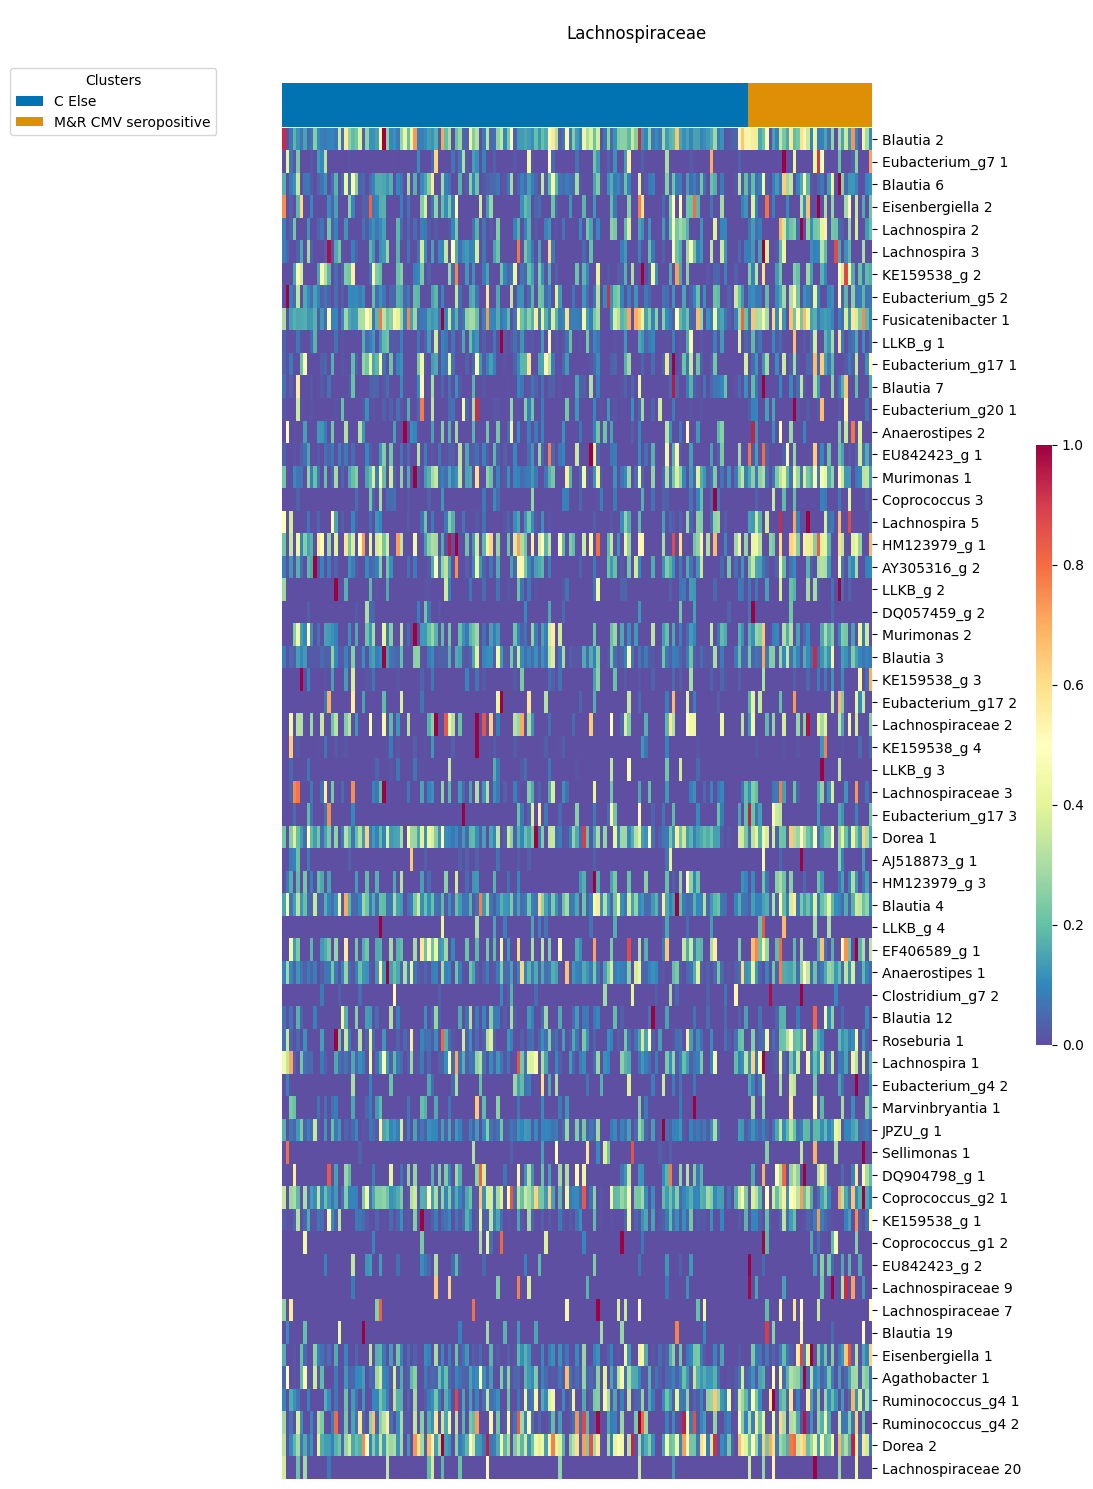

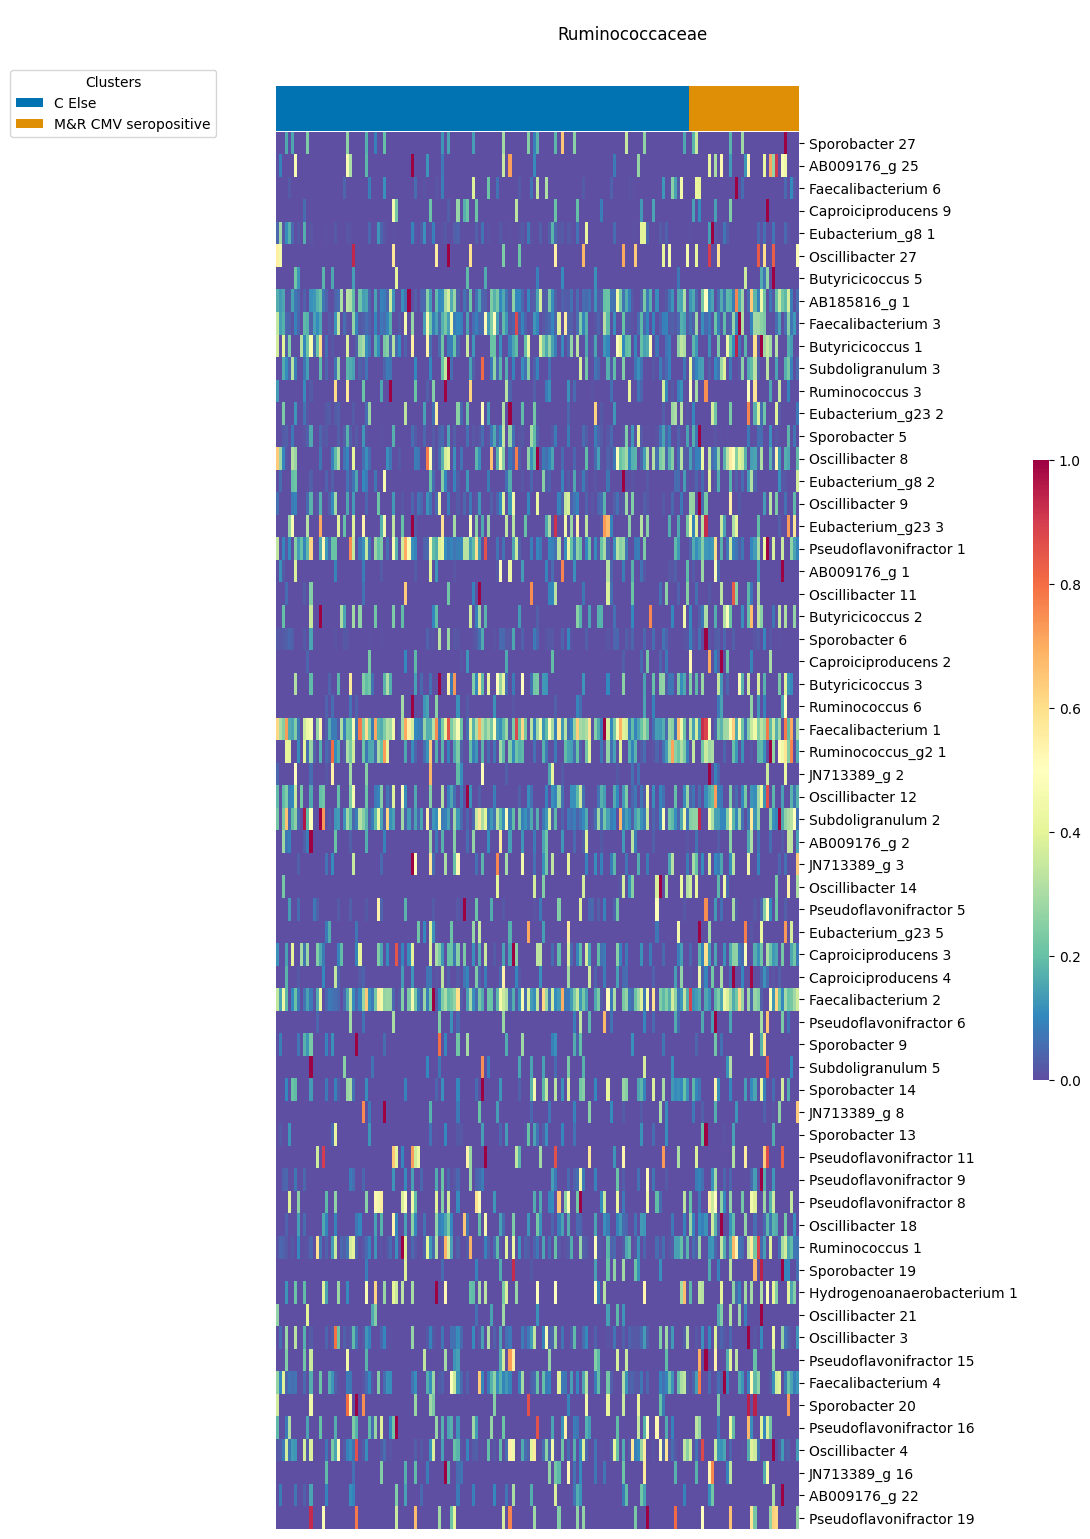

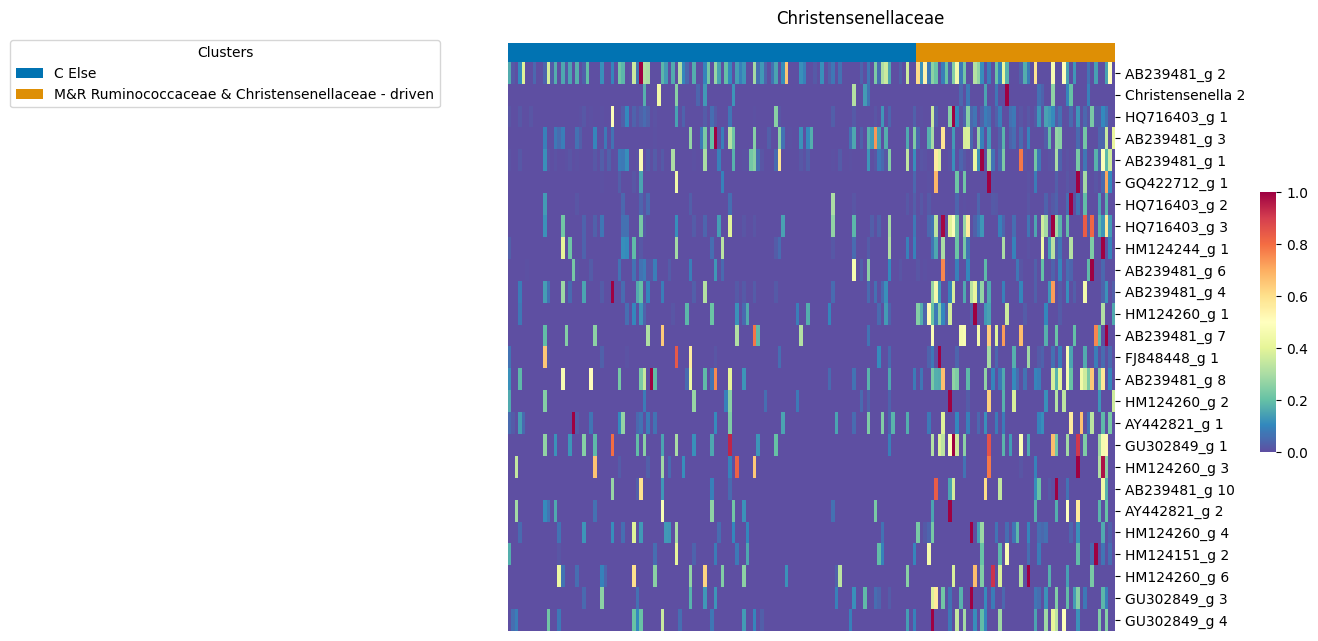

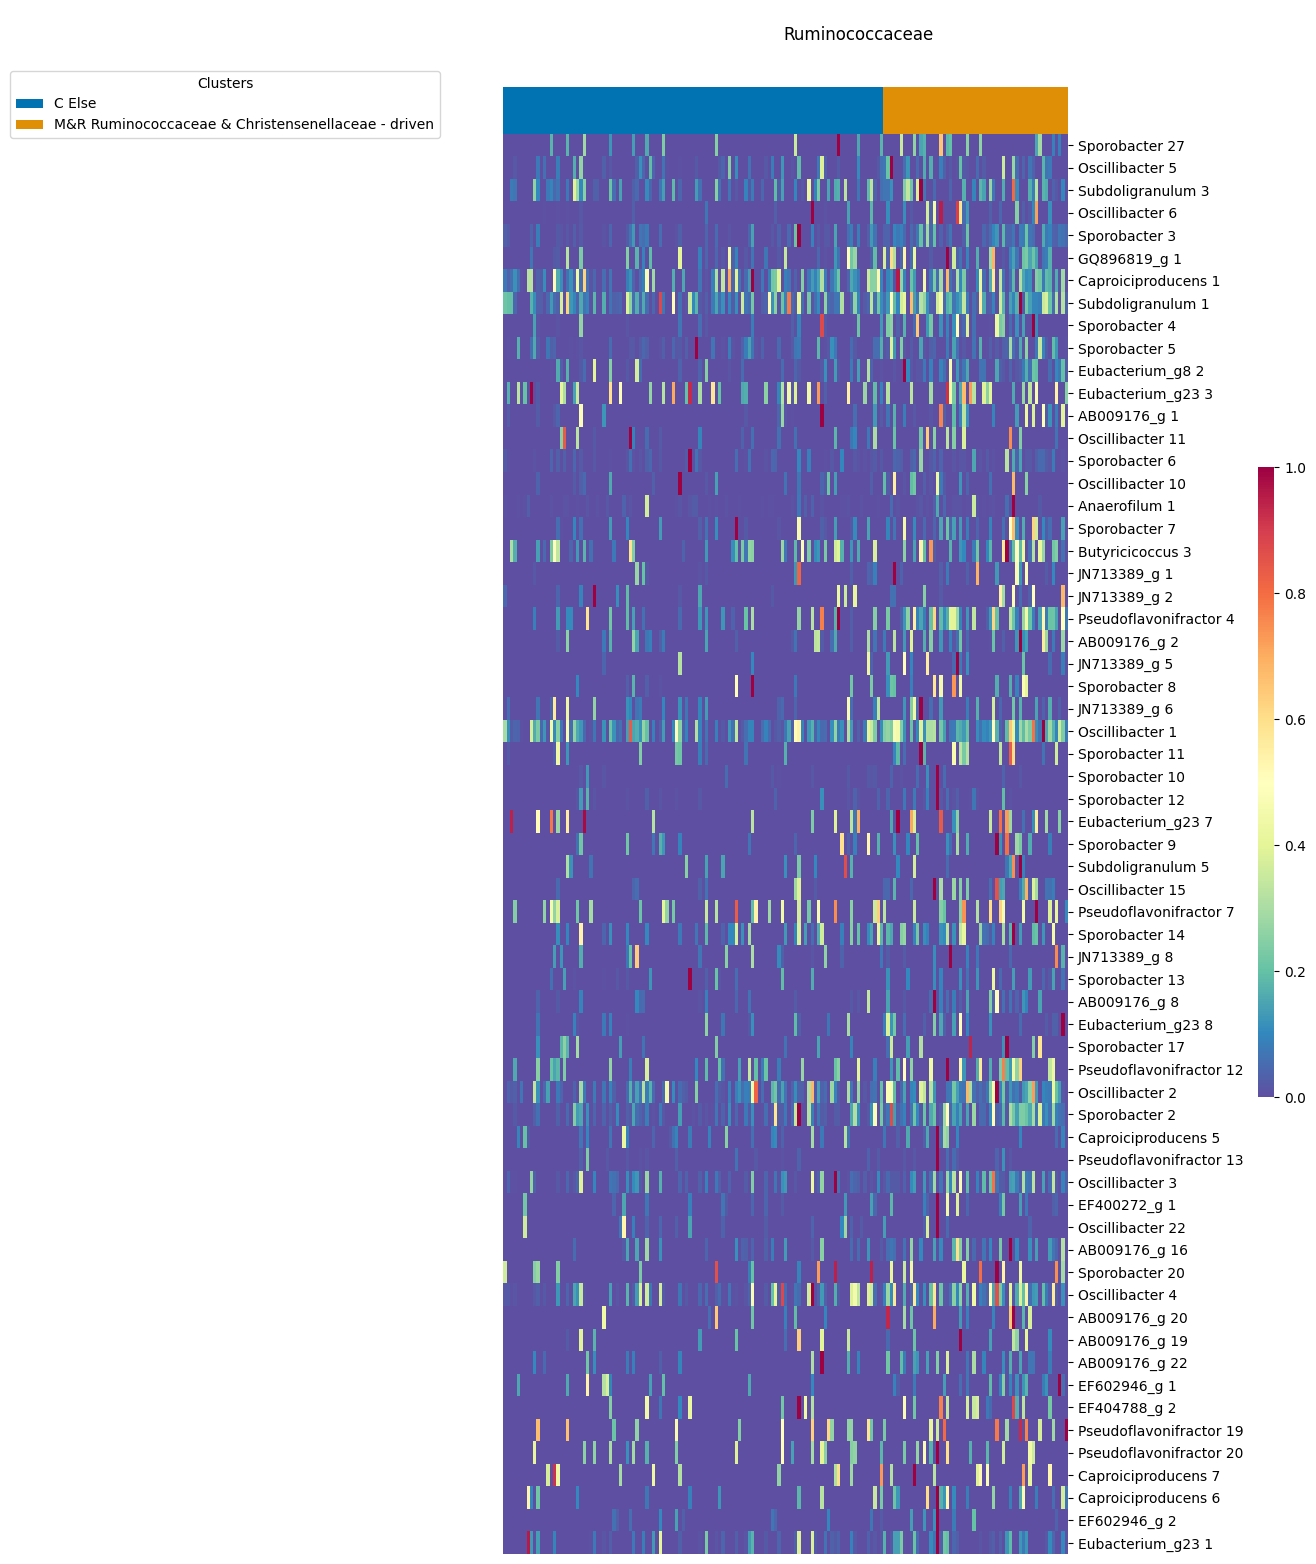

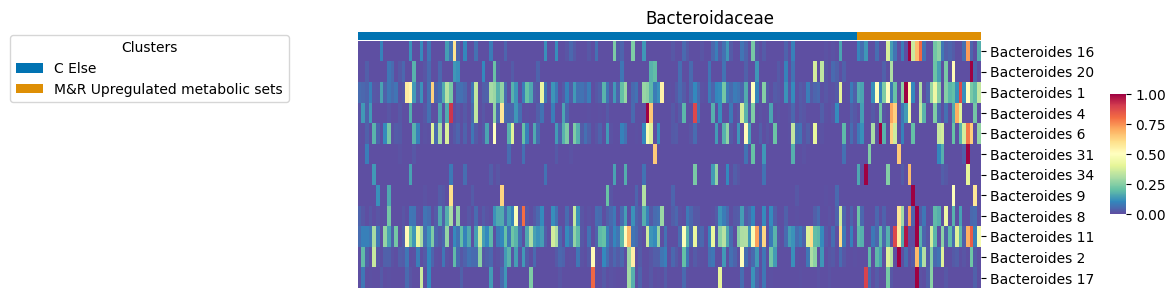

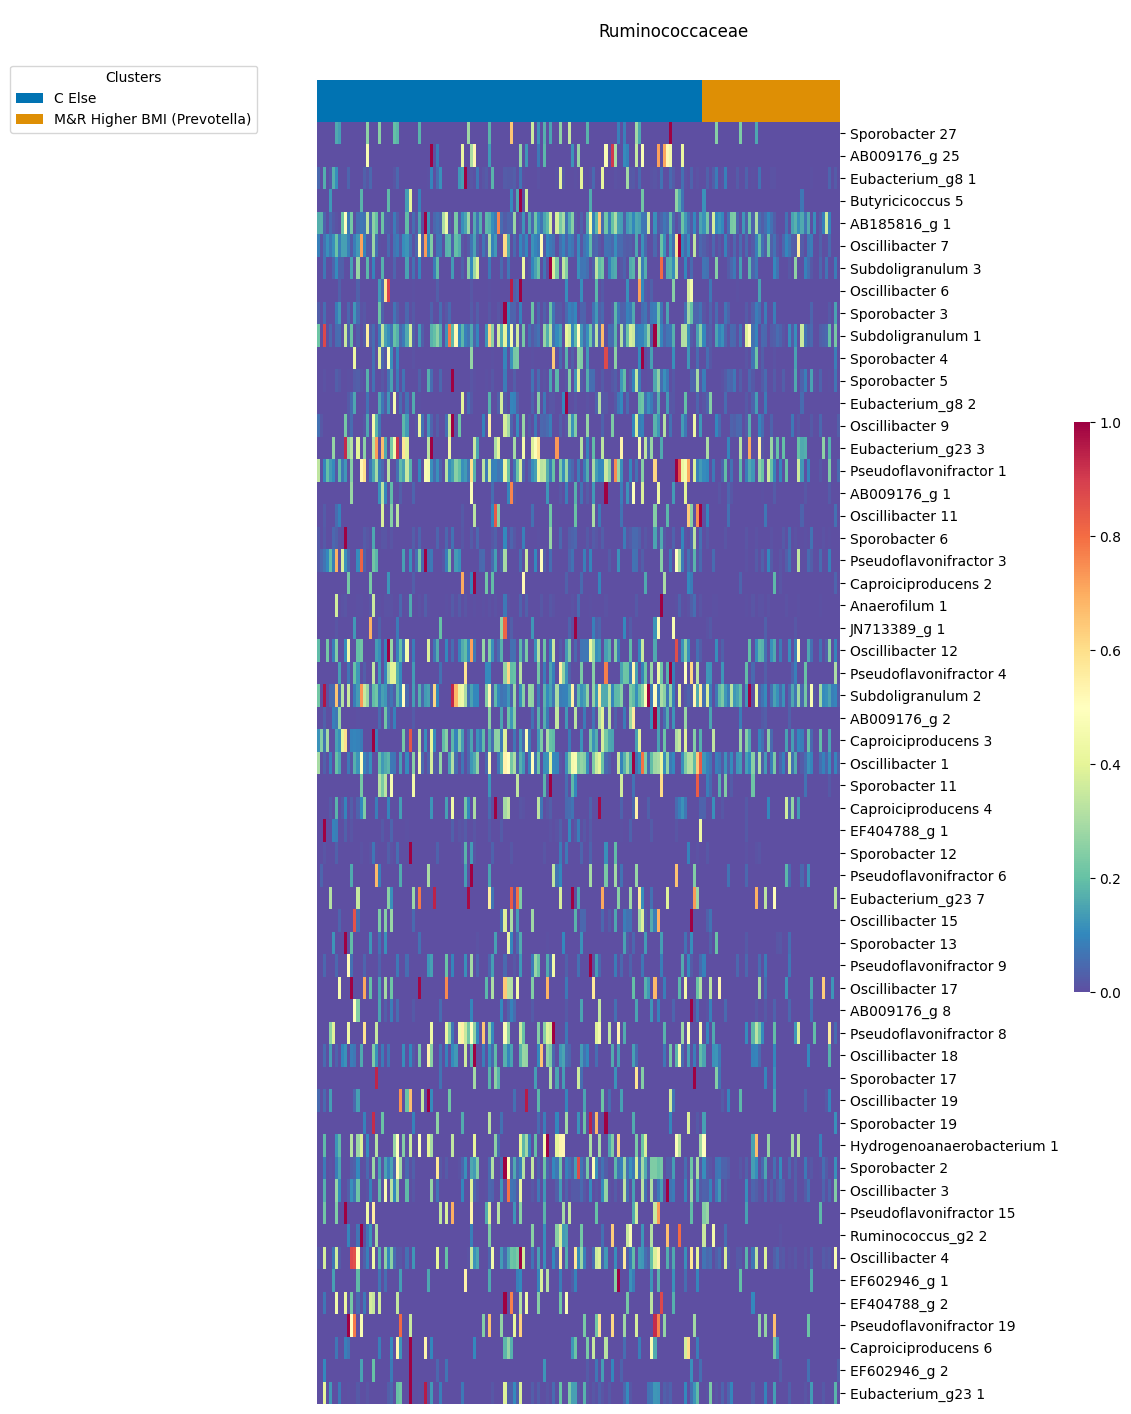

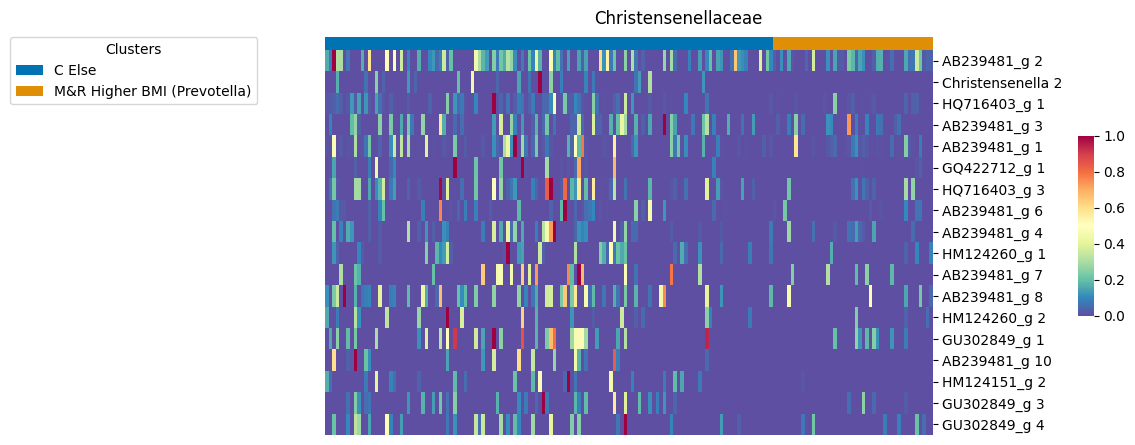

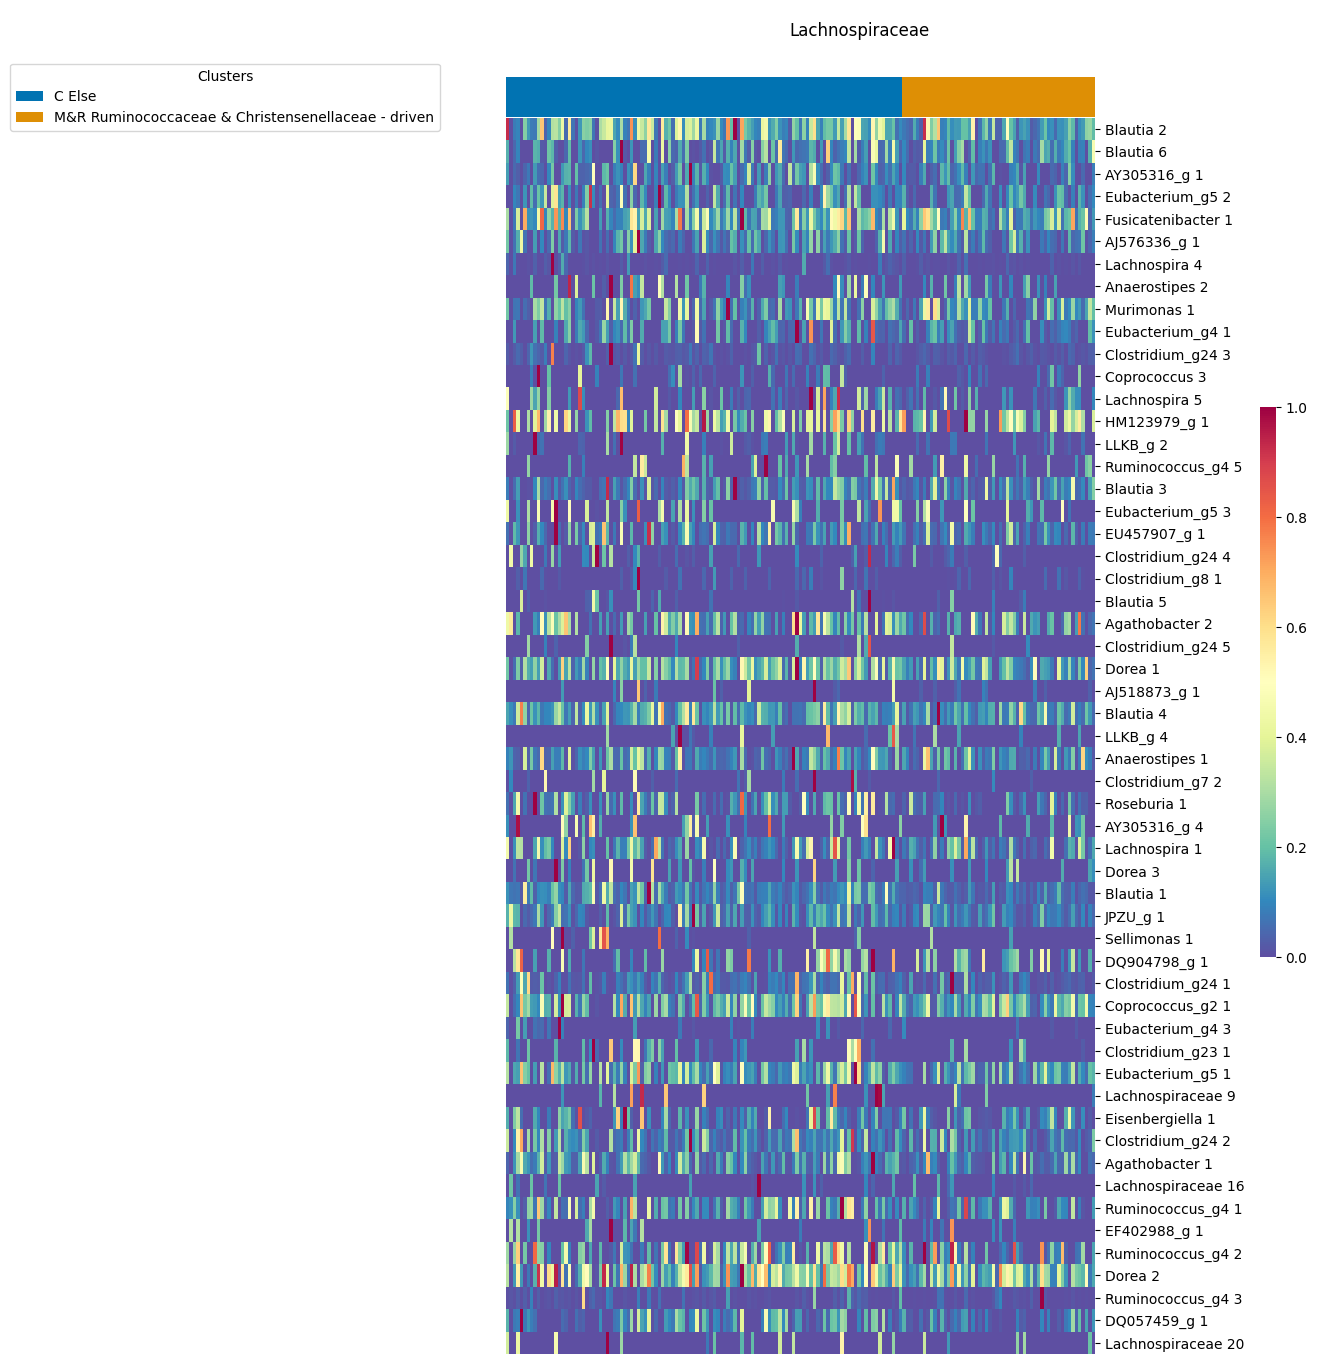

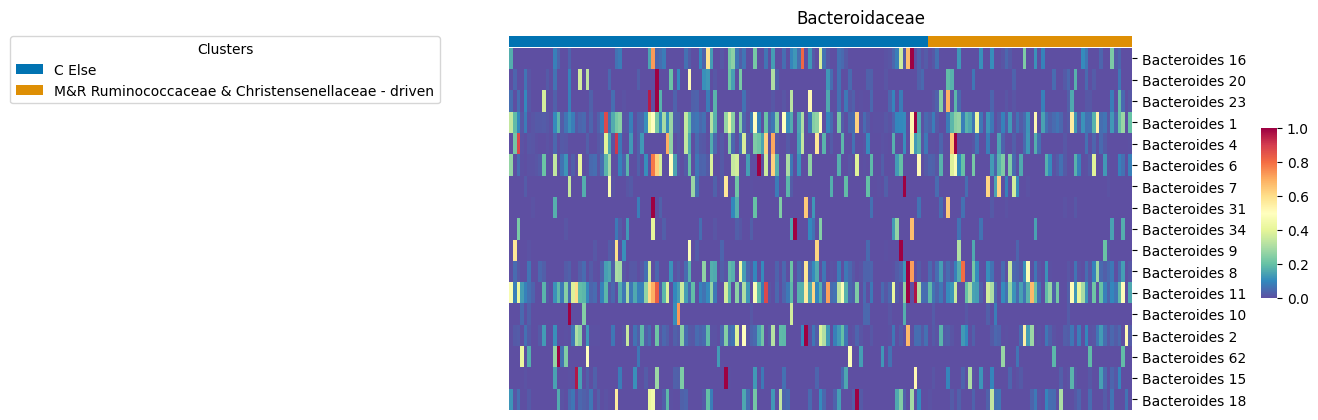

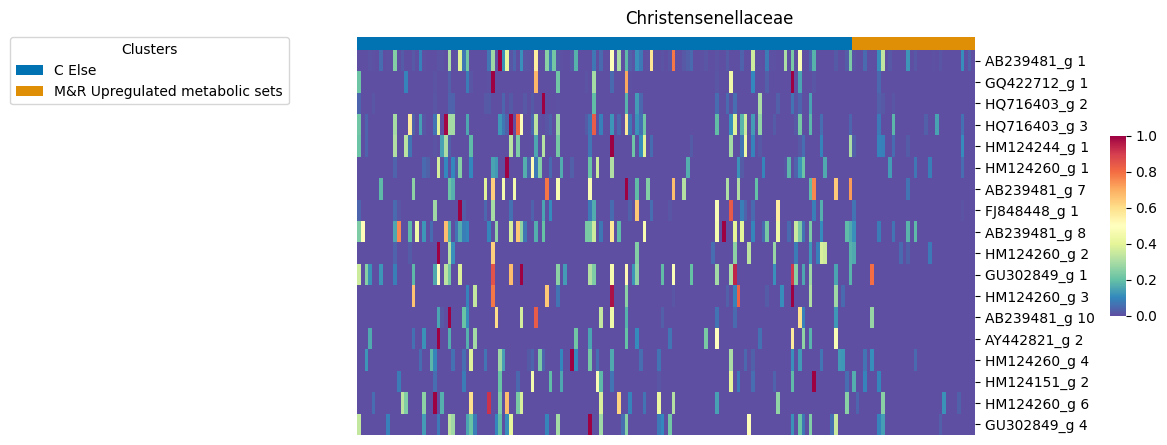

In [124]:
res = utils.gsea_analysis_bacteria(micro_data_norm.iloc[:,micro_data_norm.columns.isin(list(usable_micro['Donor'])+['taxaname'])],
                                clus_labels, bubble_dir, res_dir, [custom_bacteria_gene_lists])

[network.append(element) for element in res]

utils.plot_heatmaps_gsea_bacteria(res, micro_fused_rel[micro_fused_rel['Donor'].isin(list(usable_micro['Donor']))].reset_index(drop=True), 
                                clus_labels, micro_taxa, res_dir)

plotting.draw_network(network, clus_labels, res_dir)


# Microbiome Cytof RNAseq fusion

In [125]:
RNA_shared = aggregated[aggregated['Donor'].isin(cytof_meta['Donor'])]
RNA_shared = RNA_shared[RNA_shared['Donor'].isin(micro_fused['Donor'])]
RNA_shared.reset_index(drop=True, inplace = True)

micro_shared = micro_fused[micro_fused['Donor'].isin(aggregated['Donor'])]
micro_shared = micro_shared[micro_shared['Donor'].isin(cytof_meta['Donor'])]
micro_shared.reset_index(drop=True, inplace = True)

aux = cytof.copy()
aux['Donor'] = cytof_meta['Donor']
cytof_shared = aux[aux['Donor'].isin(aggregated['Donor'])]
cytof_shared = cytof_shared[cytof_shared['Donor'].isin(micro_fused['Donor'])]
cytof_shared.reset_index(drop=True, inplace = True)

In [126]:
# Cytof
idx = list(set(range(affinity_cytof.shape[0])).difference(list(cytof[~ ( (cytof_meta['Donor'].isin(micro_fused['Donor']))  & (cytof_meta['Donor'].isin(aggregated['Donor']))) ].index)))
affinity_cytof_mod = affinity_cytof[np.ix_(idx,idx)]
print(affinity_cytof_mod.shape)
# Microbiome
idx = list(set(range(affinity_microbe.shape[0])).difference(list(micro_fused[~ ( (micro_fused['Donor'].isin(cytof_meta['Donor']))  & (micro_fused['Donor'].isin(aggregated['Donor']))) ].index)))
affinity_microbe_mod = affinity_microbe[np.ix_(idx,idx)]
print(affinity_microbe_mod.shape)
# RNA
idx = list(set(range(affinity_RNA.shape[0])).difference(list(aggregated[~ ( (aggregated['Donor'].isin(cytof_meta['Donor']))  & (aggregated['Donor'].isin(micro_fused['Donor']))) ].index)))
affinity_RNA_mod = affinity_RNA[np.ix_(idx,idx)]
print(affinity_RNA_mod.shape)

(97, 97)
(97, 97)
(97, 97)


In [127]:
res_dir = results_dir + 'Microbiome_RNA_Cytof_fusion/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)
dim = affinity_RNA_mod.shape[0]//10

Silhouette score: 0.0805983451025471


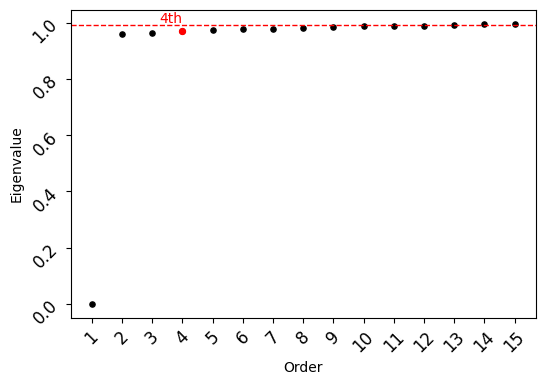

In [128]:
affinity_cytof_rna_micro = snf.snf([affinity_cytof_mod, 
                                    affinity_microbe_mod, 
                                    affinity_RNA_mod], K=dim)

n_clusters = 4
plotting.eigengap_visual(affinity_cytof_rna_micro, [n_clusters], res_dir)

clus_labels = utils.spectral_clustering_custom(affinity_cytof_rna_micro, n_clusters)

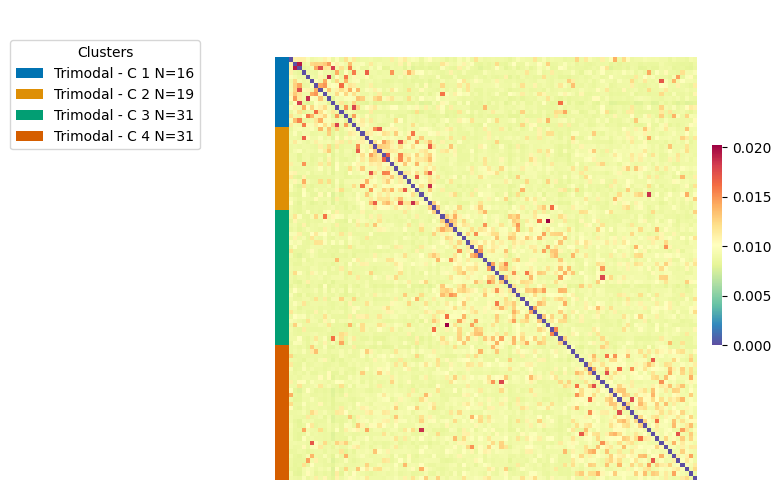

In [129]:
clus_labels.replace({'C 0': 'Trimodal - C 1', 'C 1': 'Trimodal - C 2', 'C 2': 'Trimodal - C 3', 'C 3': 'Trimodal - C 4'}, inplace=True)
plotting.draw_clustermap(clus_labels, affinity_cytof_rna_micro, res_dir, 'no')

    Shannon index  Simpson index  Chao1 richness         Cluster
0        5.404588       0.956193           143.0  Trimodal - C 1
1        4.803342       0.890112           165.0  Trimodal - C 4
2        5.667028       0.960775           164.0  Trimodal - C 3
3        5.151253       0.929988           135.0  Trimodal - C 4
4        2.185117       0.484440            65.0  Trimodal - C 3
..            ...            ...             ...             ...
92       5.801673       0.963728           170.0  Trimodal - C 3
93       4.720536       0.938593            72.0  Trimodal - C 2
94       4.564746       0.888319           129.0  Trimodal - C 1
95       5.887697       0.970314           158.0  Trimodal - C 3
96       5.613101       0.960746           132.0  Trimodal - C 3

[97 rows x 4 columns]
['Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 3', 'Trimodal - C 2']
[('Trimodal - C 1', 'Trimodal - C 4'), ('Trimodal - C 1', 'Trimodal - C 3'), ('Trimodal - C 1', 'Trimodal - C 2'), ('Trimoda

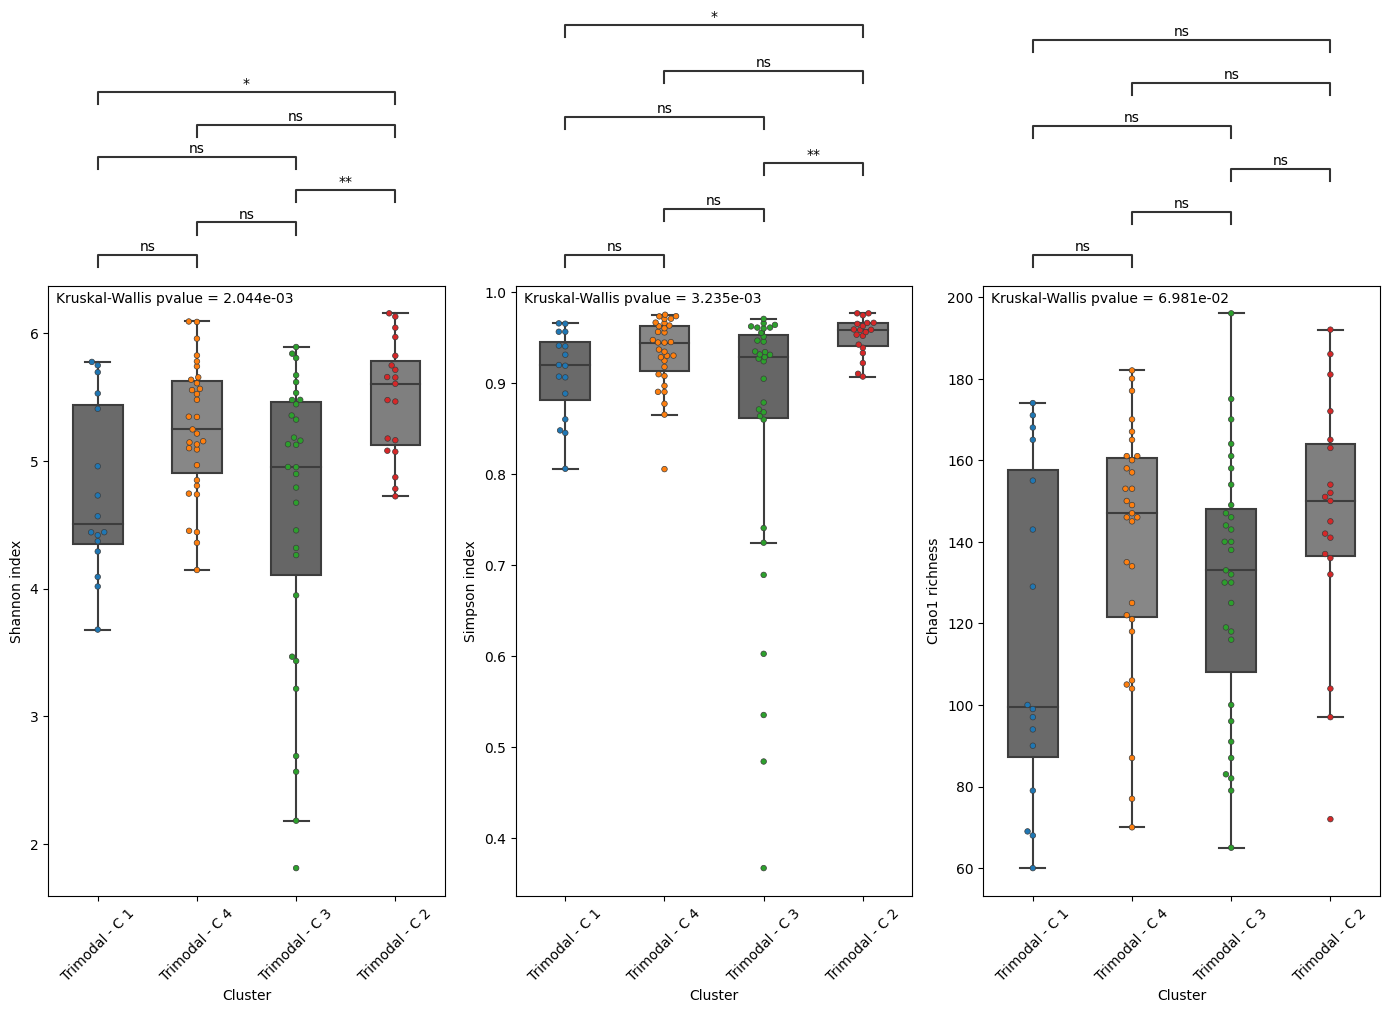

In [130]:
plotting.alpha_diversity_microbiome(micro_fused_rel[micro_fused_rel['Donor'].isin(list(micro_shared['Donor']))].drop(columns=['Donor']), 
                                                    micro_shared['Donor'], clus_labels, res_dir)

In [131]:
multi_chord['Cytof+Micro+RNA'] = clus_labels

In [132]:
multi_chord


Cytof+RNA                                          Micro+RNA  \
0      C&R 4                     M&R Upregulated metabolic sets   
1      C&R 5  M&R Ruminococcaceae & Christensenellaceae - dr...   
2      C&R 4  M&R Ruminococcaceae & Christensenellaceae - dr...   
3      C&R 3                        M&R Higher BMI (Prevotella)   
4      C&R 1                        M&R Higher BMI (Prevotella)   
..       ...                                                ...   
92     C&R 5                        M&R Higher BMI (Prevotella)   
93     C&R 2                               M&R CMV seropositive   
94     C&R 1  M&R Ruminococcaceae & Christensenellaceae - dr...   
95     C&R 2                               M&R CMV seropositive   
96     C&R 5  M&R Ruminococcaceae & Christensenellaceae - dr...   

   Cytof+Micro+RNA  
0   Trimodal - C 1  
1   Trimodal - C 4  
2   Trimodal - C 3  
3   Trimodal - C 4  
4   Trimodal - C 3  
..             ...  
92  Trimodal - C 3  
93  Trimodal - C 2  
94  Trimodal - C 1  
95  Trimodal - C 3  
96  Trimodal - C 3  

[97 rows x 3 columns]

## Save data for Cytof Microbiome RNA comparisons vs 2 view fusions

In [133]:
multi_chord.groupby(['Cytof+Micro+RNA', 'Cytof+RNA']) \
    .size().to_frame(name = 'value').reset_index().to_csv(chord_dir+'multi_chord_cmr_cr.csv', sep='\t')
    
multi_chord.groupby(['Cytof+Micro+RNA', 'Micro+RNA']) \
    .size().to_frame(name = 'value').reset_index().to_csv(chord_dir+'multi_chord_cmr_mr.csv', sep='\t')

## Logistic Regression on clusters

Size of metadata: (96, 393)
Size of metadata after NaNs removal: (90, 391)
Shape of the regression input: (90, 8)
Trimodal - C 1
Optimization terminated successfully.
         Current function value: 0.418137
         Iterations: 59
         Function evaluations: 60
         Gradient evaluations: 60
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   90
Model:                          Logit   Df Residuals:                       81
Method:                           MLE   Df Model:                            8
Date:                Mar, 24 Set 2024   Pseudo R-squ.:                 0.07196
Time:                        15:09:05   Log-Likelihood:                -37.632
converged:                       True   LL-Null:                       -40.551
Covariance Type:            nonrobust   LLR p-value:                    0.6655
                             coef    std err          z      P>|z| 

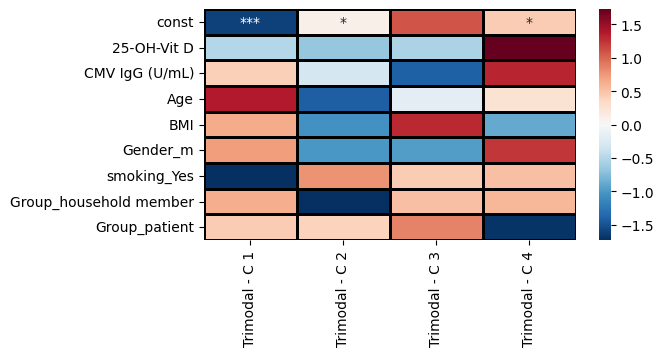

In [134]:
network = []
clus, parameters, pvalues = utils.lr_custom(RNA_shared, meta, clus_labels, res_dir)

network = utils.add_to_network(clus, parameters, pvalues, 'LR_reg', network)

## One vs Rest Testing

In [135]:
genenames = normalized_counts['genename']
usable_RNA = normalized_counts.drop(columns = 'genename')
usable_RNA = usable_RNA[[c for c in usable_RNA.columns if c in list(RNA_shared['Donor'])]]
usable_RNA['genename'] = genenames
usable_RNA.reset_index(drop = True, inplace=True)

usable_cytof = cytof_meta[cytof_meta['Donor'].isin(cytof_shared['Donor'])]
usable_cytof.drop(columns = 'Donor', inplace = True)
usable_cytof.reset_index(drop = True, inplace = True)

usable_micro = micro_fused[micro_fused['Donor'].isin(micro_shared['Donor'])]
usable_micro.reset_index(drop = True, inplace = True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_54235/818301692.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
single_asv_data = micro_data_norm.set_index('taxaname').T
single_asv_data = single_asv_data[single_asv_data.index.isin(usable_micro['Donor'])]
single_asv_data.columns = [list(micro_taxa[micro_taxa['taxon_name'] == taxon]['taxon_id'])[0] for taxon in single_asv_data.columns]
single_asv_data.reset_index(inplace=True)
res = plotting.micro_analysis(single_asv_data, clus_labels, micro_taxa, res_dir)

#[network.append(element) for element in res]


















   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)









   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)


Exception ignored from cffi callback <function _processevents at 0x2a4eb7100>:
Traceback (most recent call last):
  File "/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/env/lib/python3.11/

['Trimodal - C 2', 'Trimodal - C 2', 'Trimodal - C 2', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 2', 'Trimodal - C 3', 'Trimodal - C 1', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 4', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 3', 'Trimodal - C 4', 'Trimodal - C 4', 'Trimodal - C 1', 'Trimodal - C 1', 'Trimodal - C 3', 'Trimodal - C 2', 'Trimodal - C 2', 'Trimodal - C 3', 'Trimodal - C 4', 'Trimodal - C 1', 'Trimodal - C 1', 'Trimodal - C 3', 'Trimodal - C 4', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 2', 'Trimodal - C 1', 'Trimodal - C 3', 'Trimodal - C 2', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 2', 'Trimodal - C 4', 'Trimodal - C 2', 'Trimodal - C 3', 'Trimodal - C 3', 'Trimodal - C 2', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal - C 2', 'Trimodal - C 1', 'Trimodal - C 4', 'Trimodal

## Cytof clusters analysis

Cytof number of columns 22
No need to drop Donor


/Users/fabioaffaticati/Desktop/Work/activ_covid-tcell-omics/src/modules/utils.py:573: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



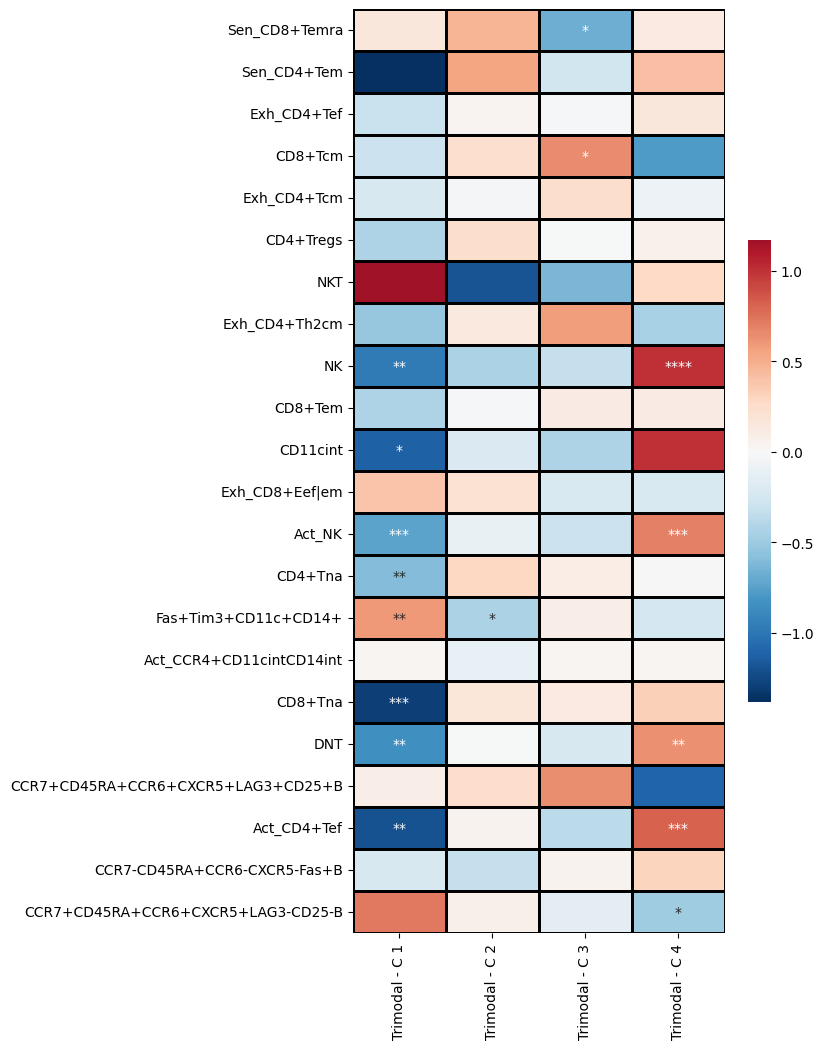

In [137]:
r = utils.cytof_clusters_analysis(usable_cytof,clus_labels, res_dir)

network = utils.add_to_network(list(r[0].index), pd.DataFrame(r[1]), pd.DataFrame(r[0].reset_index(drop=True)), r[2], network)

## GSEA

In [138]:
gsea_res = utils.gsea_analysis(usable_RNA, clus_labels, res_dir, hallmark)

# Add GSEA results to the network
[network.append(element) for element in gsea_res]

plotting.draw_network(network, clus_labels, res_dir)

2024-09-24 14:43:13,784 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 14:43:16,319 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 14:43:19,024 [WARNING] Dropping duplicated gene names, only keep the first values
2024-09-24 14:43:21,554 [WARNING] Dropping duplicated gene names, only keep the first values


<class 'pyvis.network.Network'> |N|=32 |E|=35

## GSEA on BACTERIA

Cluster Trimodal - C 1
Cluster Trimodal - C 2
Cluster Trimodal - C 3
Cluster Trimodal - C 4
{'source': 'Ruminococcaceae', 'target': 'Trimodal - C 2', 'weight': 0.928151976582699, 'origin': 'GSEA_bacteria', 'genes': 'Butyricicoccus 5;AB009176_g 25;Pseudoflavonifractor 11;Sporobacter 11;Oscillibacter 12;EF602946_g 2;EF400272_g 1;Ruminococcus_g2 2;Eubacterium_g8 1;Caproiciproducens 5;Oscillibacter 7;Pseudoflavonifractor 19;Pseudoflavonifractor 1;Pseudoflavonifractor 13;Oscillibacter 18;EF400272_g 2;EF404788_g 1;AB009176_g 22;Oscillibacter 11;Pseudoflavonifractor 3;Caproiciproducens 9;Oscillibacter 6;GQ896819_g 1;Oscillibacter 1;JN713389_g 16;Oscillibacter 22;Pseudoflavonifractor 12;Pseudoflavonifractor 20;Sporobacter 12;Subdoligranulum 2;Pseudoflavonifractor 4;Subdoligranulum 5;Oscillibacter 27;Hydrogenoanaerobacterium 1;JN713389_g 6;AB009176_g 19;JN713389_g 5;Ruminococcus 6;Sporobacter 10;Subdoligranulum 1;Eubacterium_g23 2;Sporobacter 27;AB009176_g 16;Eubacterium_g23 3;Caproiciproducens

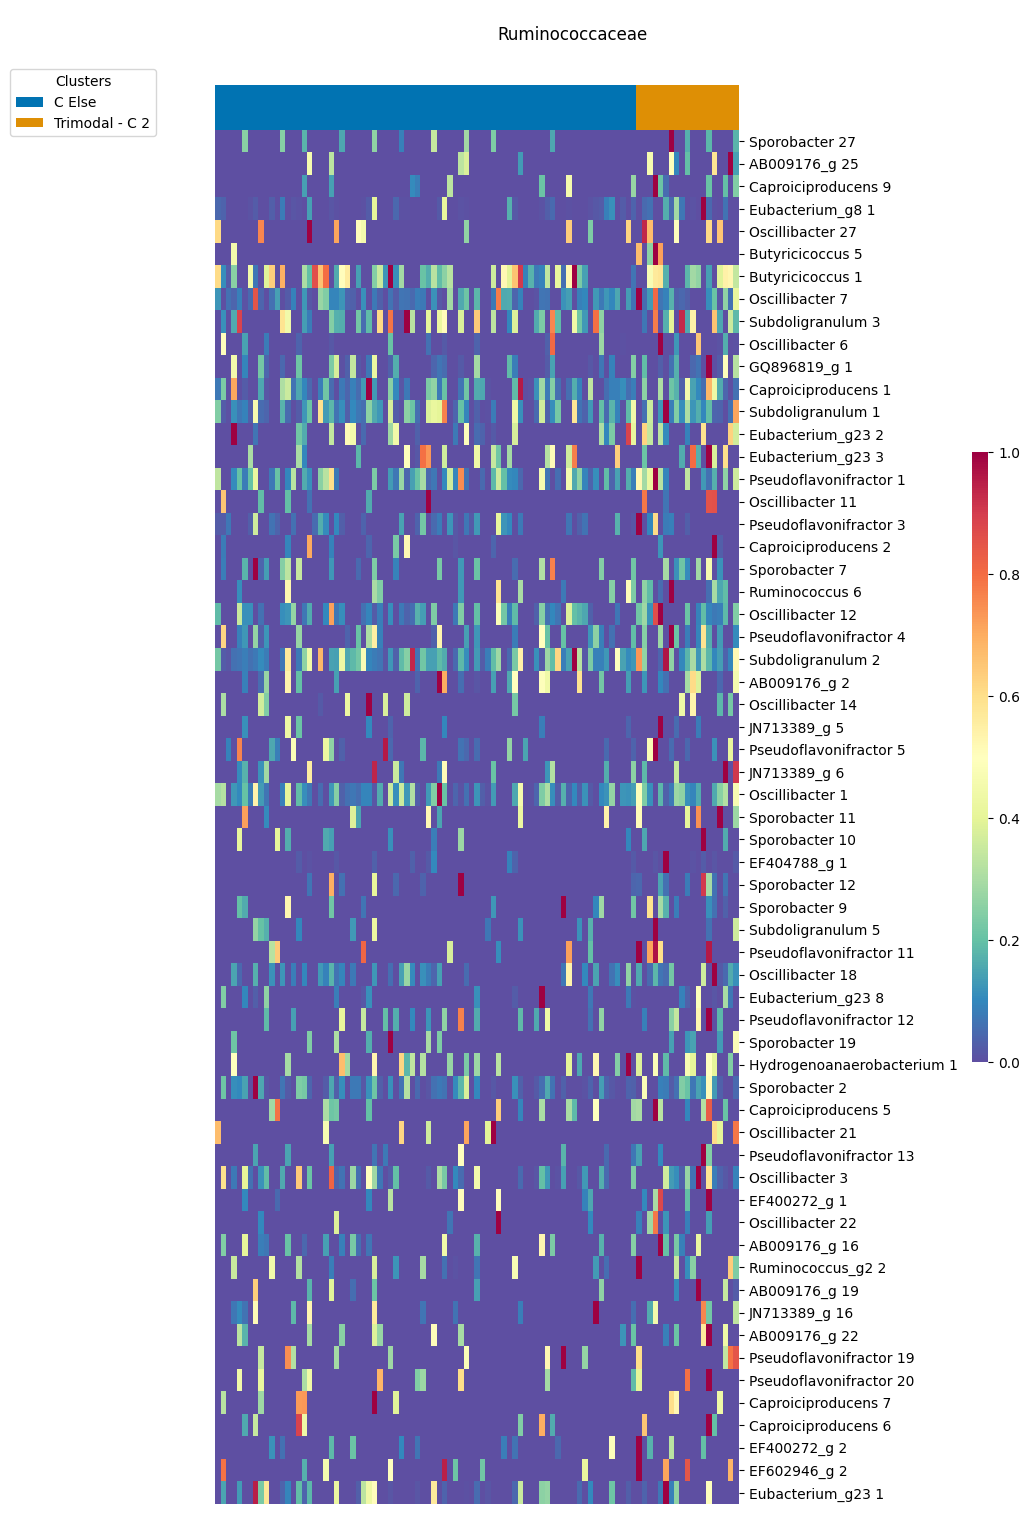

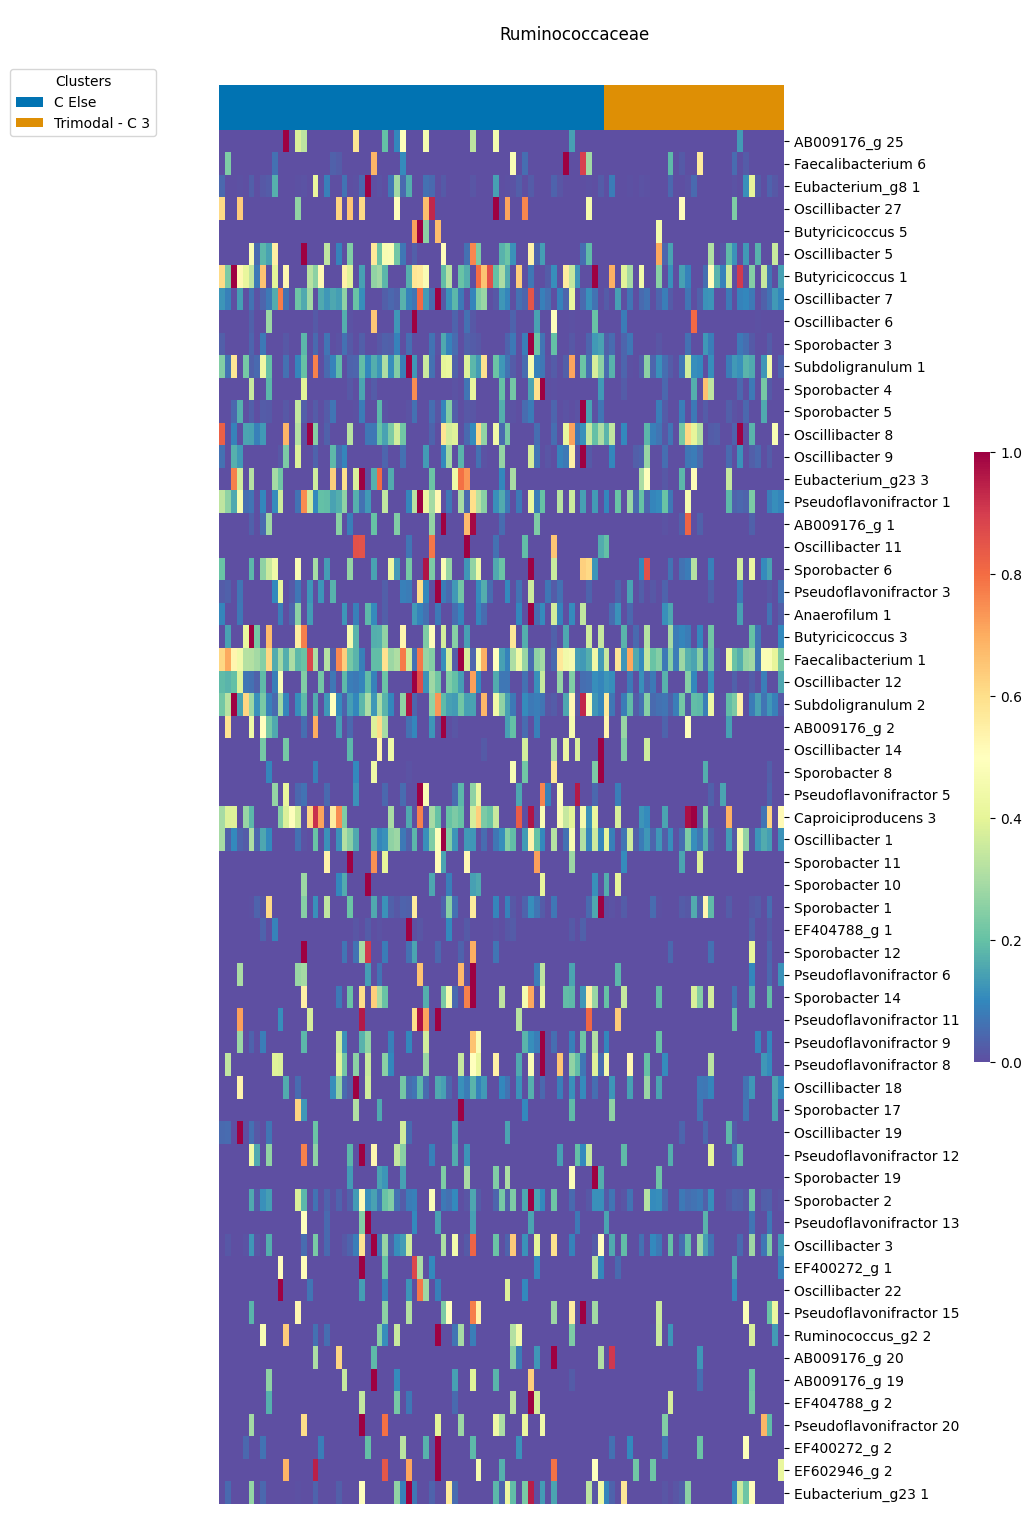

In [139]:
res = utils.gsea_analysis_bacteria(micro_data_norm.iloc[:,micro_data_norm.columns.isin(list(usable_micro['Donor'])+['taxaname'])],
                                clus_labels, bubble_dir, res_dir, [custom_bacteria_gene_lists])

[network.append(element) for element in res]

utils.plot_heatmaps_gsea_bacteria(res, micro_fused_rel[micro_fused_rel['Donor'].isin(list(usable_micro['Donor']))].reset_index(drop=True), 
                                clus_labels, micro_taxa, res_dir)